In [4]:
from metavision_core.event_io import EventsIterator, RawReader
from metavision_sdk_core import BaseFrameGenerationAlgorithm, ColorPalette

ModuleNotFoundError: No module named 'metavision_core'

In [ ]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [8, 6]
plt.gray()
import os
import cv2
import h5py
from metavision_core.event_io import EventsIterator, RawReader
from metavision_sdk_core import BaseFrameGenerationAlgorithm, ColorPalette


ModuleNotFoundError: No module named 'metavision_core'

<Figure size 800x600 with 0 Axes>

In [8]:
# Helper functions

def plot_event_density(raw_data):
    # subsample events to determine the start/end of recording to convert
    fps = 1000
    delta_t_us = 1e6/fps
    
    ev_list = []
    while not raw_data.is_done():
        events = raw_data.load_delta_t(delta_t_us)
        ev_list.append(len(events))   
        
    plt.figure()
    time_frame = delta_t_us*np.arange(0, len(ev_list))/1e6
    avg_ev = np.mean(ev_list)
    raw_data.reset()
    print('Average event rate: %.2f' %avg_ev)
    plt.plot(time_frame, ev_list)
    plt.xlabel('Time, s')
    plt.ylabel('#Events')
    plt.axhline(avg_ev, color='r', linestyle='--')
    plt.title('Events accumulated over %.2f ms' %(1e-3*delta_t_us))
    return avg_ev

def read_time_volume(raw_data, start_t_us, delta_t_us):
    raw_data.reset()
    if start_t_us > raw_data.current_time:
        raw_data.seek_time(start_t_us)
    events_vol = raw_data.load_delta_t(delta_t_us)
    # events_vol['t'] -= int(start_t_us)
    return events_vol

def viz_plus_events(events, height, width):
    img = np.full((height, width), 0, dtype=np.uint8)
    id_plus = events['p']>0
    events_plus = events[id_plus]
    img[events_plus['y'], events_plus['x']] = 255
    return img

def viz_minus_events(events, height, width):
    img = np.full((height, width), 0, dtype=np.uint8)
    id_plus = events['p']==0
    events_plus = events[id_plus]
    img[events_plus['y'], events_plus['x']] = 255
    return img

def viz_events(events, height, width):
    img = np.zeros((height, width, 3), dtype=np.uint8)
    # check that all events are within width-heigh
    ids = np.logical_and(events['y'] < height, events['x'] < width) 
    events = events[ids]
    events_plus = events[events['p']>0]
    events_minus = events[events['p']==0]
    img[events_plus['y'], events_plus['x'], 0] = 255
    img[events_minus['y'], events_minus['x'], 2] = 255
    return img

def plot_3d(event_data):
    events = event_data.copy()
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    # p = ['r' if p==1 else 'b' for p in events['p']]
    t = (events['t']-events['t'][0])*1e-3
    im = ax.scatter(t, events['x'], events['y'], c=t, marker='.', cmap='viridis', alpha=0.5)
    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('X')
    ax.set_ylim(ax.get_ylim()[::-1])  # Flip X (Y in the 3D plot)
    ax.set_zlabel('Y')
    ax.set_zlim(ax.get_zlim()[::-1])  # Flip Y (Z in the 3D plot)
    ax.set_title('Total N=%i events' %event_data.size)
    # Customize the view angle so it's easier to see that the scatter points lie
    ax.view_init(elev=20., azim=-135, roll=8)
    fig.colorbar(im, ax=ax)
    #ax.set_zlim(*ax.get_zlim()[::-1])  # reverse 'y' image axis

def gen_animator(raw_data, start_t_us, end_t_us, delta_t_us):
    imgs = []
    height, width = raw_data.get_size()
    for t in range(int(start_t_us), int(end_t_us), int(delta_t_us)):
        events = read_time_volume(raw_data, t, delta_t_us)
        img = viz_events(events, height, width)
        imgs.append(img)
    imgs = torch.tensor(imgs, dtype=torch.int32)
    # Create figure sized to match your image:
    fig, ax = plt.subplots(figsize=(width / 100, height / 100), dpi=100)

    # Remove all axis padding
    ax.set_position([0, 0, 1, 1])  # left, bottom, width, height
    ax.axis('off')                 # no x or y axis
    anim = splt.animator(imgs, fig, ax)
    return anim
    
def find_high_event_intervals(raw_data, start_t_us, end_t_us, delta_t_us, threshold, filter=50):
    """
    Returns a list of (interval_start, interval_end) tuples for which 
    the number of events in the interval is > threshold.
    """
    high_intervals = []
    in_interval = False
    for t in range(int(start_t_us), int(end_t_us), int(delta_t_us)):
        # Read events for this time window
        events = read_time_volume(raw_data, t, delta_t_us)
        
        # Check how many events we have
        if len(events) > threshold and not in_interval:
            in_interval = True
            start_interval = t
        elif len(events) < threshold and in_interval:
            in_interval = False
            end_interval = t
            if end_interval - start_interval > filter*delta_t_us:
                high_intervals.append((start_interval, end_interval))
    raw_data.reset()    
    return high_intervals

def save_videos_for_intervals(raw_data, intervals, delta_t_us, end_of_video, output_prefix="video"):
    """
    Generates and saves a video file for each interval in 'intervals'.
    The video filename is constructed as output_prefix_<index>.mp4
    """
    margin = 500e3
    for i, (start_t, end_t) in enumerate(intervals):
        # Generate the animation for the specified interval
        start_t = max(0, start_t-margin)
        end_t = min(end_of_video, end_t+margin)
        anim = gen_animator(raw_data, start_t, end_t, delta_t_us)
        
        # Save animation as MP4 (requires ffmpeg)
        video_filename = f"cropped_videos/{output_prefix}_{i}.mp4"
        anim.save(video_filename, fps=1e6/delta_t_us, extra_args=["-vcodec", "libx264"])
        print(f"Saved {video_filename}")

def get_duration(raw_data):
    raw_data.reset()
    while not raw_data.is_done():
        raw_data.load_delta_t(1e6)
    duration = raw_data.current_time
    raw_data.reset()
    return duration

def save_relevant_videos(path_to_events, delta_t_us=10*1e3, threshold=2000):
    raw_data = RawReader(path_to_events)
    start_t_us = 0
    end_t_us = get_duration(raw_data)
    print(f"Duration: {end_t_us/1e6} s")
    avg_ev = plot_event_density(raw_data)
    threshold = avg_ev* 0.5 * delta_t_us/1e3
    print(f"Using threshold: {threshold}")
    high_intervals = find_high_event_intervals(raw_data, start_t_us, end_t_us, delta_t_us, threshold, filter=30)
    print(f"Found {len(high_intervals)} high event intervals")
    for _, (start_t, end_t) in enumerate(high_intervals):
        plt.axvspan(start_t*1e-6, end_t*1e-6, color='r', alpha=0.5)
    output_prefix = 'ev_' + os.path.basename(path_to_events).split('_')[2].split('.')[0]
    save_videos_for_intervals(raw_data, high_intervals, delta_t_us, end_t_us, output_prefix)
    plt.show(block=False)

## Reading data

In [11]:
import glob
dir_paths = glob.glob('Event_camera_data\\*.raw', recursive=True)
dir_paths

['Event_camera_data\\recording_2025-02-20_13-38-07.raw',
 'Event_camera_data\\recording_2025-02-20_13-41-38.raw',
 'Event_camera_data\\recording_2025-02-20_13-45-16.raw',
 'Event_camera_data\\recording_2025-02-20_13-47-09.raw']

In [4]:
path_to_events= 'Event_camera_data\\recording_2025-02-20_13-38-07.raw'

In [5]:
raw_data = RawReader(path_to_events)
raw_data

RawReader(Event_camera_data\recording_2025-02-20_13-38-07.raw)
current time : 0us done : False
current event index : 0
_begin_buffer 0,_end_buffer_ 0,  buffer_size 10000000

In [6]:
height, width = raw_data.get_size()
height, width

(720, 1280)

Average event rate: 456.72


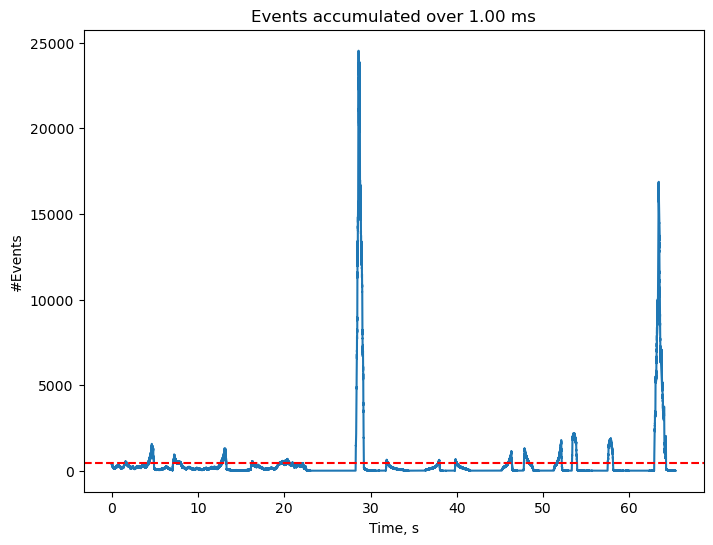

In [28]:
plot_event_density(raw_data)

In [8]:
raw_data.reset()
print(raw_data.current_time)

0


### slice of the event volume

In [8]:
start_t_us = 1*1e6 # 2 s
delta_t_us = 10*1e3 # 100 ms
events_vol = read_time_volume(raw_data, start_t_us, delta_t_us)
len(events_vol), events_vol

(446,
 array([( 551,  42, 0, 1000008), ( 459,  37, 0, 1000028),
        (1278, 111, 1, 1000086), ( 457,  62, 0, 1000092),
        (1275, 100, 0, 1000108), (1246, 106, 0, 1000219),
        ( 492, 231, 0, 1000320), ( 473,   4, 0, 1000347),
        ( 440,  27, 1, 1000422), ( 440,  60, 1, 1000438),
        ( 550,  48, 0, 1000469), ( 441,  20, 1, 1000498),
        ( 457,  52, 0, 1000550), (1254, 103, 0, 1000593),
        ( 473,  12, 0, 1000611), ( 439,  48, 1, 1000621),
        (1273,  94, 1, 1000632), ( 551,  58, 0, 1000639),
        ( 446,  11, 1, 1000653), ( 554,  66, 0, 1000665),
        ( 473,  45, 0, 1000693), ( 442,  30, 1, 1000727),
        ( 544,  60, 1, 1000739), (1265,  94, 0, 1000801),
        ( 443,  82, 1, 1000810), (1250, 105, 0, 1000820),
        ( 444,  31, 1, 1000841), (1275,  86, 1, 1000866),
        ( 476,  30, 0, 1000886), ( 473,  38, 0, 1000892),
        (1273, 112, 1, 1000901), ( 458,  54, 0, 1000906),
        (1274,  94, 1, 1000952), (1266,  93, 0, 1000954),
        

Text(0.5, 1.0, 'Projection of positive(red) and negative(blue) events over dt=100.0 ms')

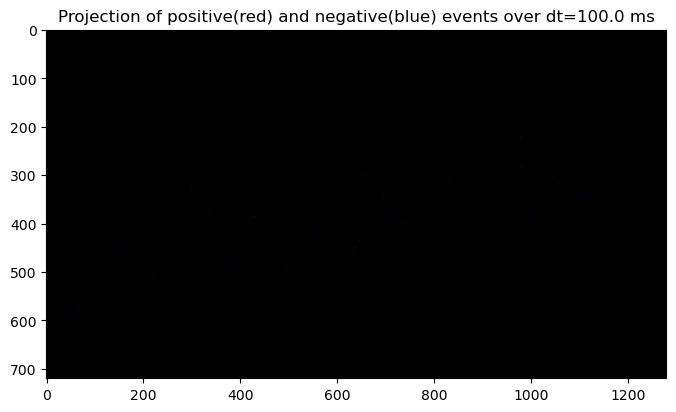

In [12]:
plt.imshow(viz_events(events_vol, height, width))
plt.title('Projection of positive(red) and negative(blue) events over dt=%.1f ms'%(1e-3*delta_t_us))

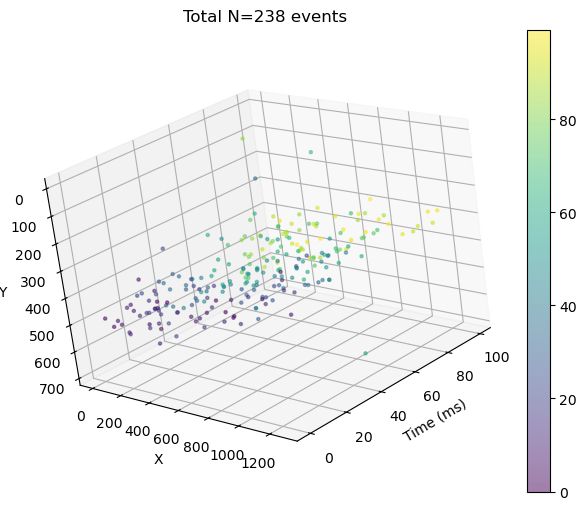

In [14]:
plot_3d(events_vol)

C:\Users\realenriquem\AppData\Local\Temp\ipykernel_21452\3378476678.py:83: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\bld\libtorch_1739475077952\work\torch\csrc\utils\tensor_new.cpp:257.)
  imgs = torch.tensor(imgs, dtype=torch.int32)


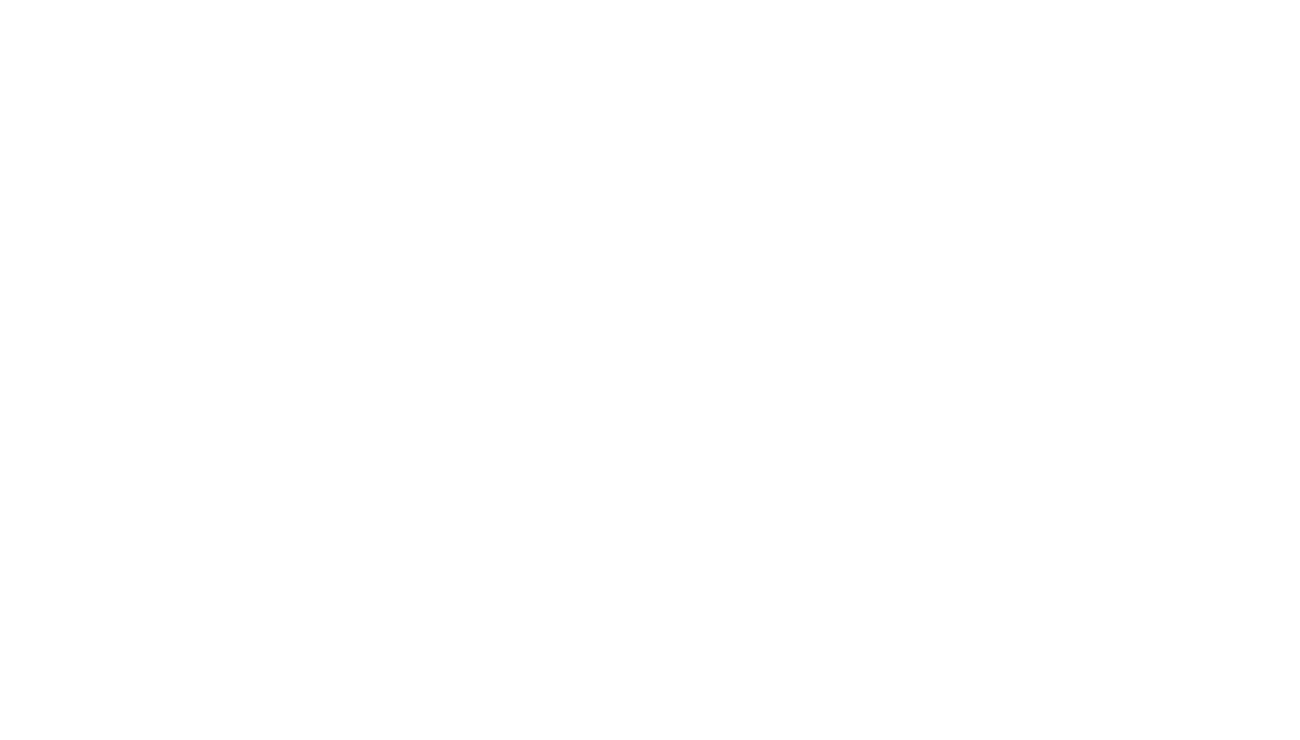

In [9]:
anim = gen_animator(raw_data, 2*1e6, 5*1e6, 10*1e3)
HTML(anim.to_html5_video())

In [78]:
start_t_us = 0*1e6
end_t_us = 70*1e6
delta_t_us = 10*1e3
threshold = 2000
high_intervals = find_high_event_intervals(raw_data, start_t_us, end_t_us, delta_t_us, threshold)
high_intervals

[(2510000, 5130000),
 (5430000, 6030000),
 (6330000, 7100000),
 (8900000, 9890000),
 (12070000, 13200000),
 (17440000, 18290000),
 (21130000, 22130000),
 (24140000, 26160000),
 (26180000, 27240000),
 (33260000, 34220000),
 (36800000, 37410000),
 (42430000, 43020000),
 (44790000, 45440000),
 (50480000, 51400000),
 (52760000, 53760000),
 (56340000, 57190000),
 (58330000, 58940000),
 (62480000, 63130000),
 (67880000, 69250000)]

In [81]:
# Sum of all intervals
sum([end-start for start, end in high_intervals])/delta_t_us

1925.0

Average event rate: 447.28


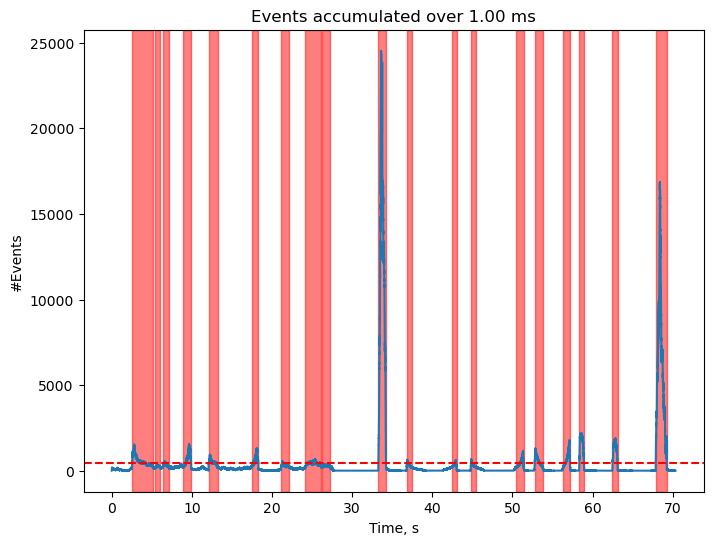

In [ ]:
plot_event_density(raw_data)

# Plot the intervals
for i, (start_t, end_t) in enumerate(high_intervals):
    plt.axvspan(start_t*1e-6, end_t*1e-6, color='r', alpha=0.5)

plt.show()

----------------------------------------
Cropping video  Event_camera_data\recording_2025-02-20_13-38-07.raw
Duration: 71.0 s
Average event rate: 447.28
Using threshold: 2236.3804622864127
Found 20 high event intervals
Saved cropped_videos/ev_13-38-07_0.mp4
Saved cropped_videos/ev_13-38-07_1.mp4
Saved cropped_videos/ev_13-38-07_2.mp4
Saved cropped_videos/ev_13-38-07_3.mp4
Saved cropped_videos/ev_13-38-07_4.mp4
Saved cropped_videos/ev_13-38-07_5.mp4
Saved cropped_videos/ev_13-38-07_6.mp4
Saved cropped_videos/ev_13-38-07_7.mp4
Saved cropped_videos/ev_13-38-07_8.mp4
Saved cropped_videos/ev_13-38-07_9.mp4
Saved cropped_videos/ev_13-38-07_10.mp4
Saved cropped_videos/ev_13-38-07_11.mp4
Saved cropped_videos/ev_13-38-07_12.mp4
Saved cropped_videos/ev_13-38-07_13.mp4
Saved cropped_videos/ev_13-38-07_14.mp4
Saved cropped_videos/ev_13-38-07_15.mp4
Saved cropped_videos/ev_13-38-07_16.mp4
Saved cropped_videos/ev_13-38-07_17.mp4
Saved cropped_videos/ev_13-38-07_18.mp4


C:\Users\realenriquem\AppData\Local\Temp\ipykernel_21452\3378476678.py:85: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(width / 100, height / 100), dpi=100)


Saved cropped_videos/ev_13-38-07_19.mp4


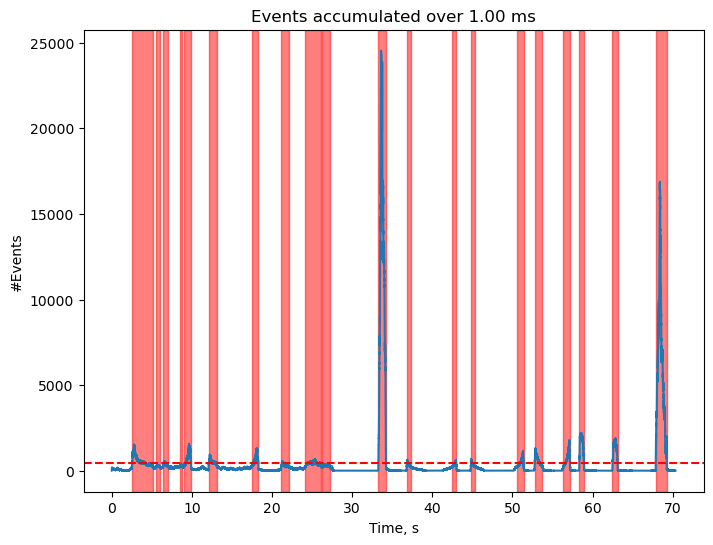

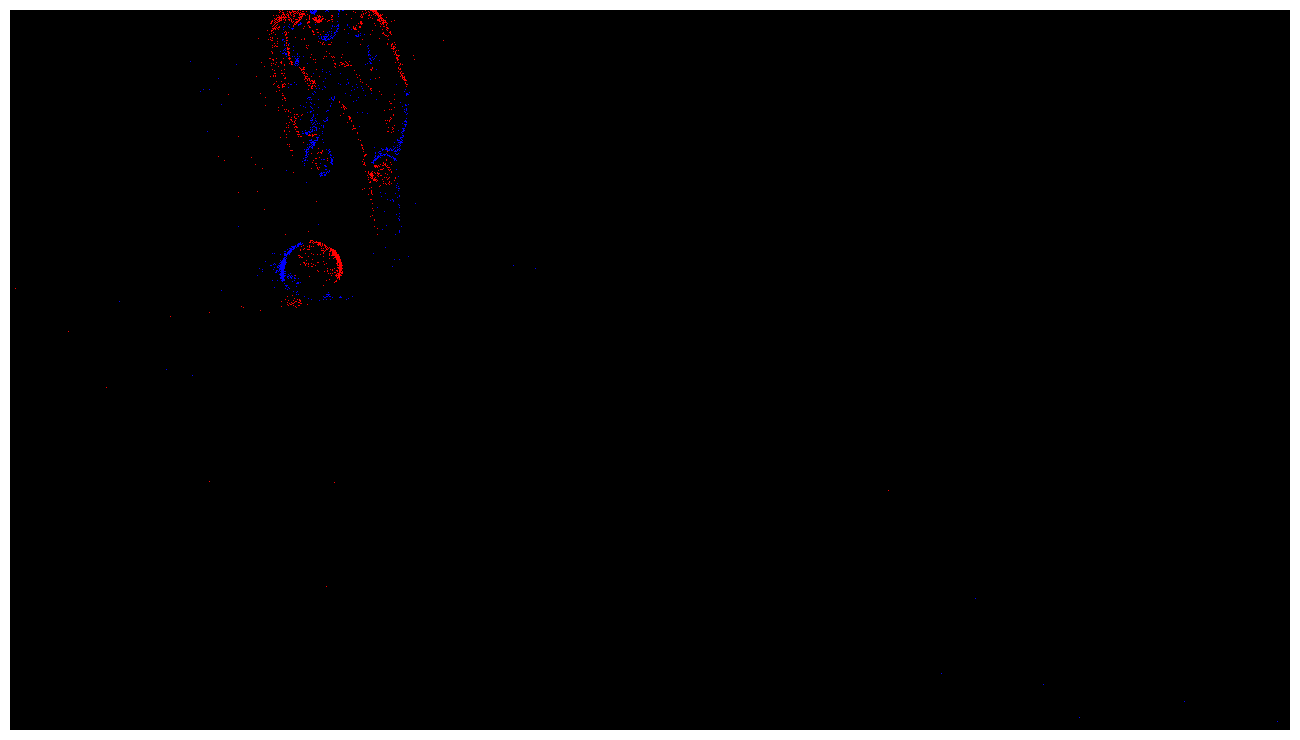

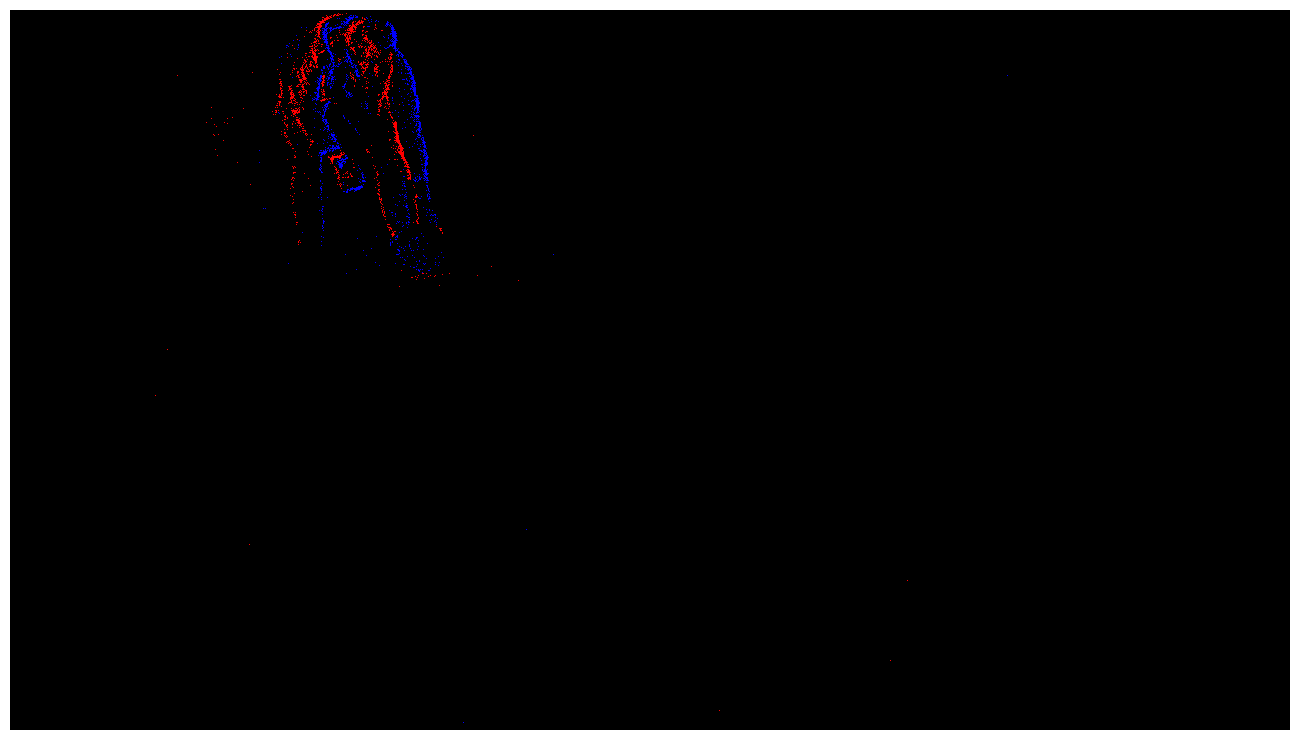

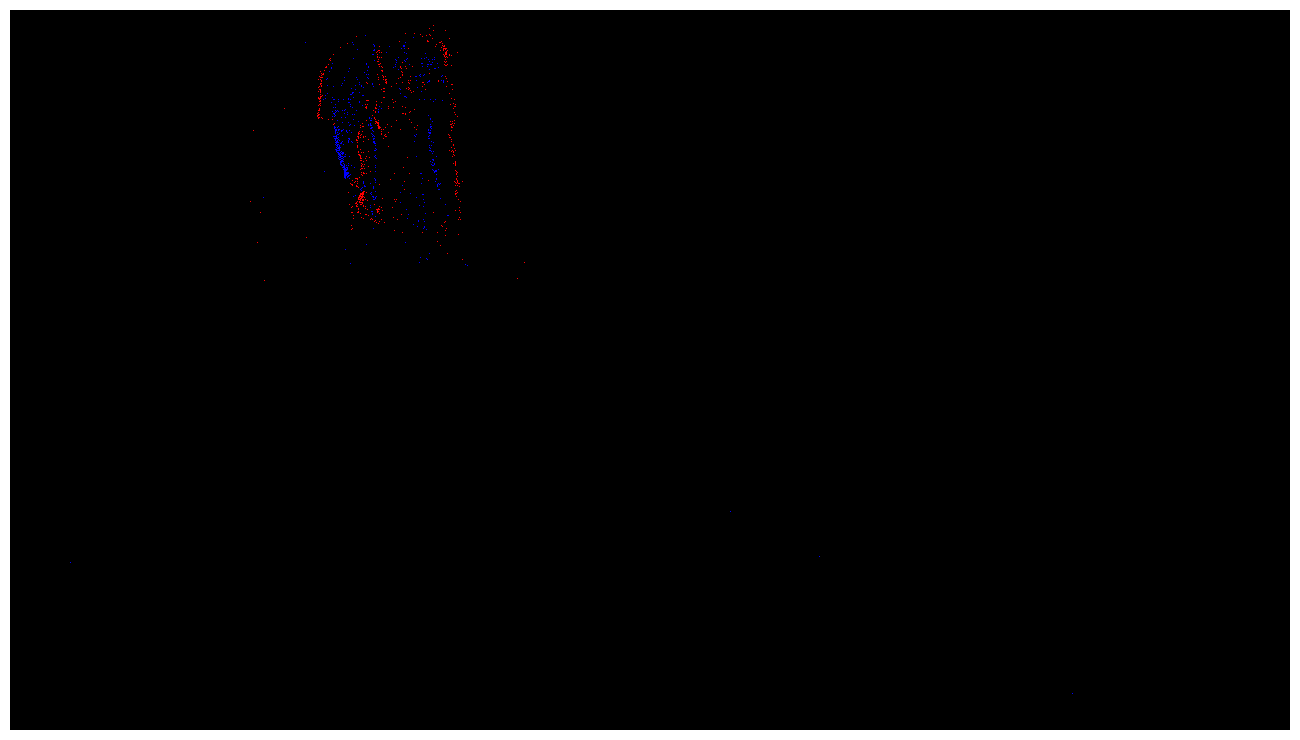

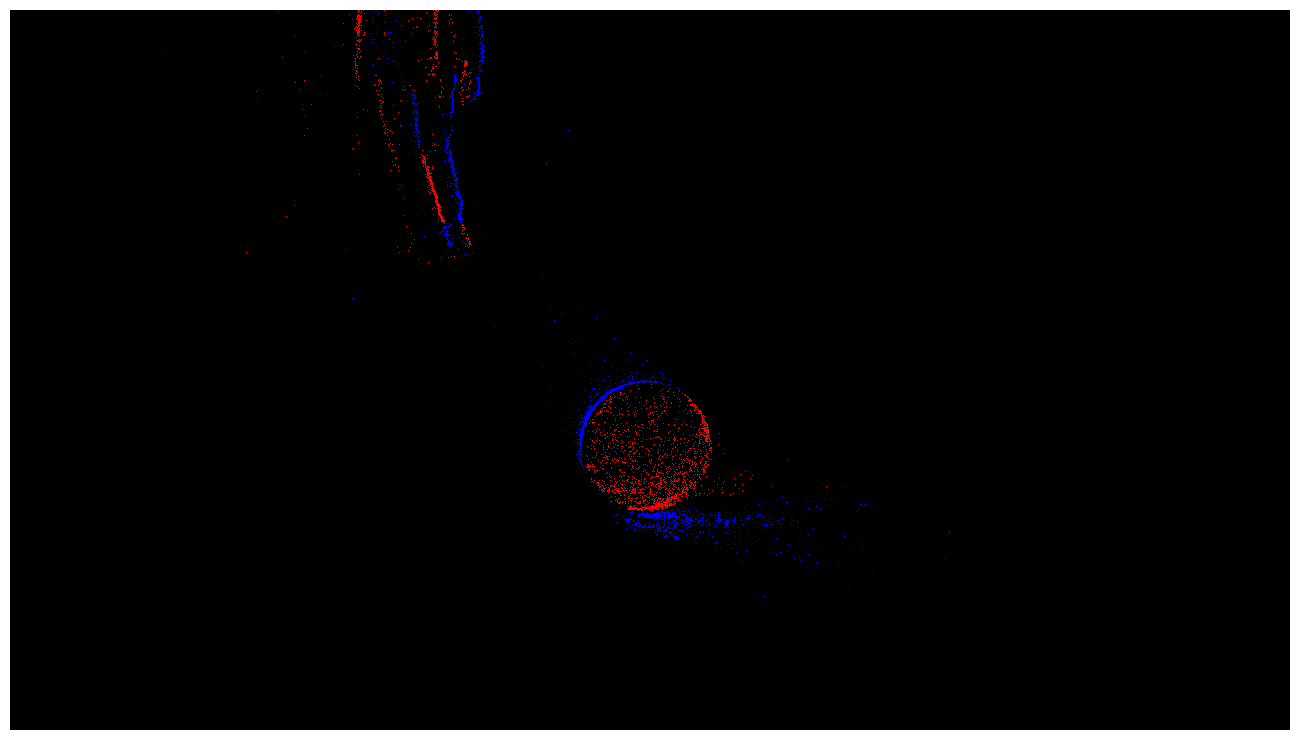

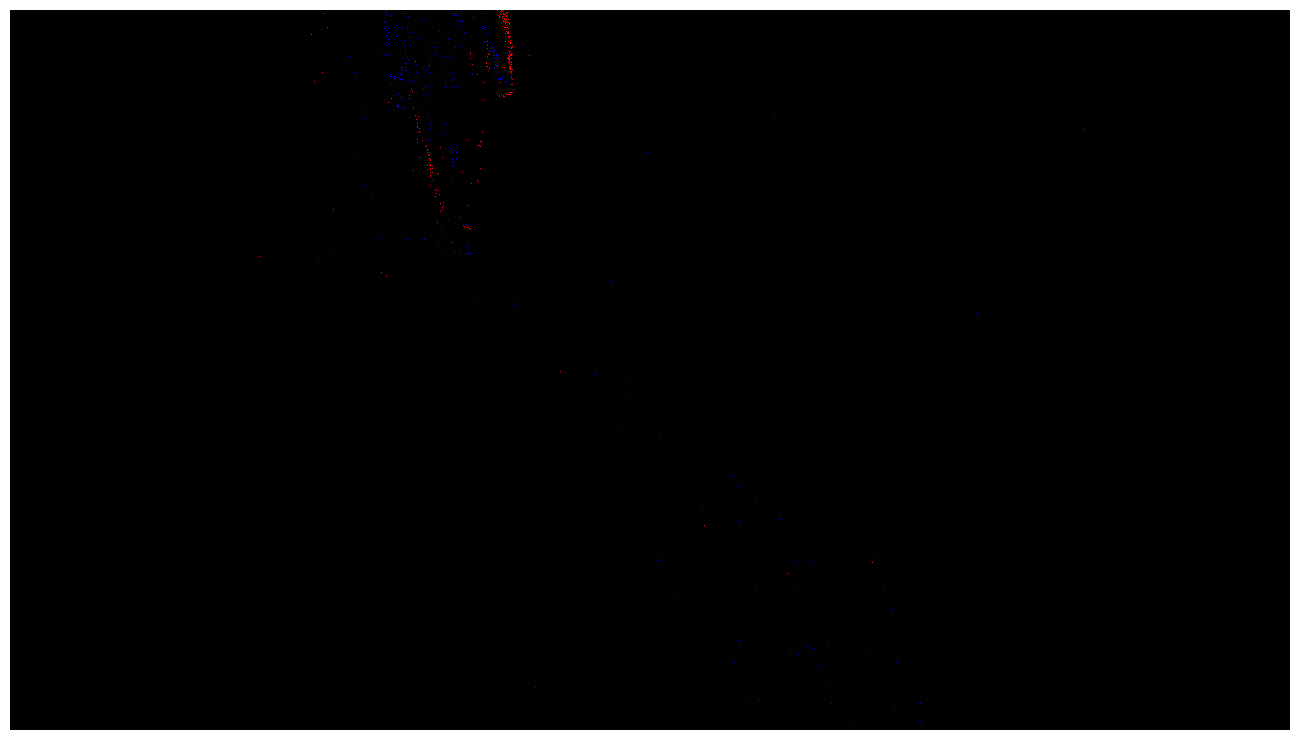

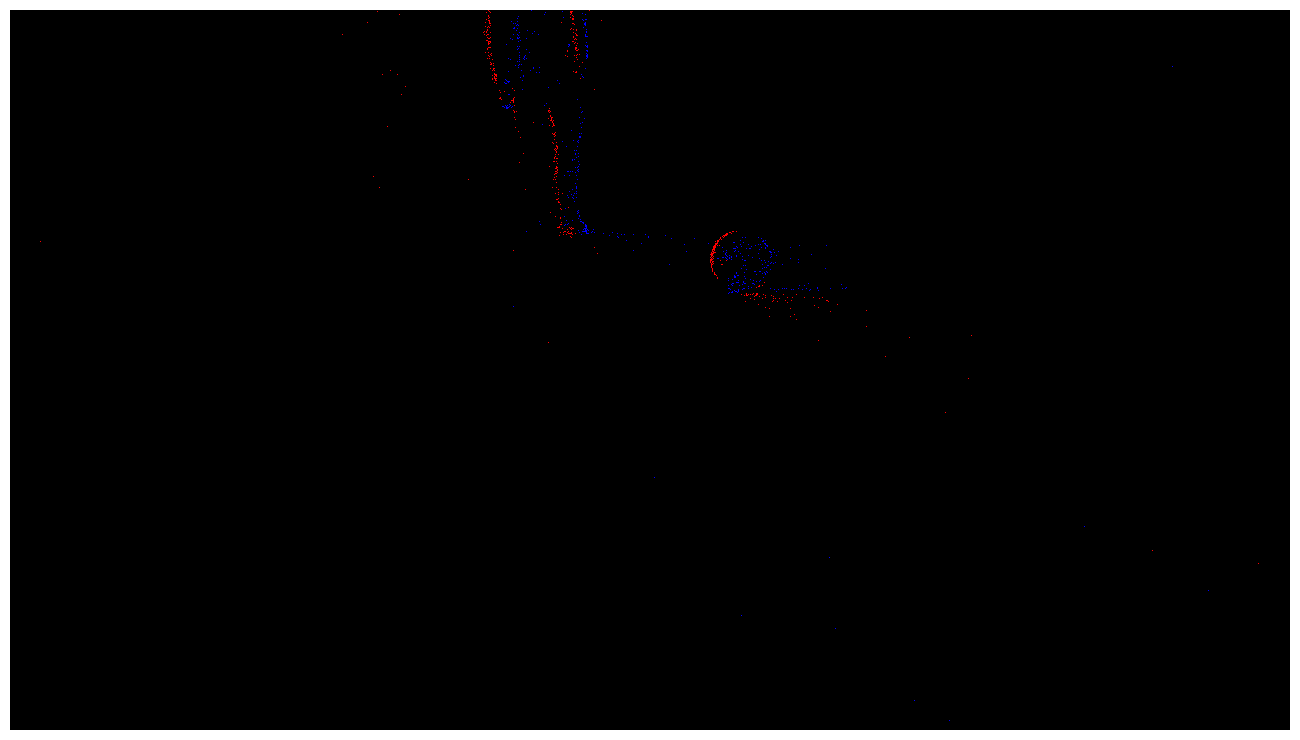

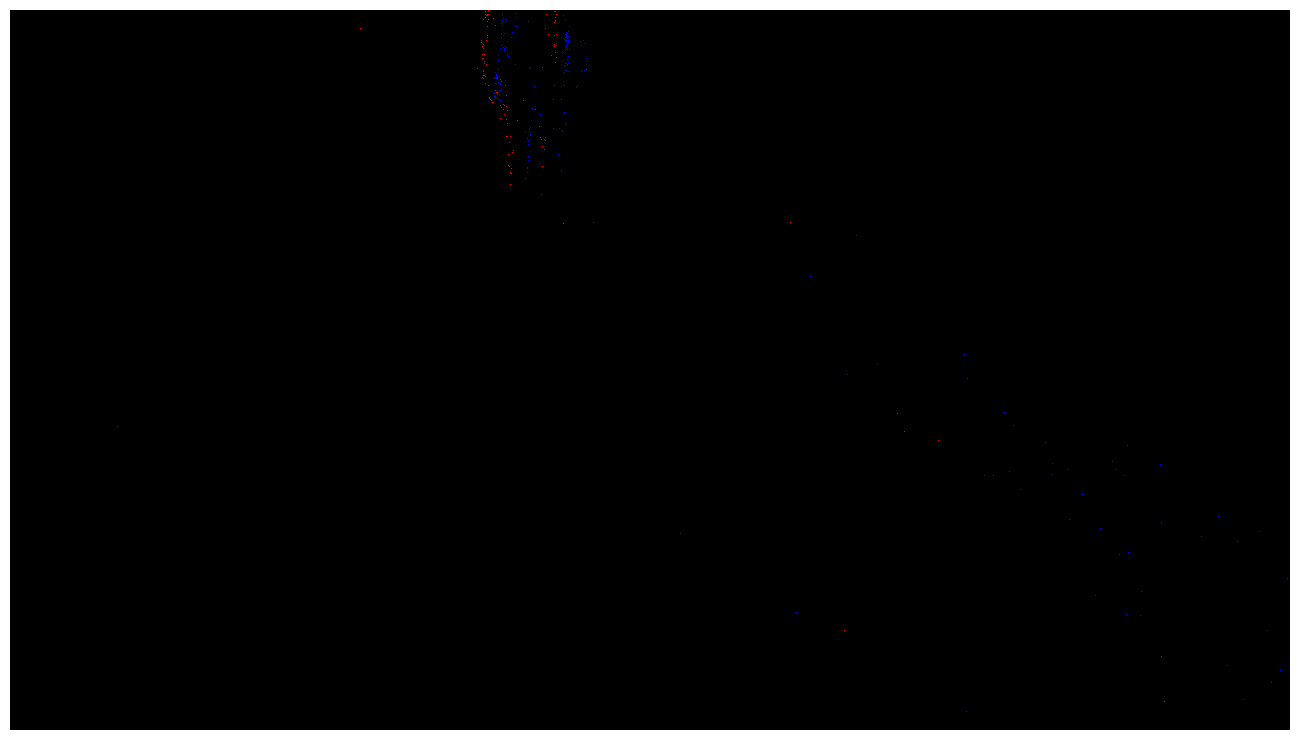

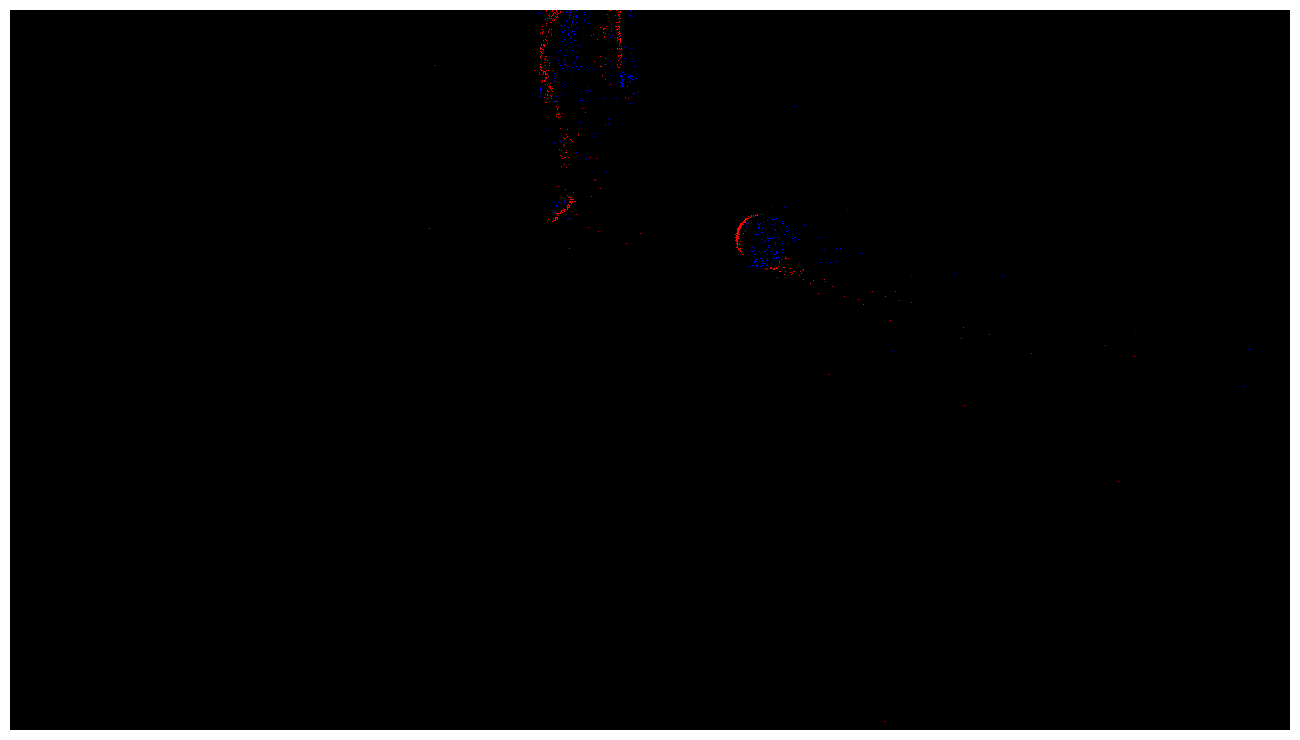

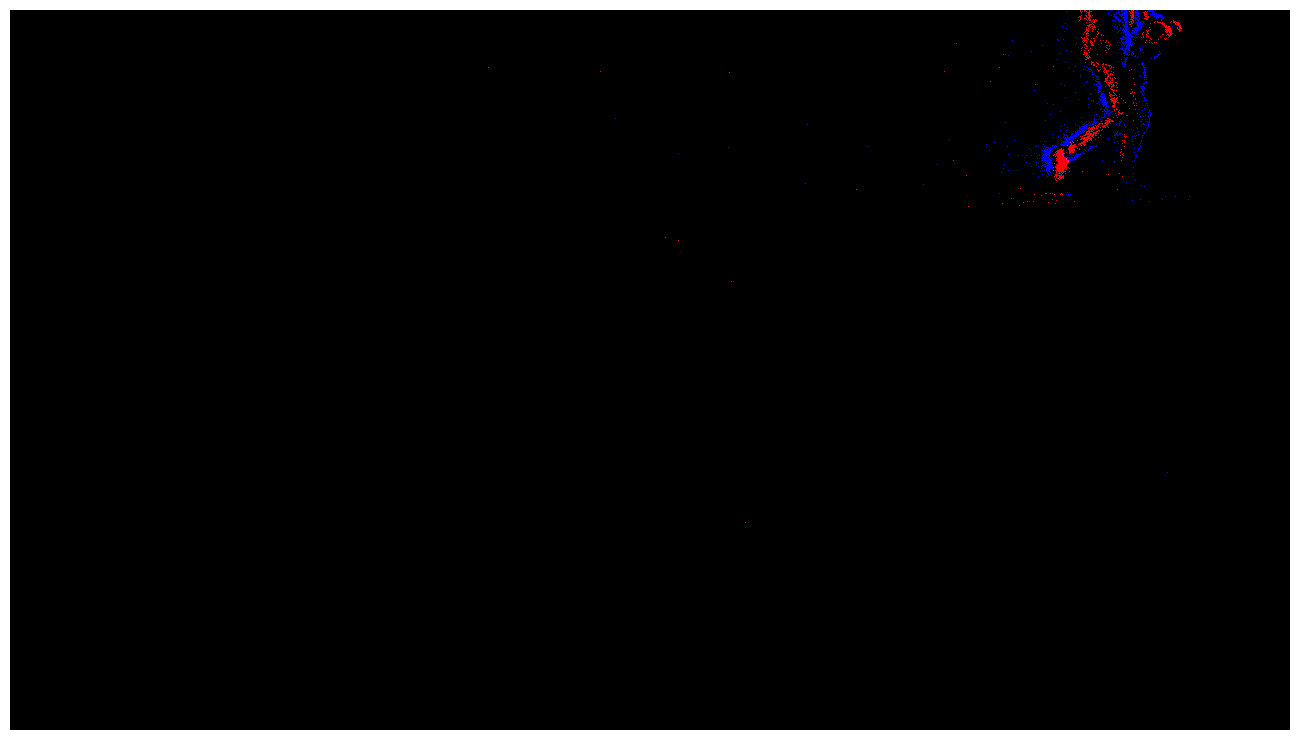

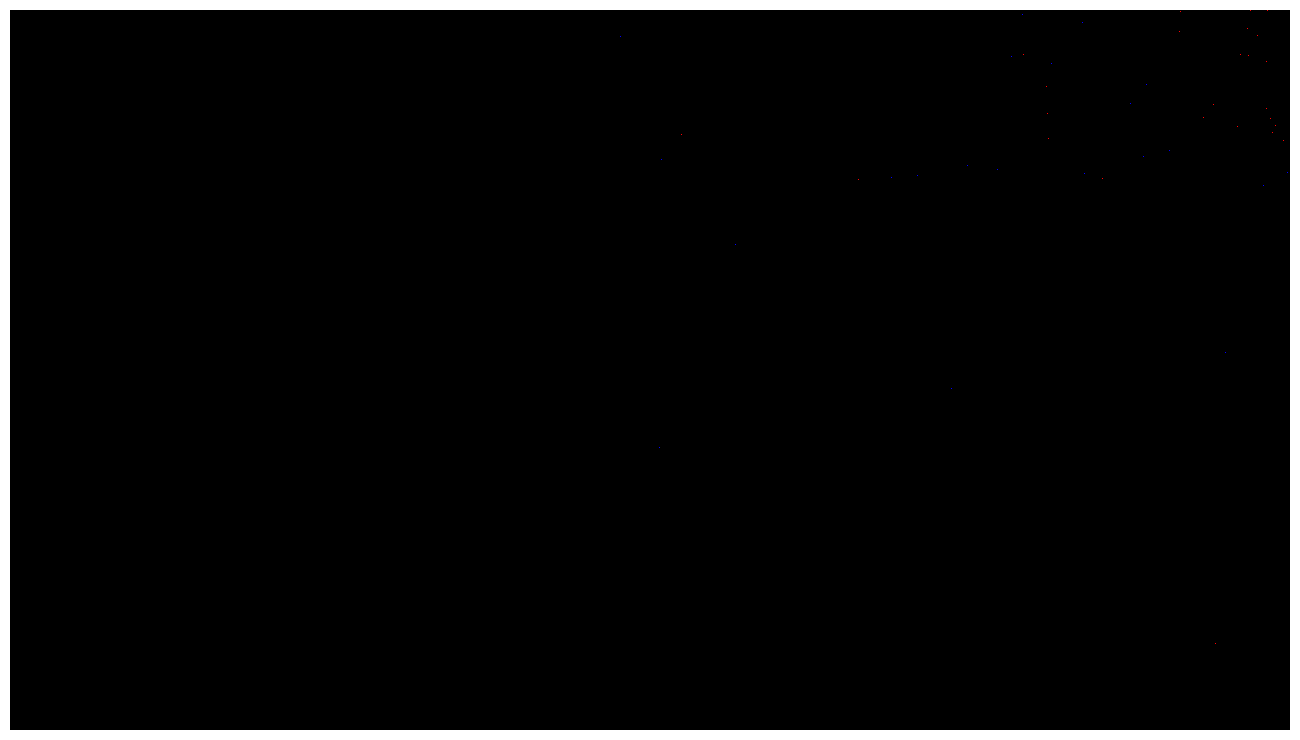

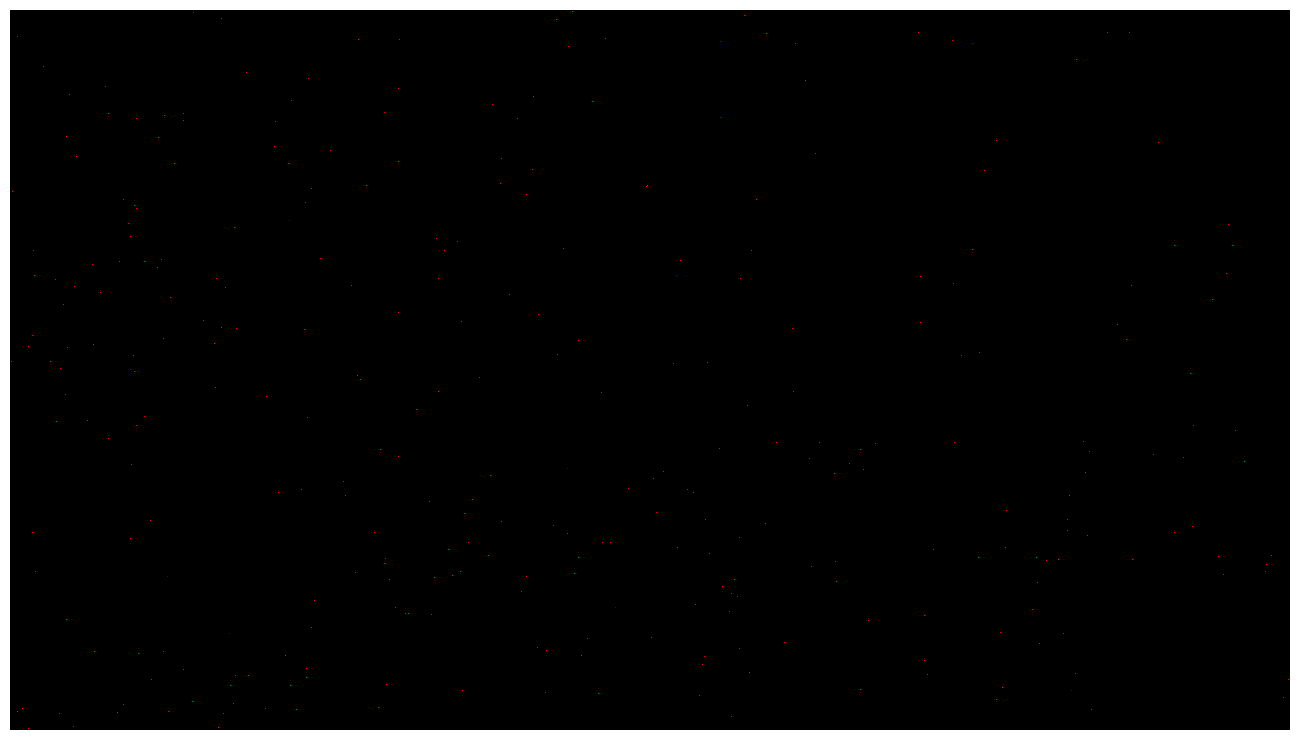

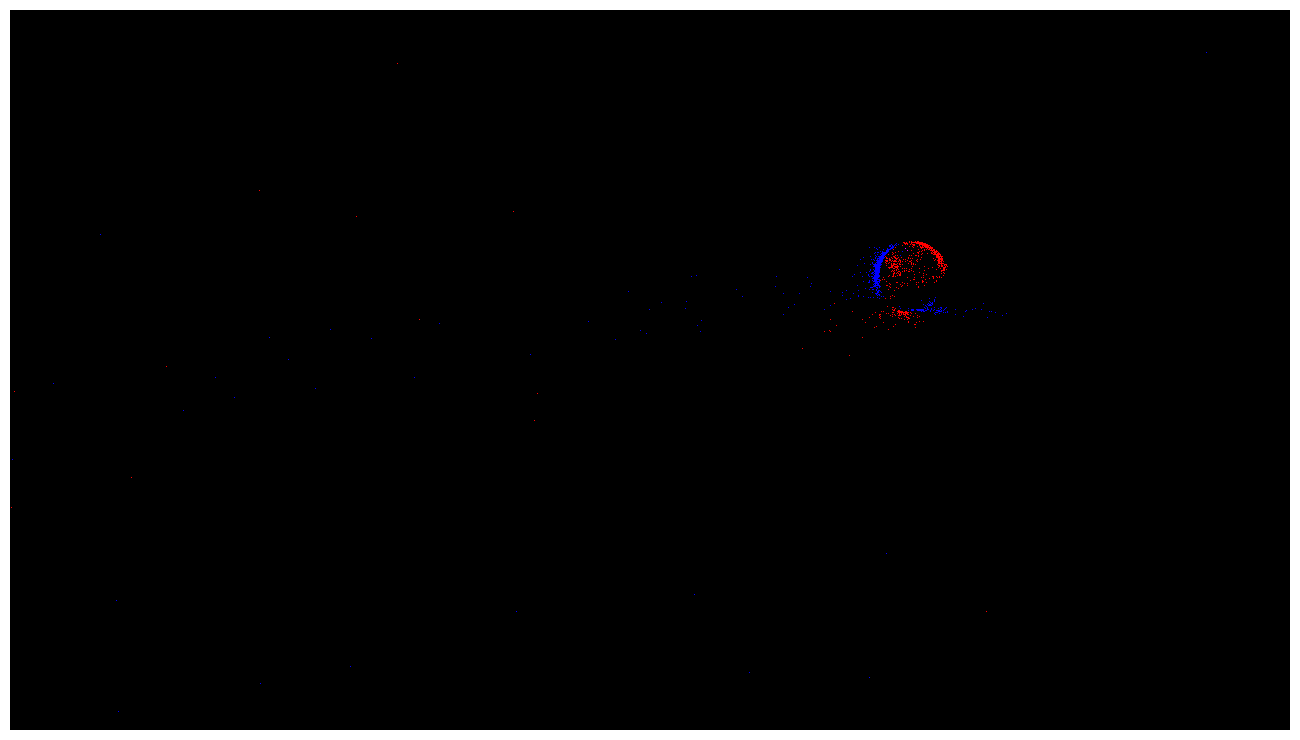

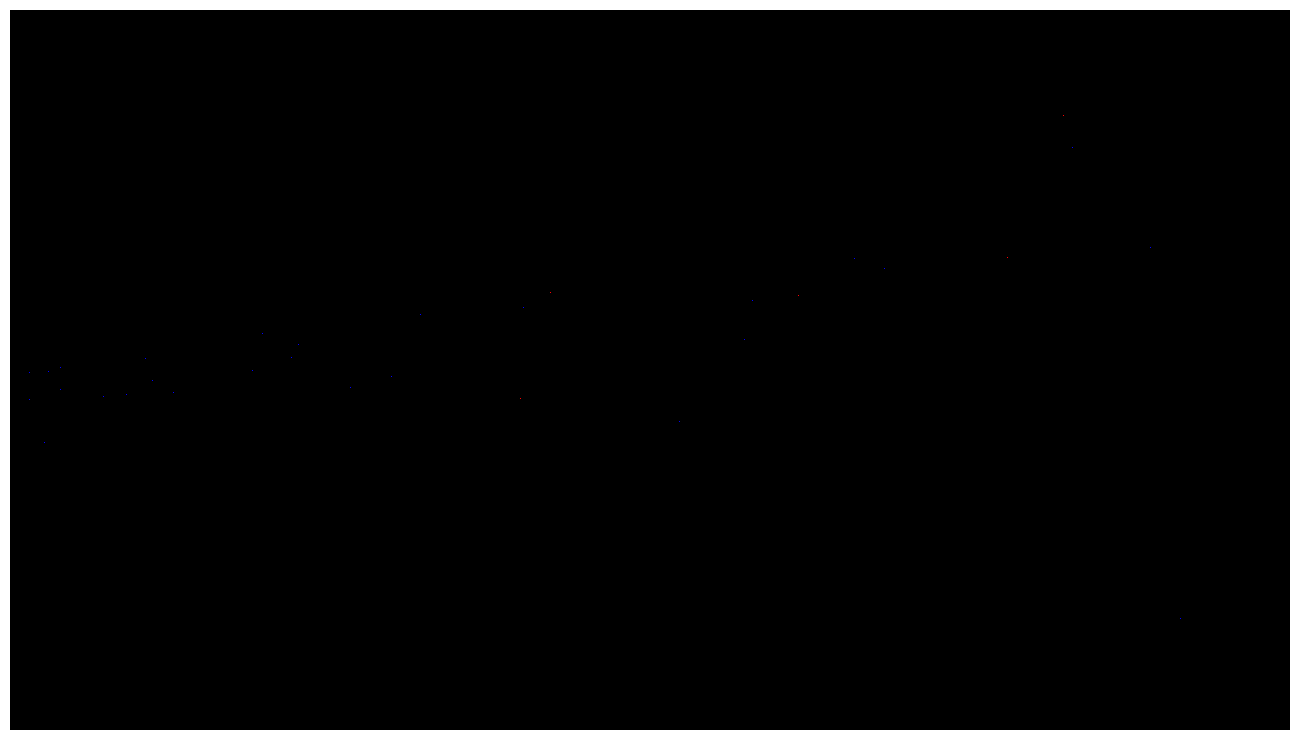

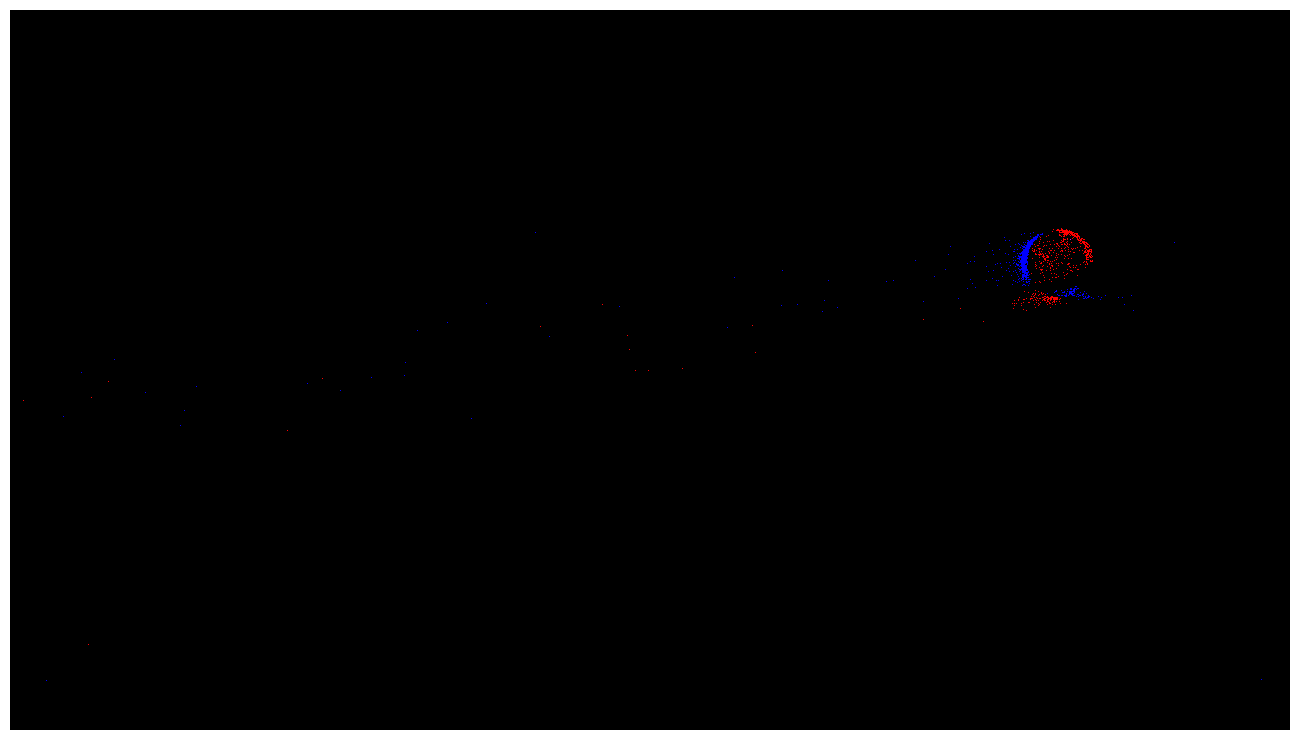

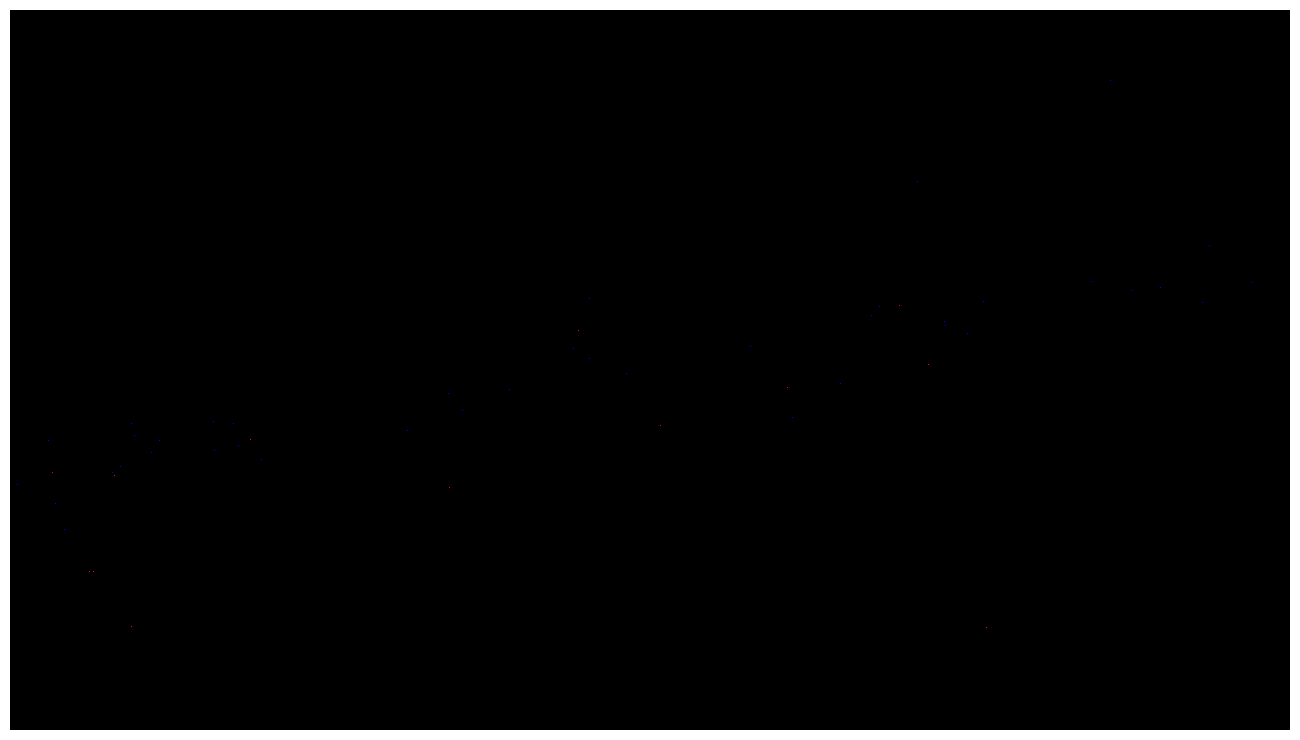

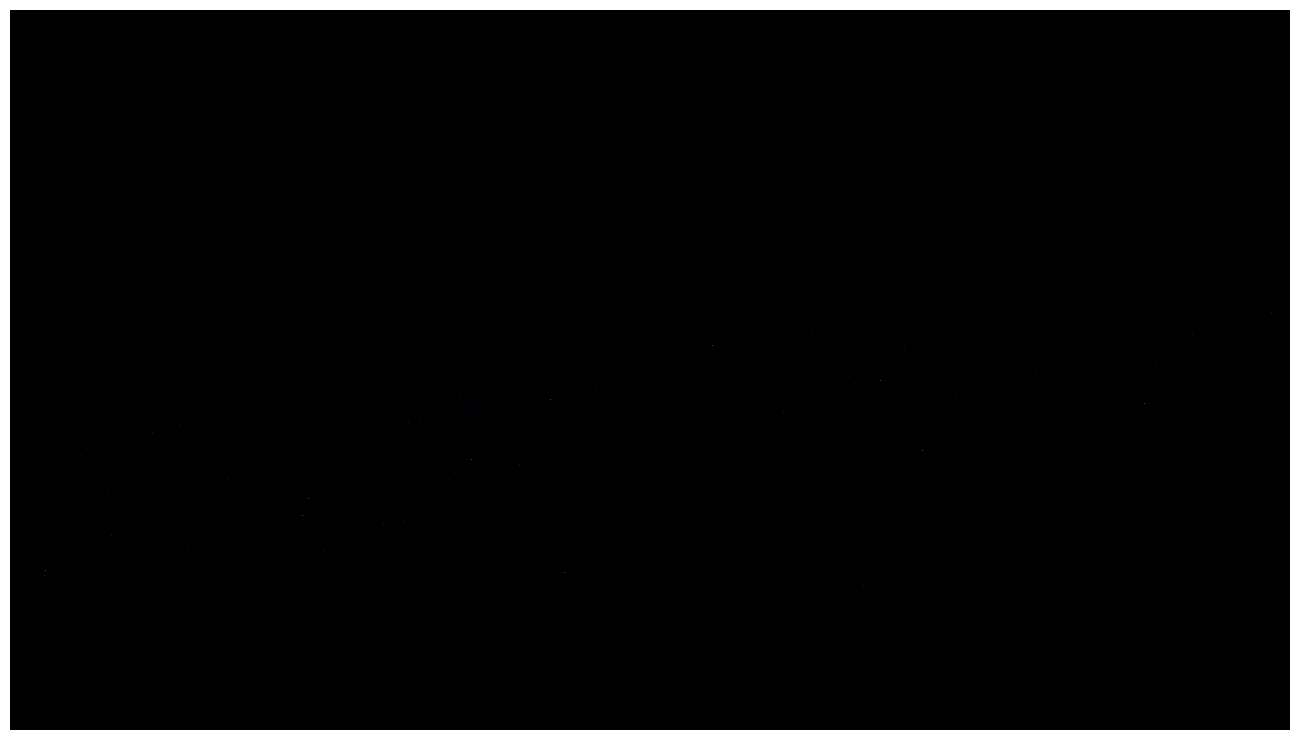

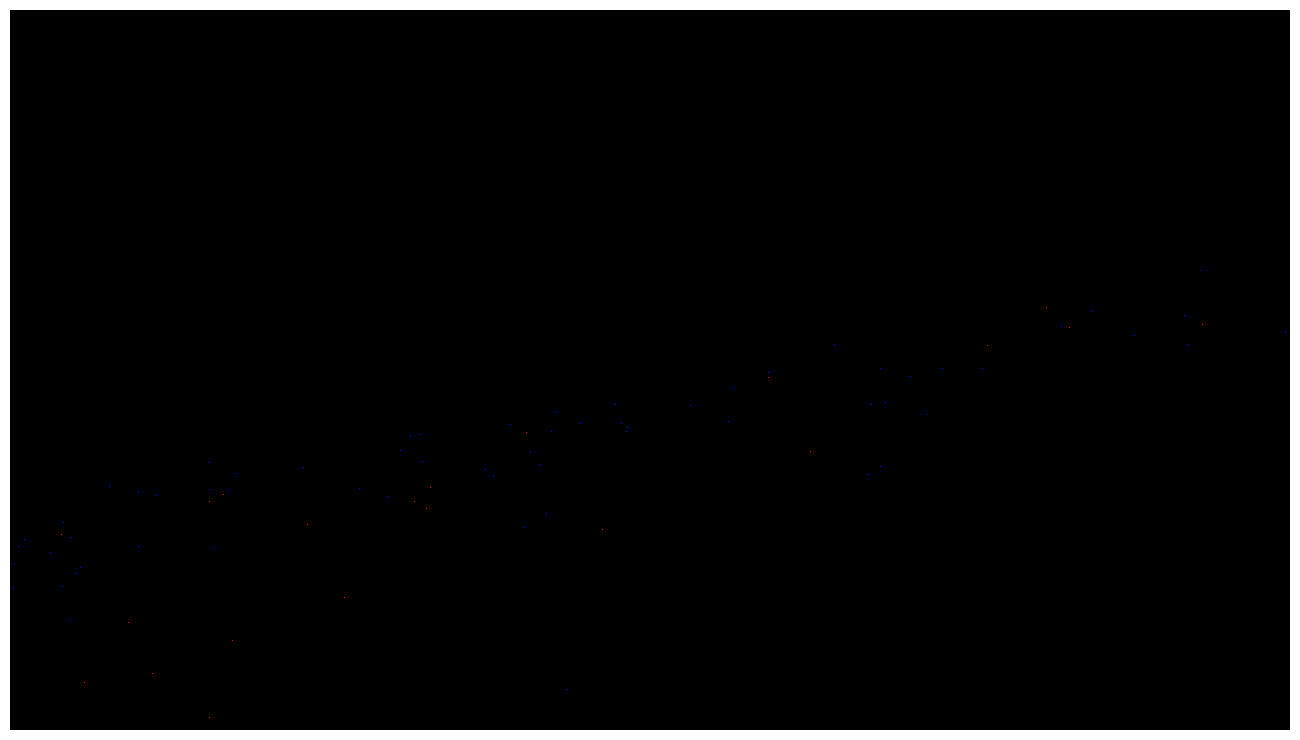

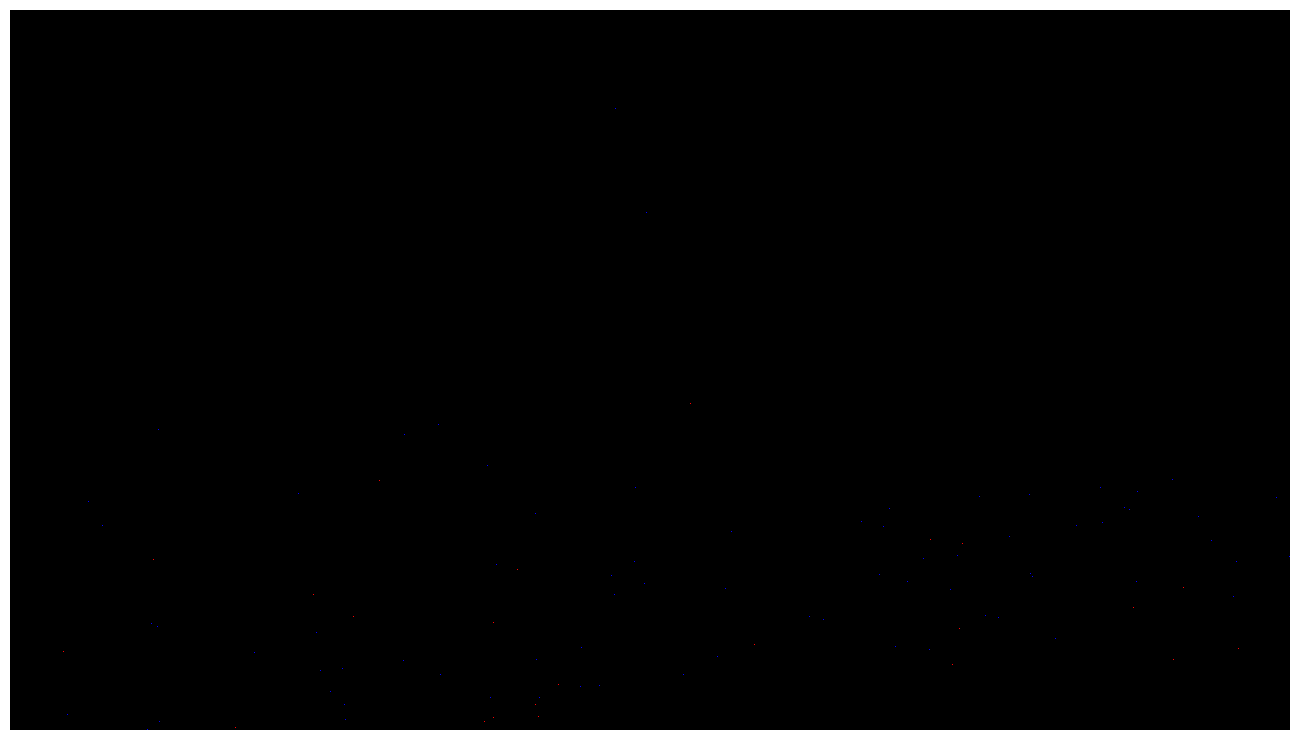

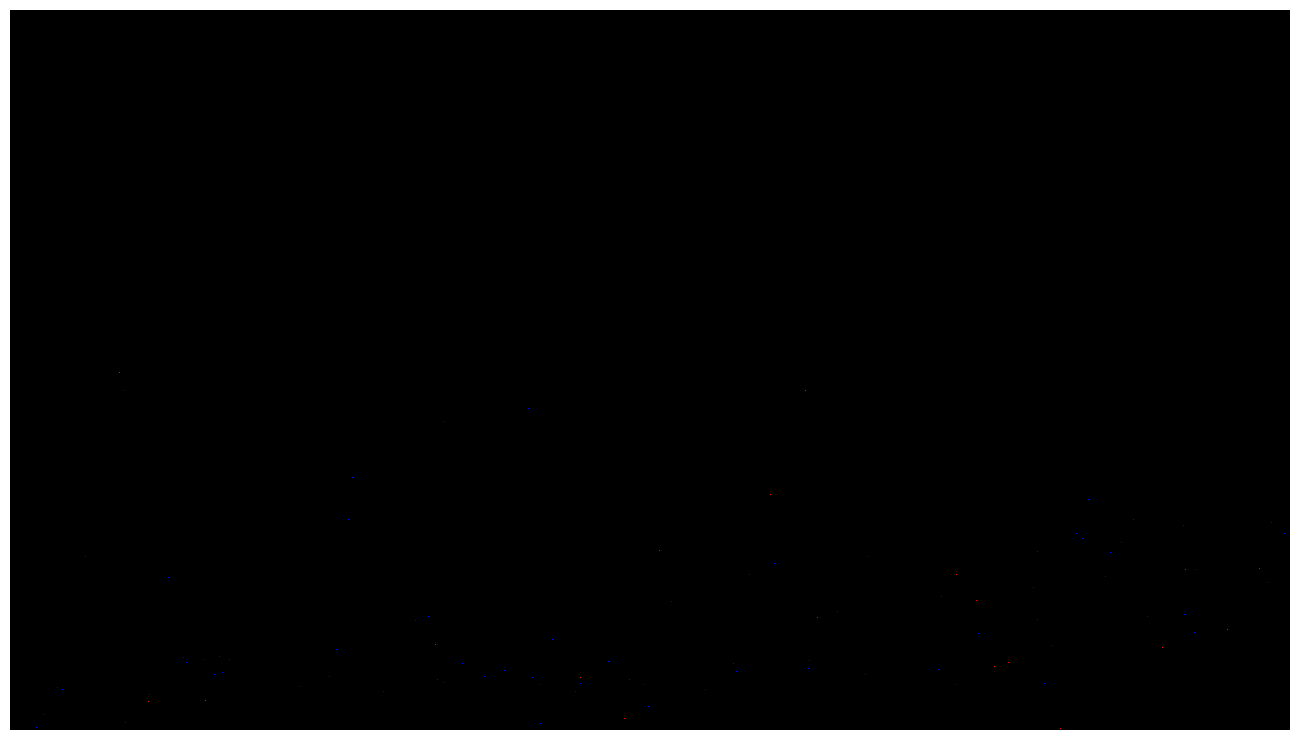

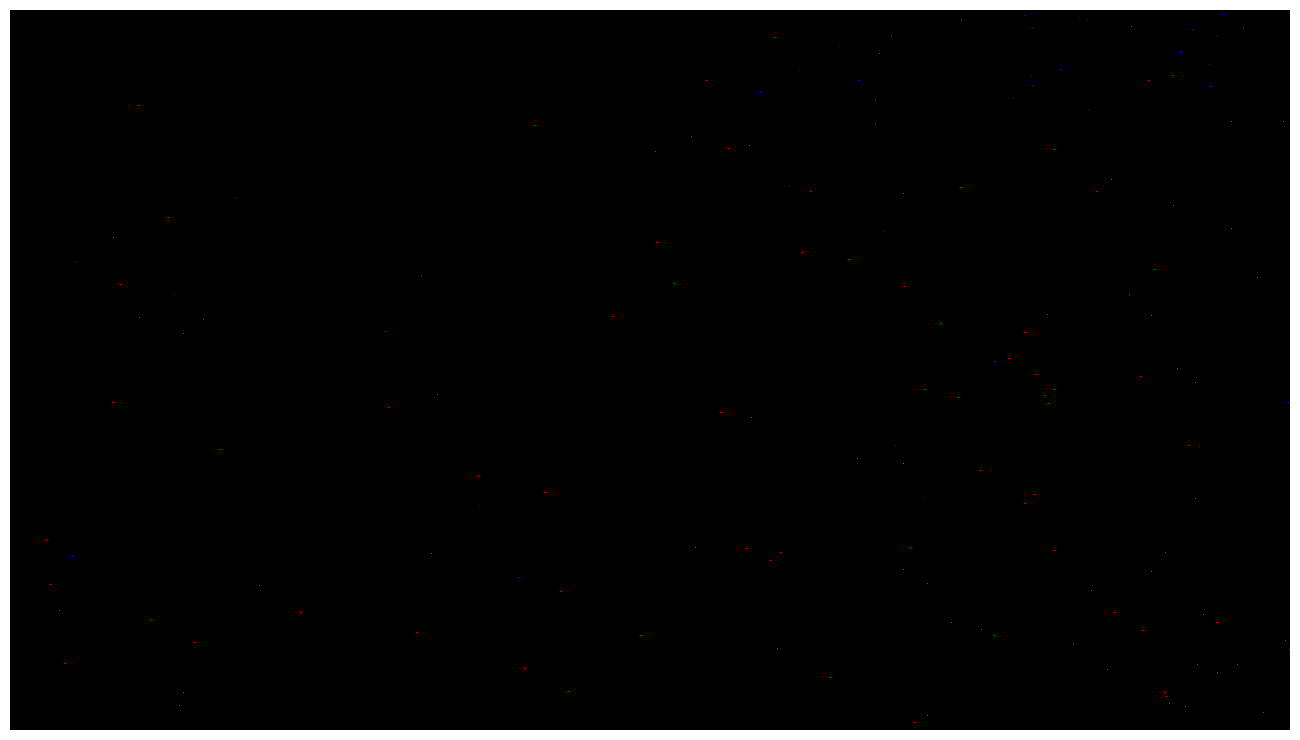

----------------------------------------
Cropping video  Event_camera_data\recording_2025-02-20_13-41-38.raw
Duration: 147.0 s
Average event rate: 383.91
Using threshold: 1919.5690423844756
Found 29 high event intervals
Saved cropped_videos/ev_13-41-38_0.mp4
Saved cropped_videos/ev_13-41-38_1.mp4
Saved cropped_videos/ev_13-41-38_2.mp4
Saved cropped_videos/ev_13-41-38_3.mp4
Saved cropped_videos/ev_13-41-38_4.mp4
Saved cropped_videos/ev_13-41-38_5.mp4
Saved cropped_videos/ev_13-41-38_6.mp4
Saved cropped_videos/ev_13-41-38_7.mp4
Saved cropped_videos/ev_13-41-38_8.mp4
Saved cropped_videos/ev_13-41-38_9.mp4
Saved cropped_videos/ev_13-41-38_10.mp4
Saved cropped_videos/ev_13-41-38_11.mp4
Saved cropped_videos/ev_13-41-38_12.mp4
Saved cropped_videos/ev_13-41-38_13.mp4
Saved cropped_videos/ev_13-41-38_14.mp4
Saved cropped_videos/ev_13-41-38_15.mp4
Saved cropped_videos/ev_13-41-38_16.mp4
Saved cropped_videos/ev_13-41-38_17.mp4
Saved cropped_videos/ev_13-41-38_18.mp4


C:\Users\realenriquem\AppData\Local\Temp\ipykernel_21452\3378476678.py:85: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(width / 100, height / 100), dpi=100)


Saved cropped_videos/ev_13-41-38_19.mp4
Saved cropped_videos/ev_13-41-38_20.mp4
Saved cropped_videos/ev_13-41-38_21.mp4
Saved cropped_videos/ev_13-41-38_22.mp4
Saved cropped_videos/ev_13-41-38_23.mp4
Saved cropped_videos/ev_13-41-38_24.mp4
Saved cropped_videos/ev_13-41-38_25.mp4
Saved cropped_videos/ev_13-41-38_26.mp4
Saved cropped_videos/ev_13-41-38_27.mp4
Saved cropped_videos/ev_13-41-38_28.mp4


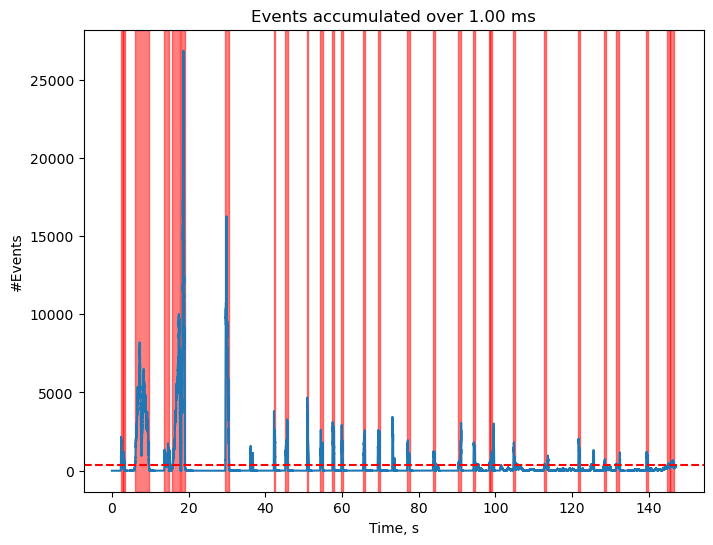

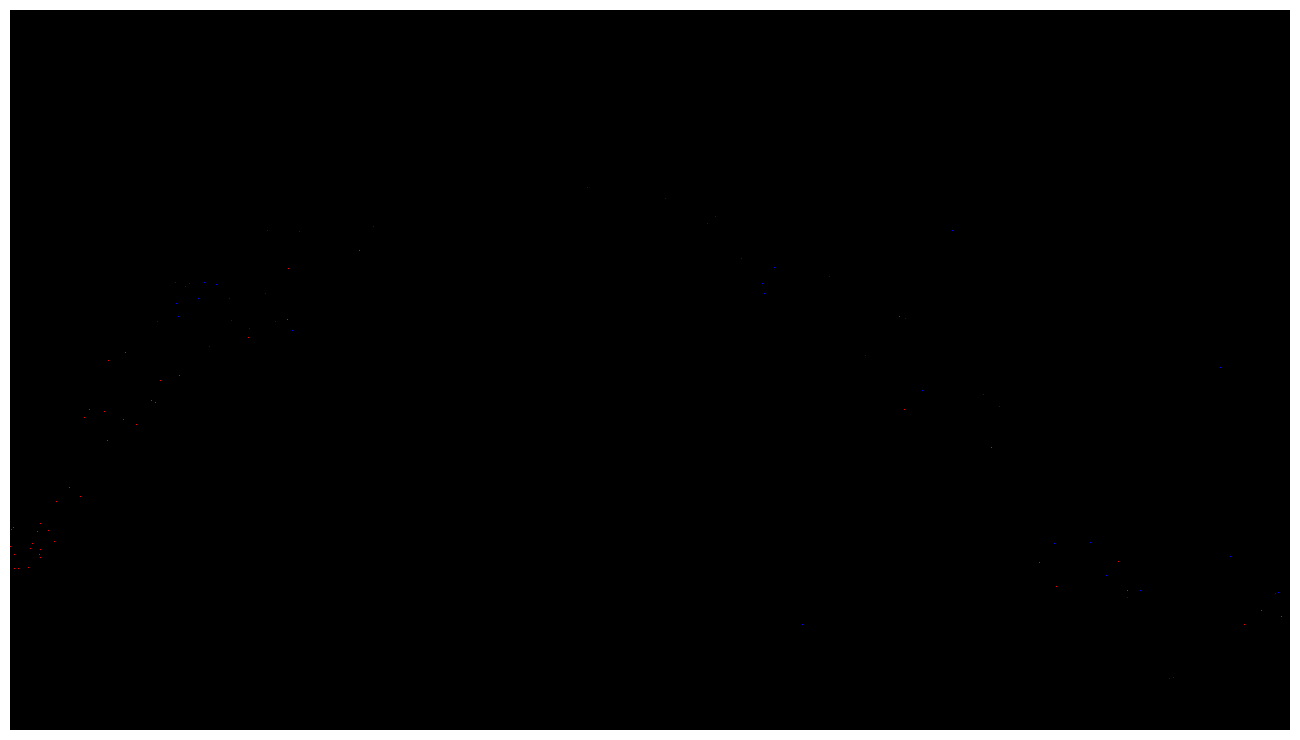

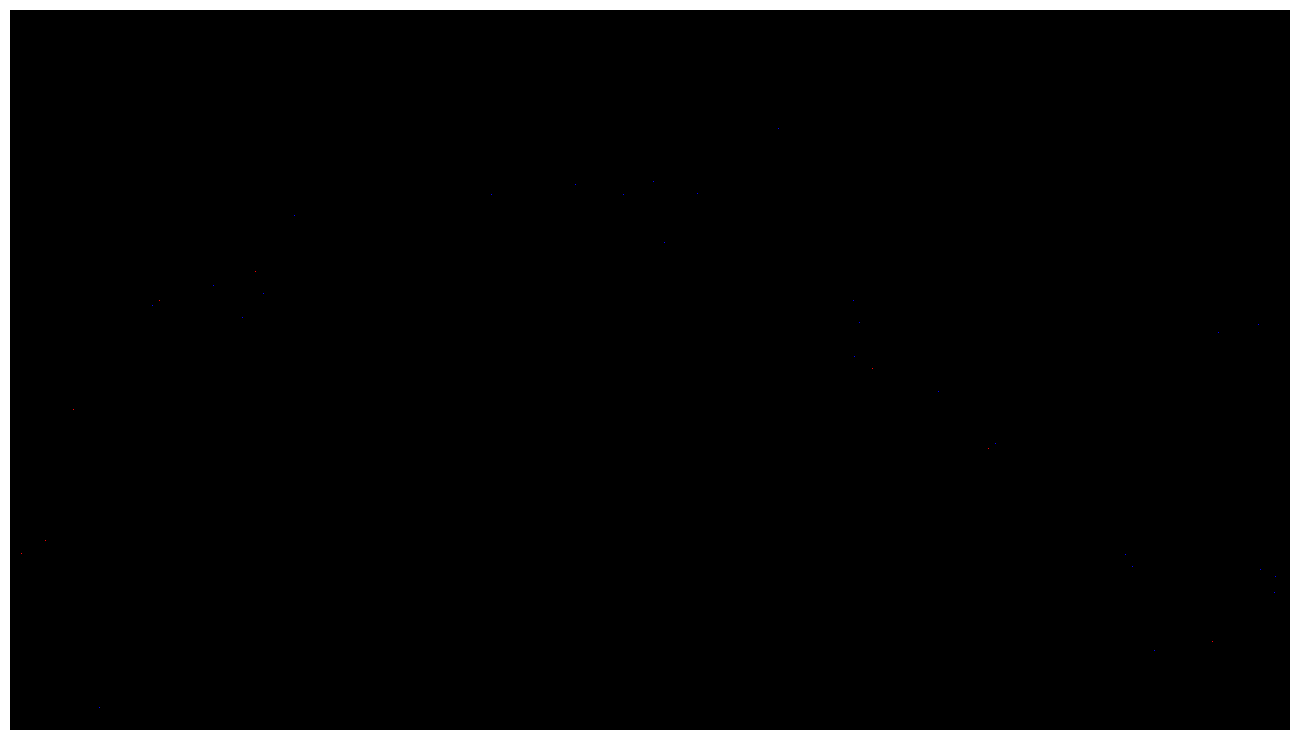

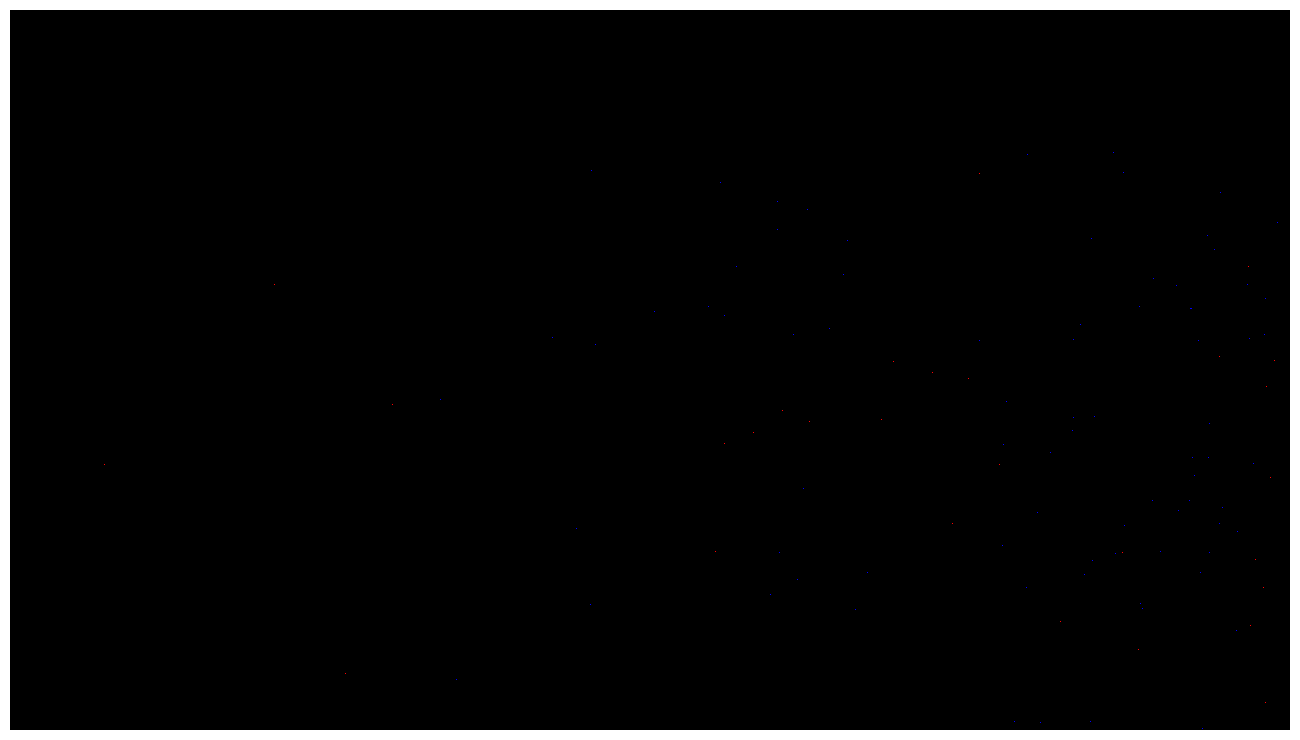

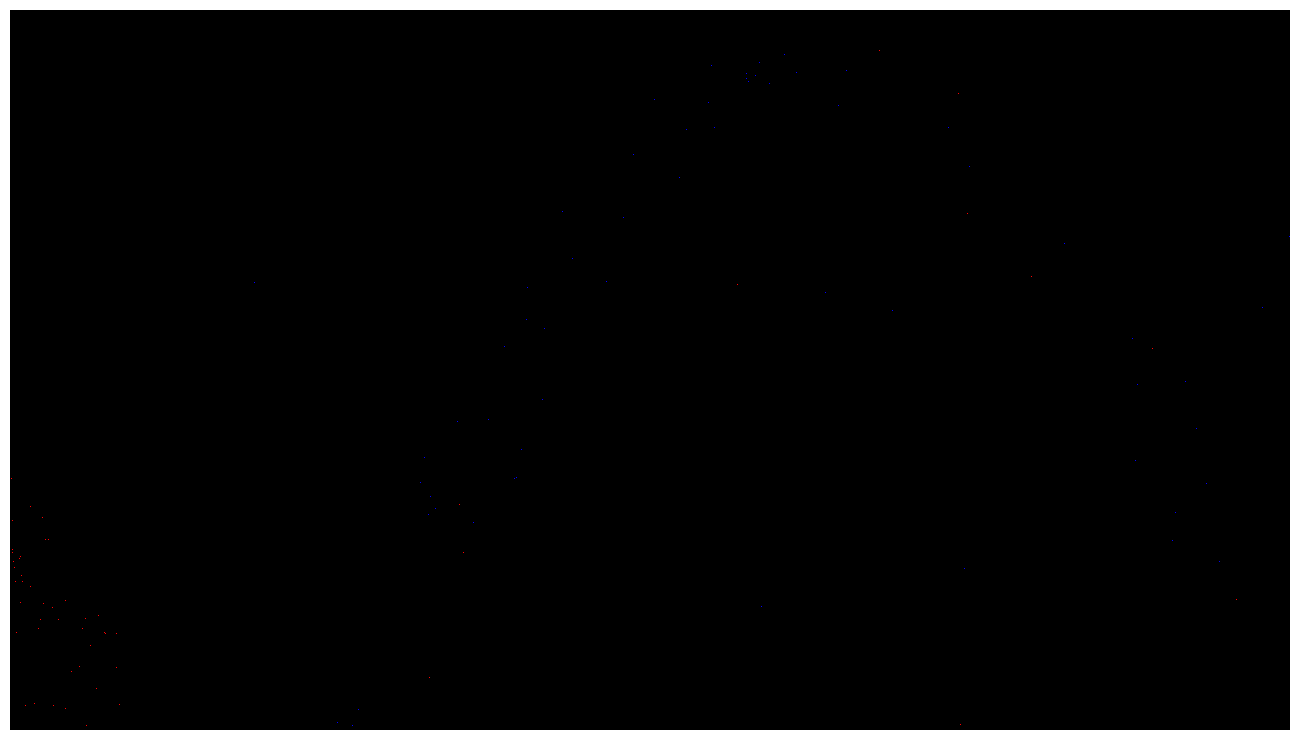

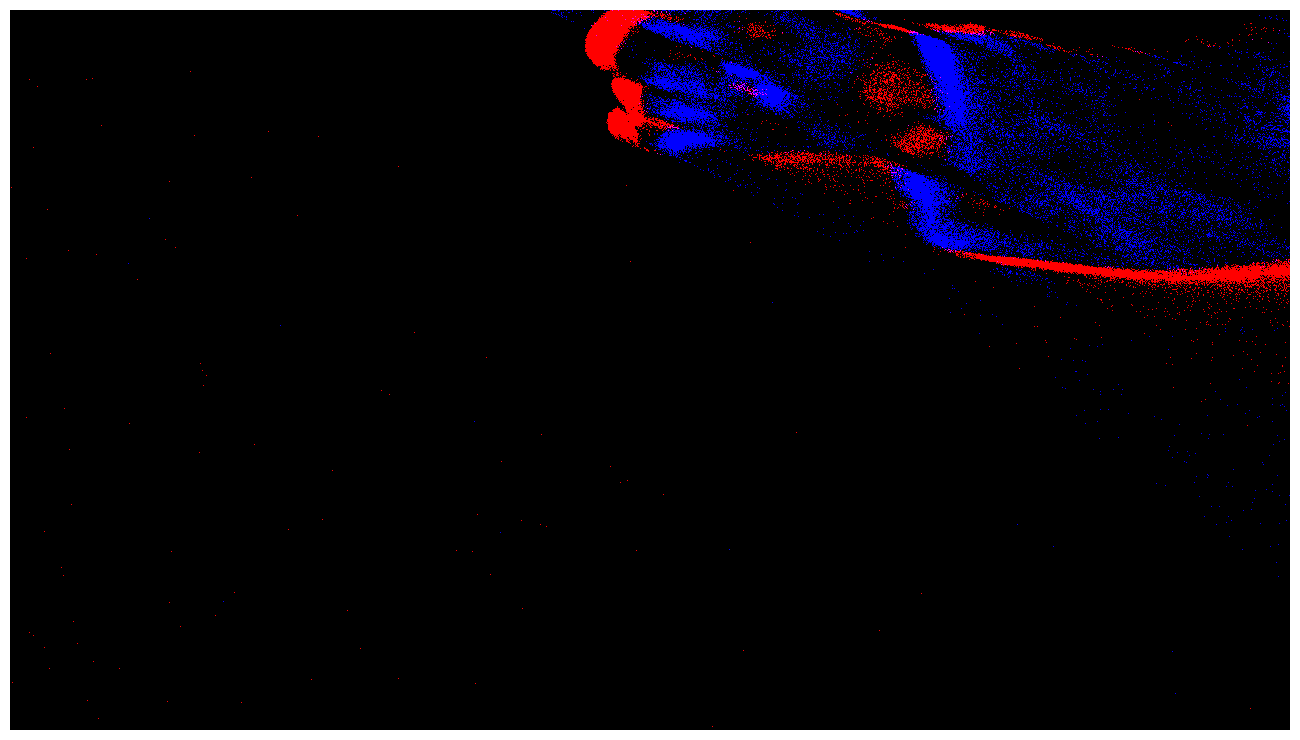

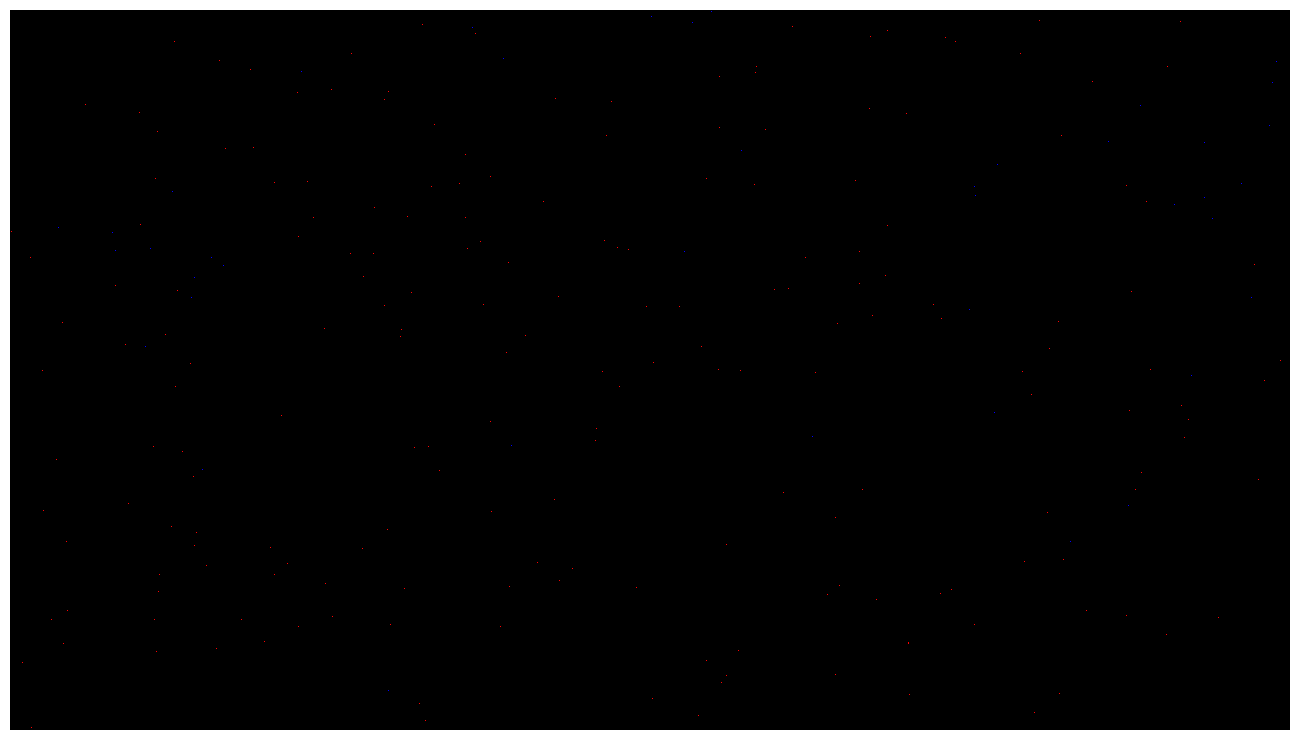

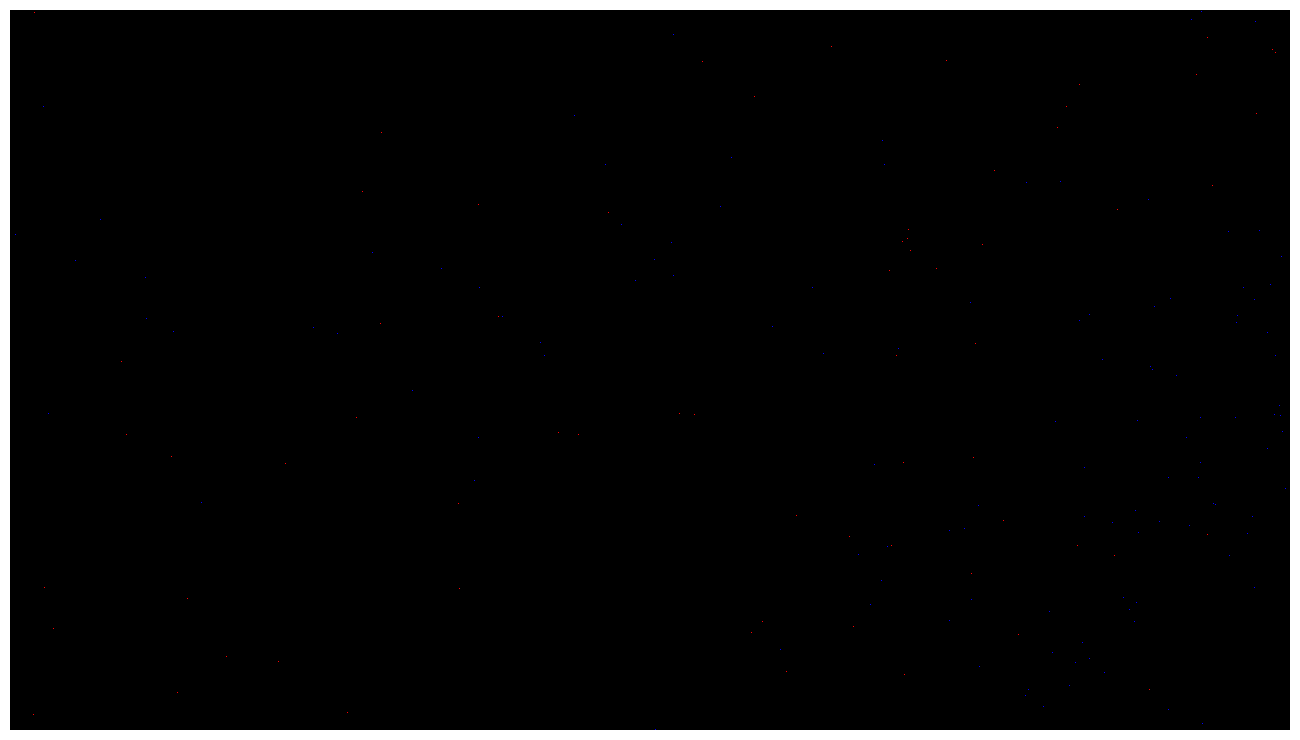

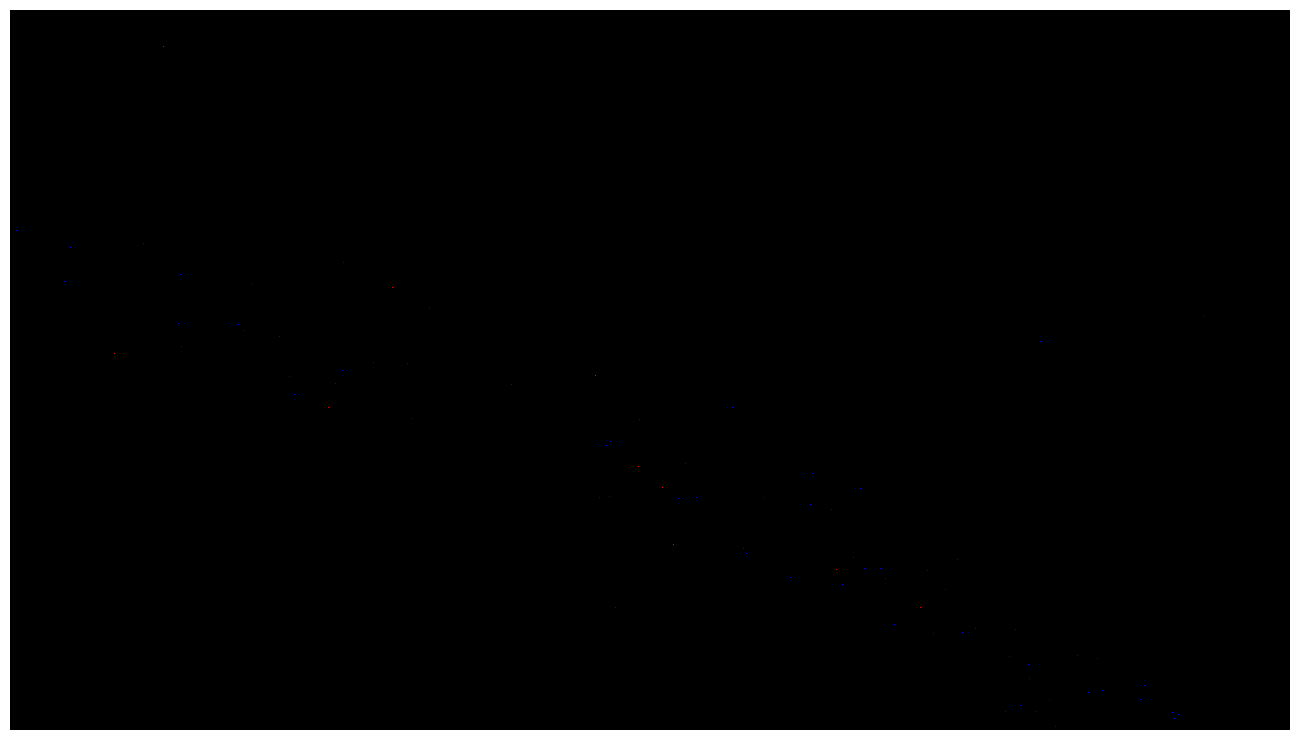

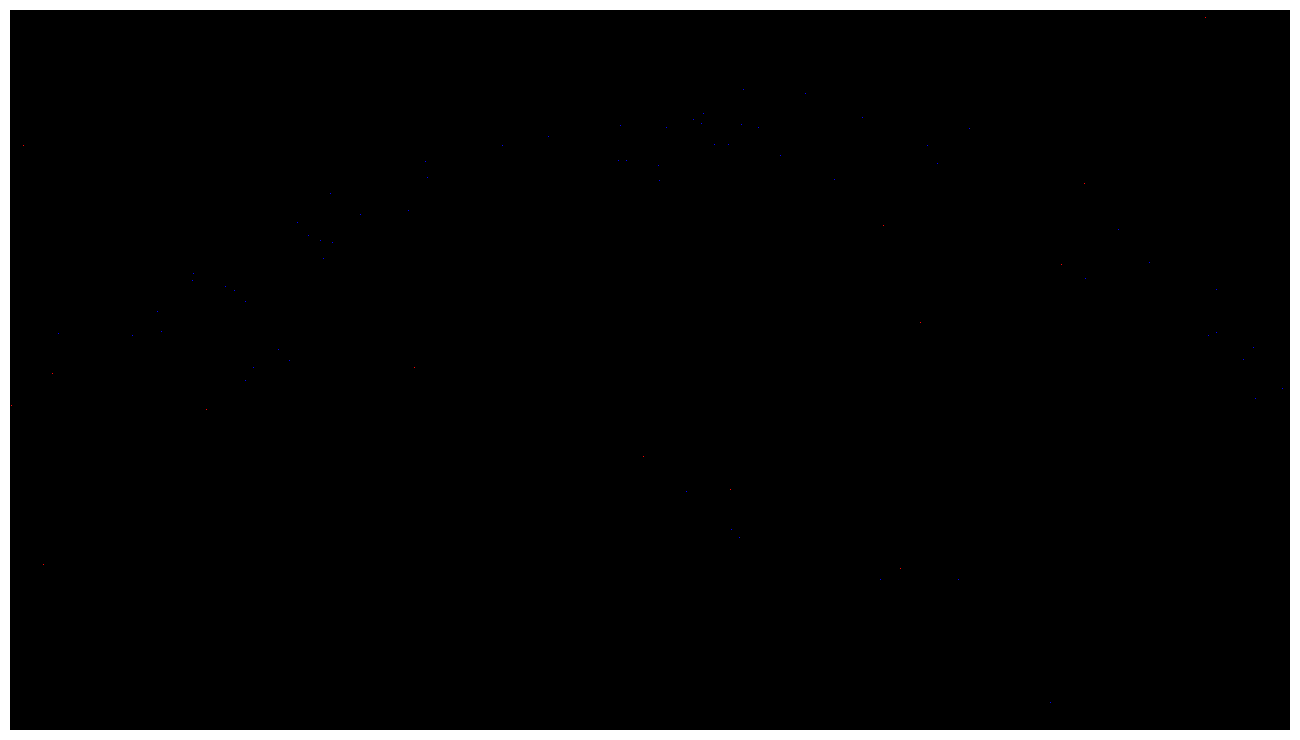

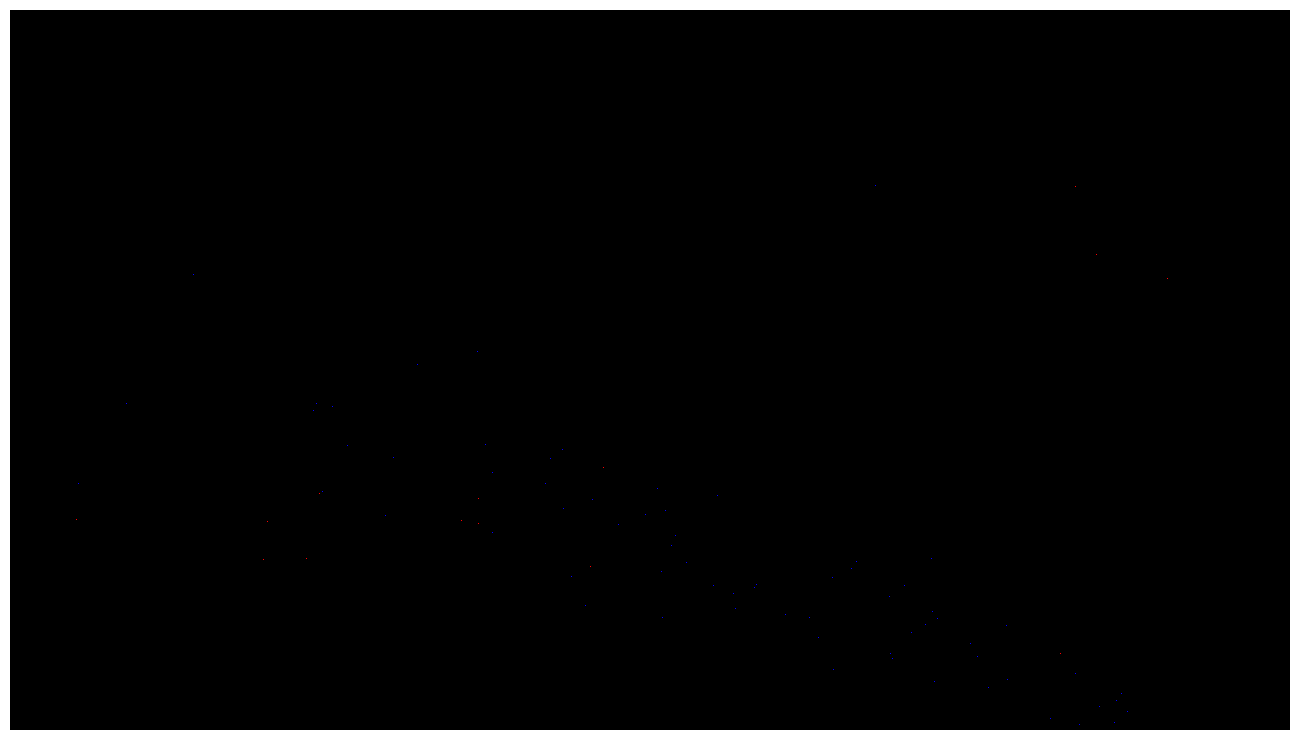

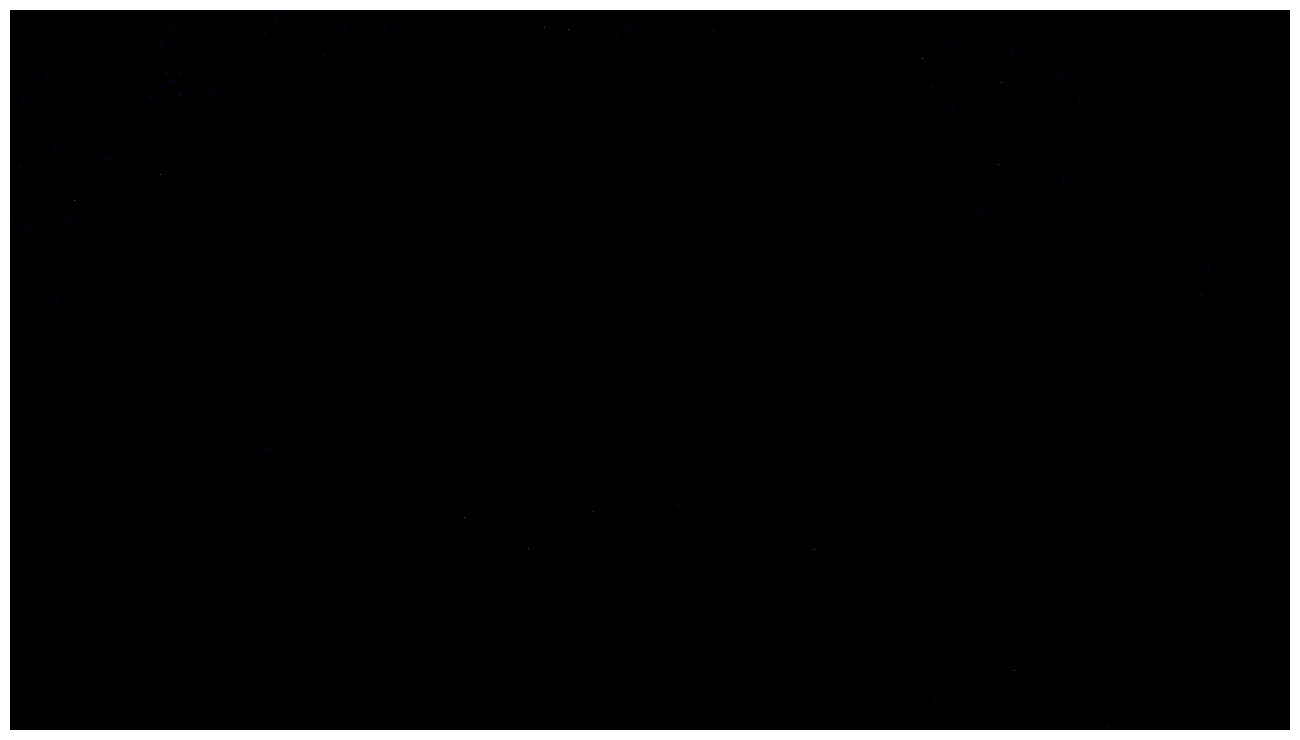

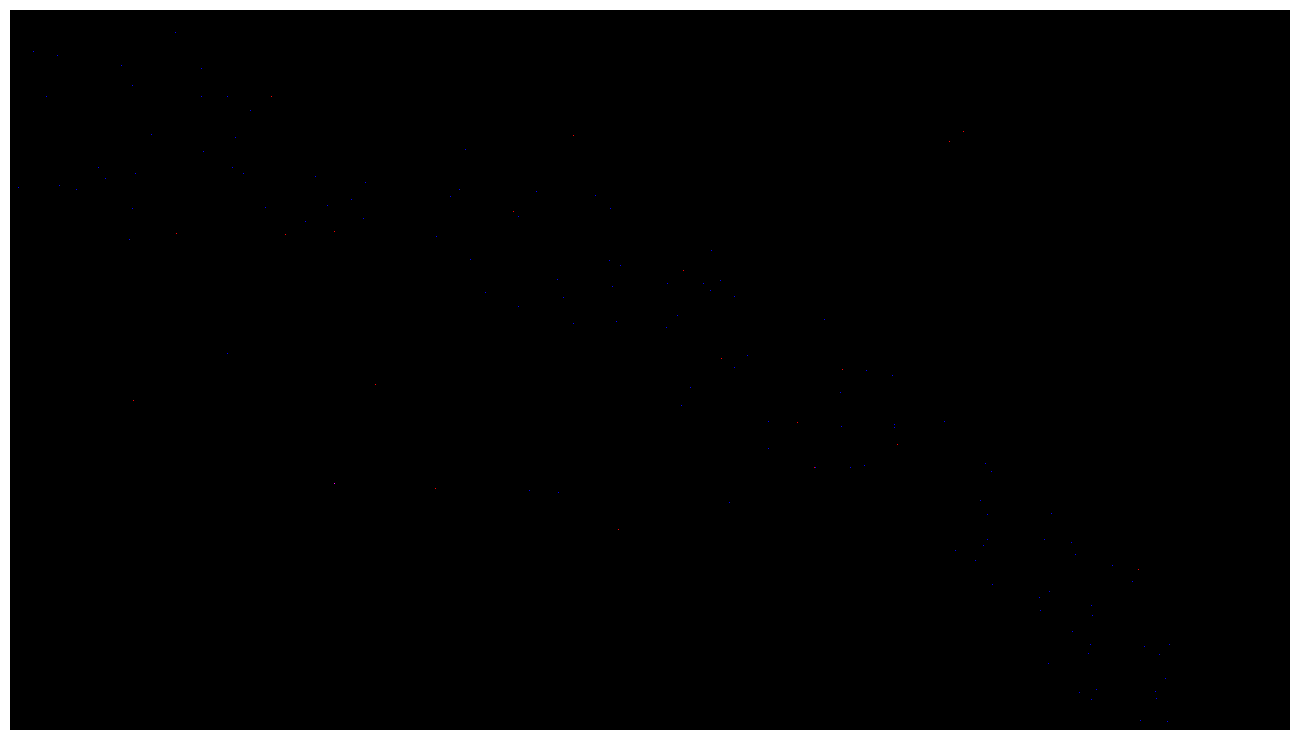

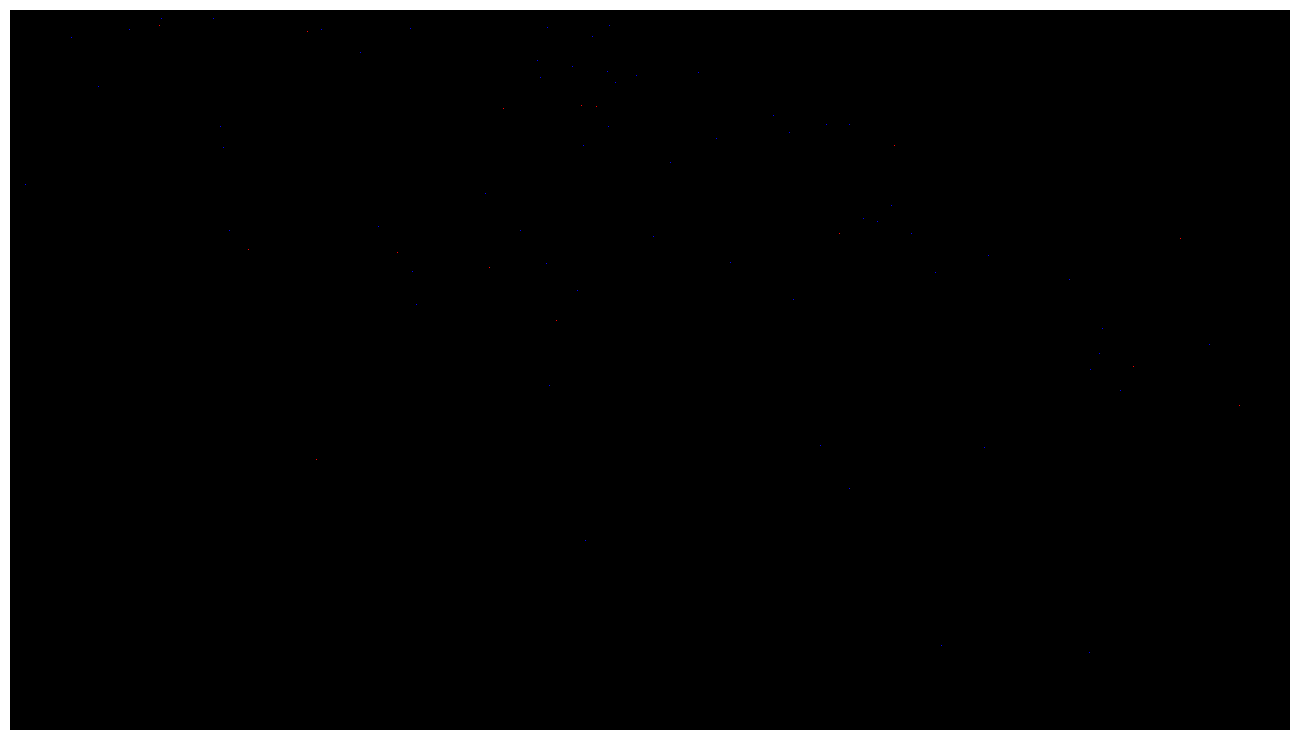

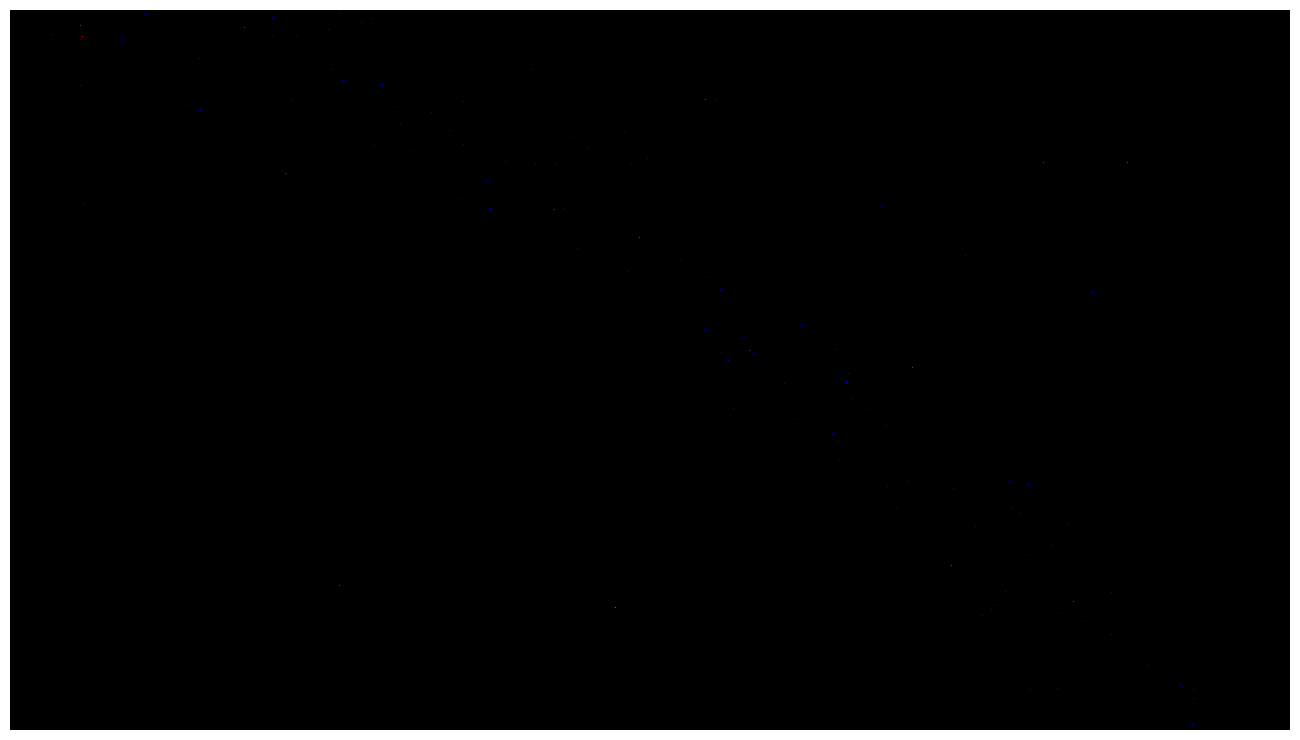

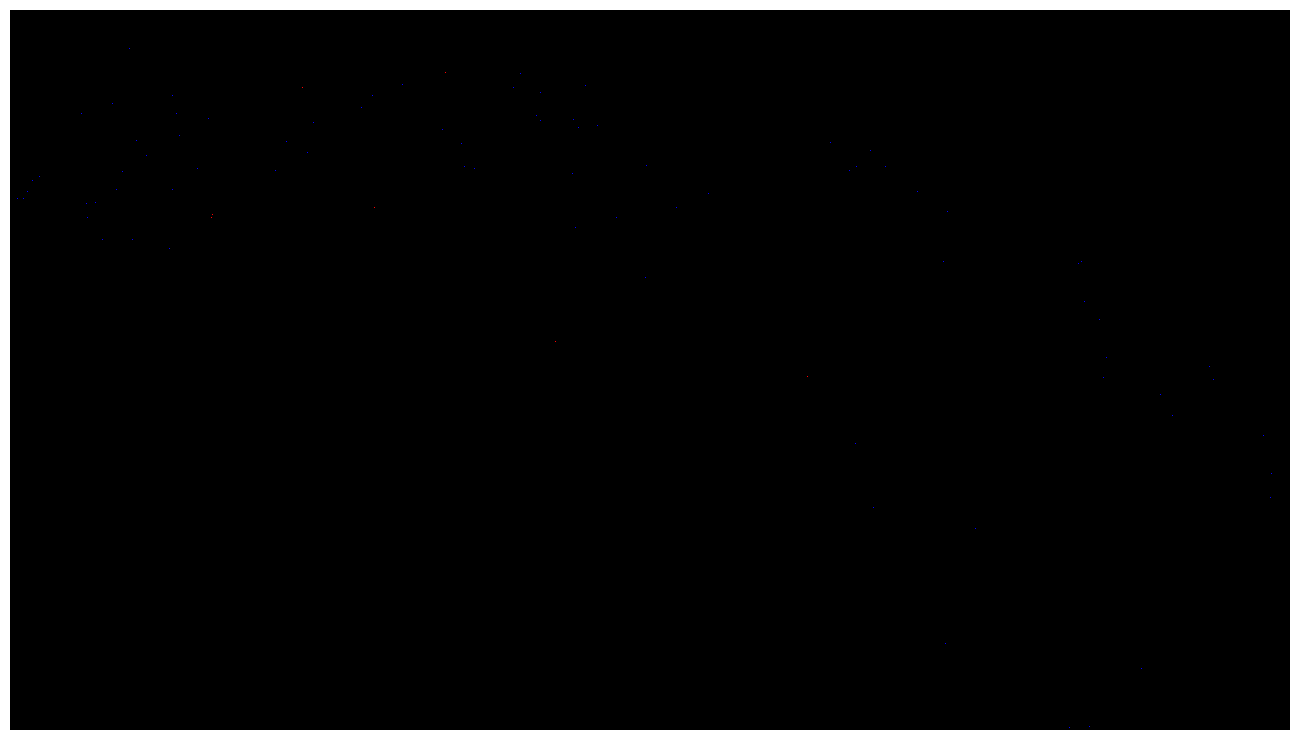

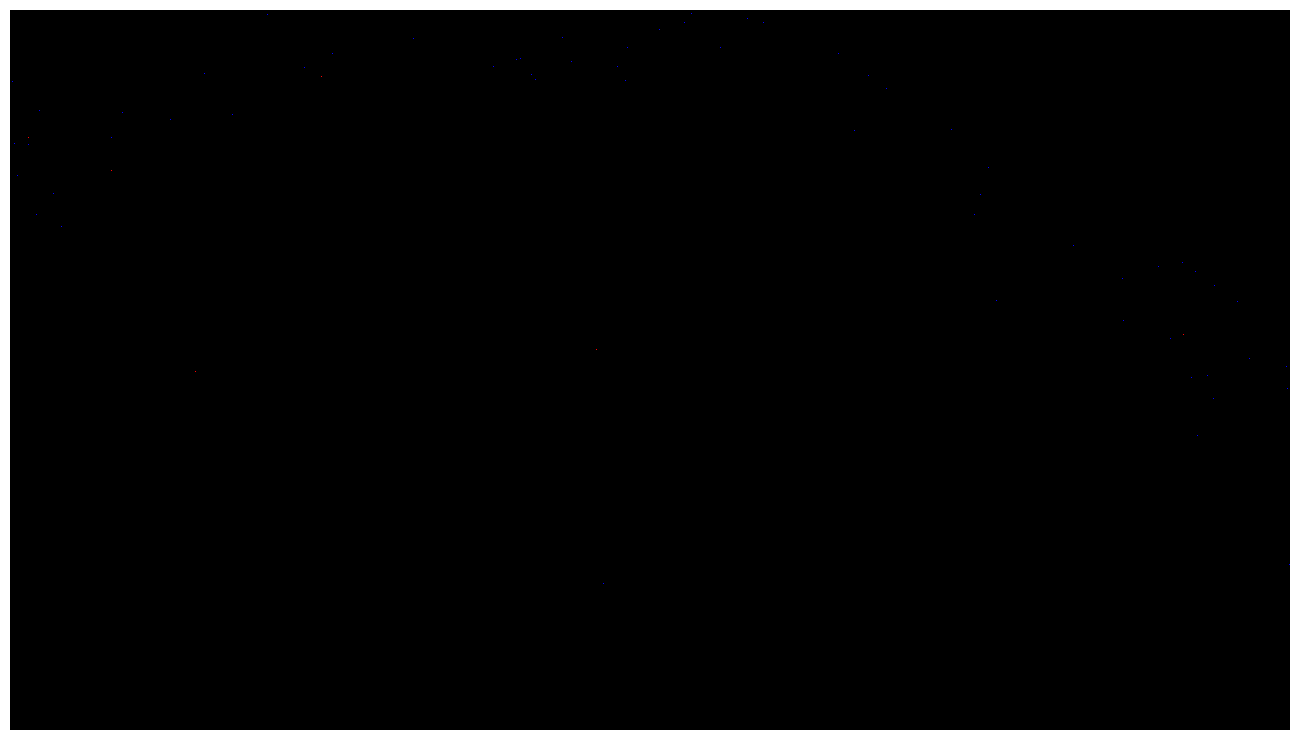

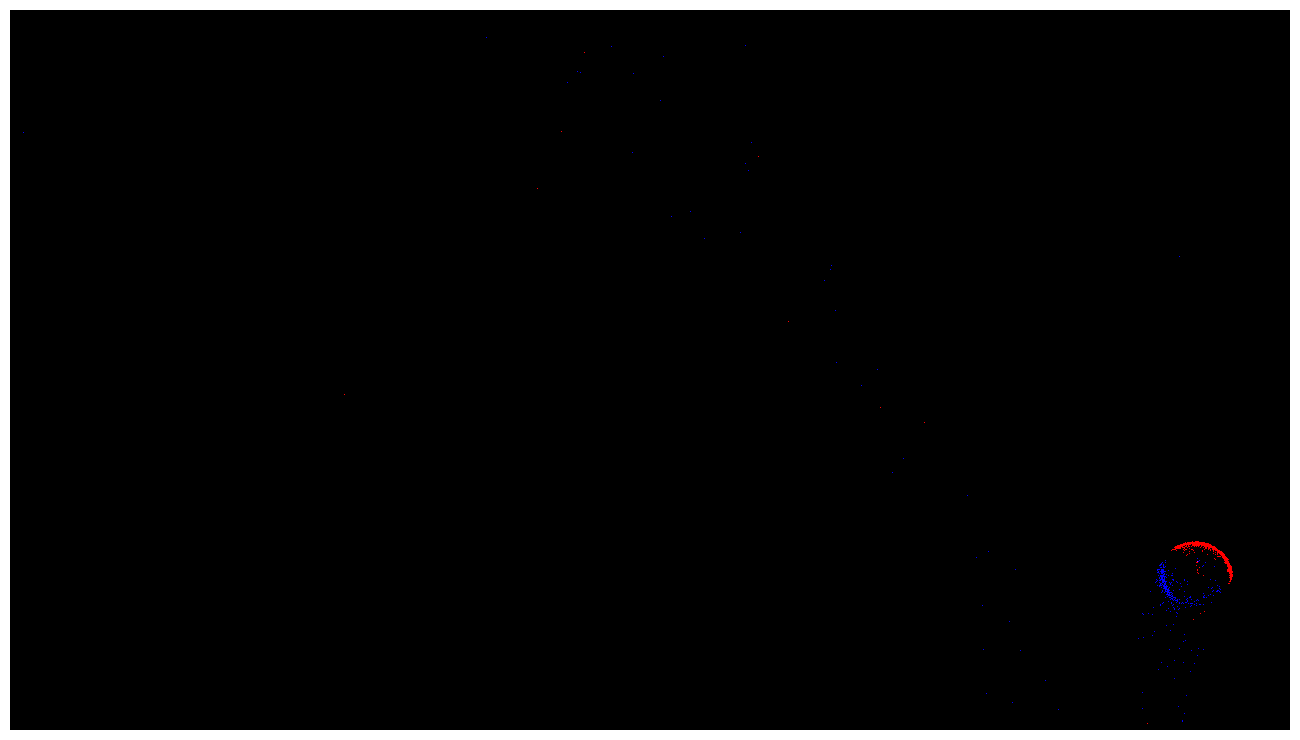

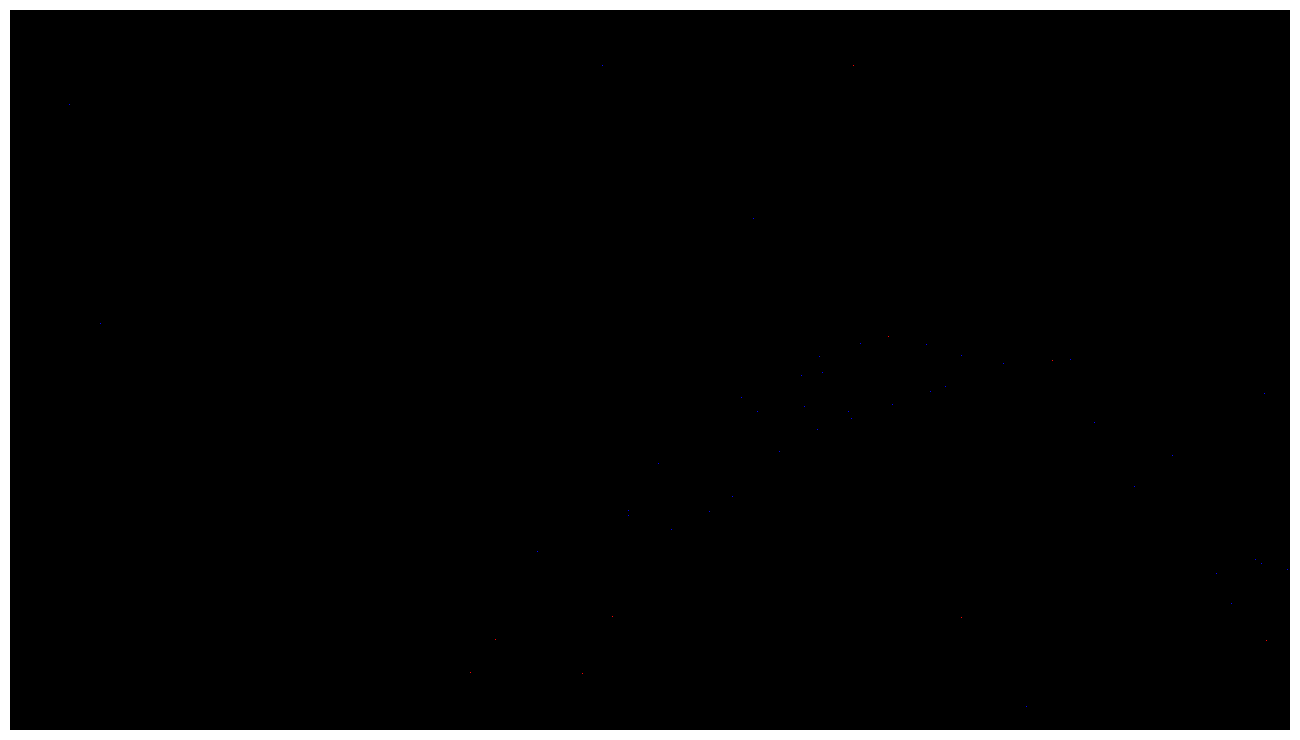

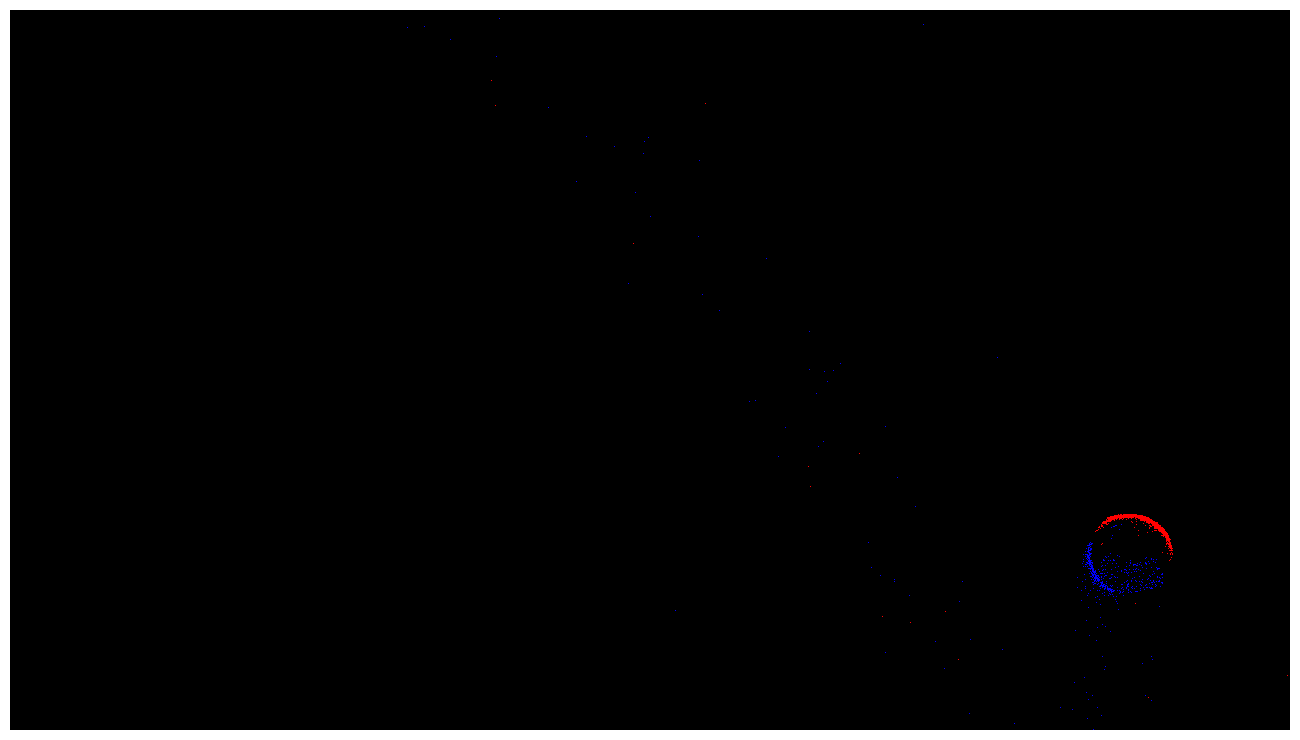

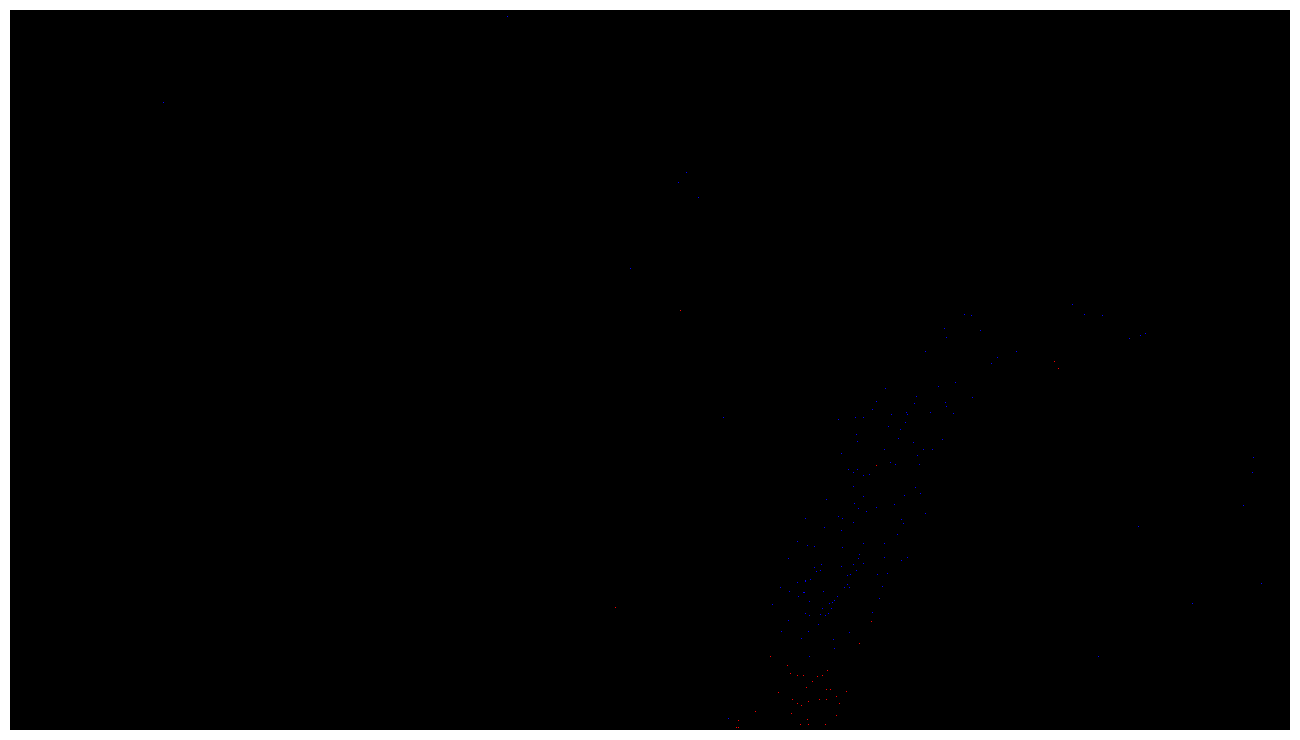

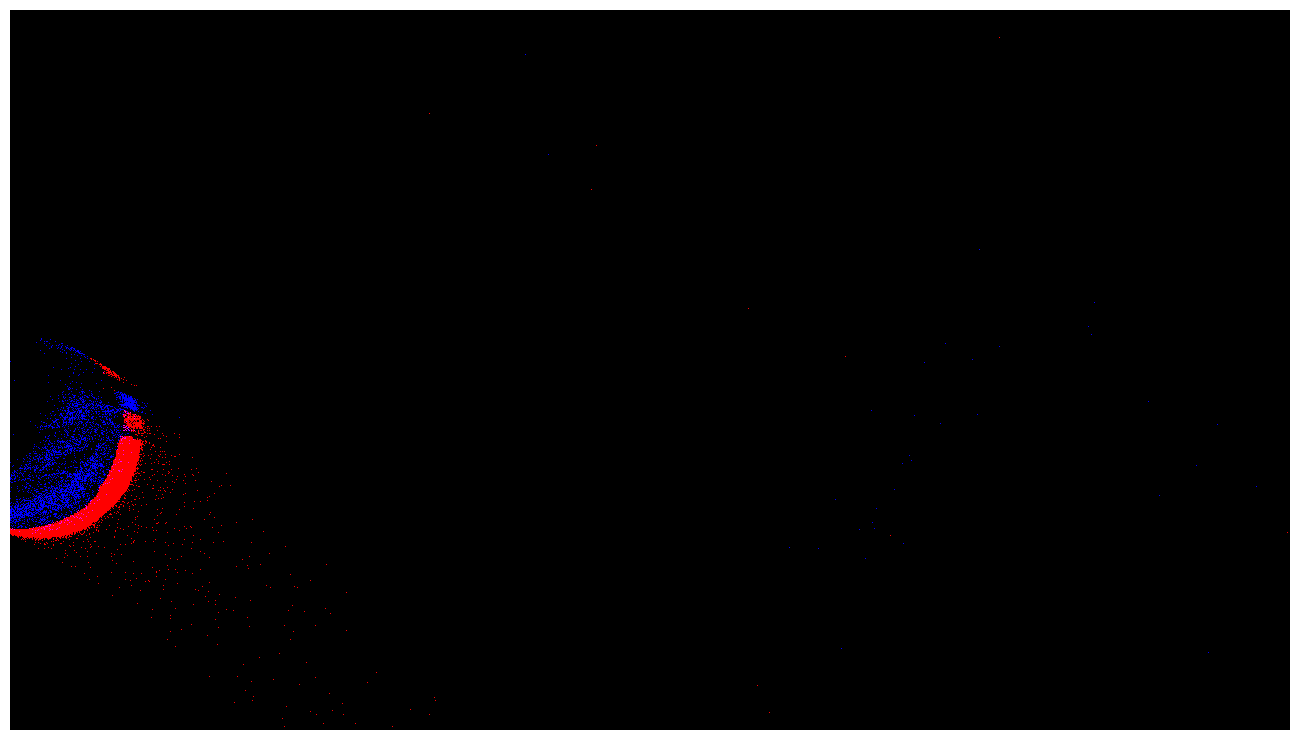

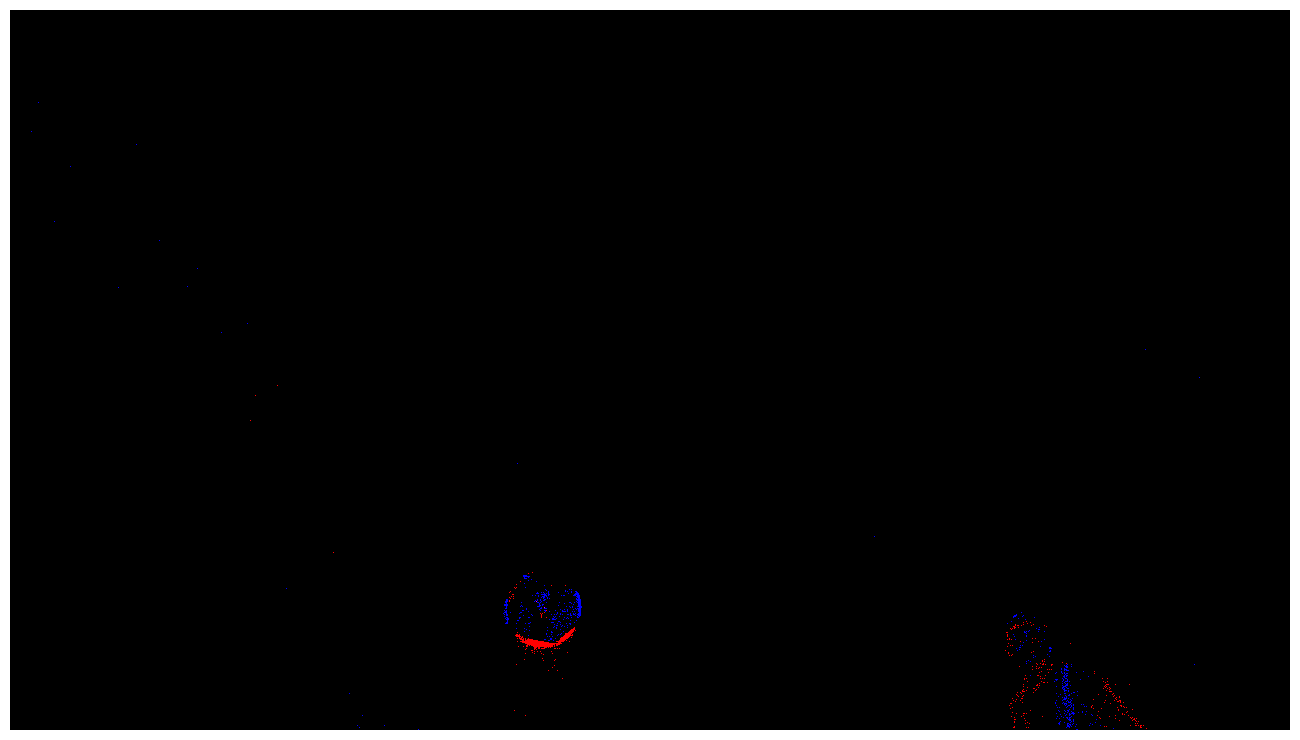

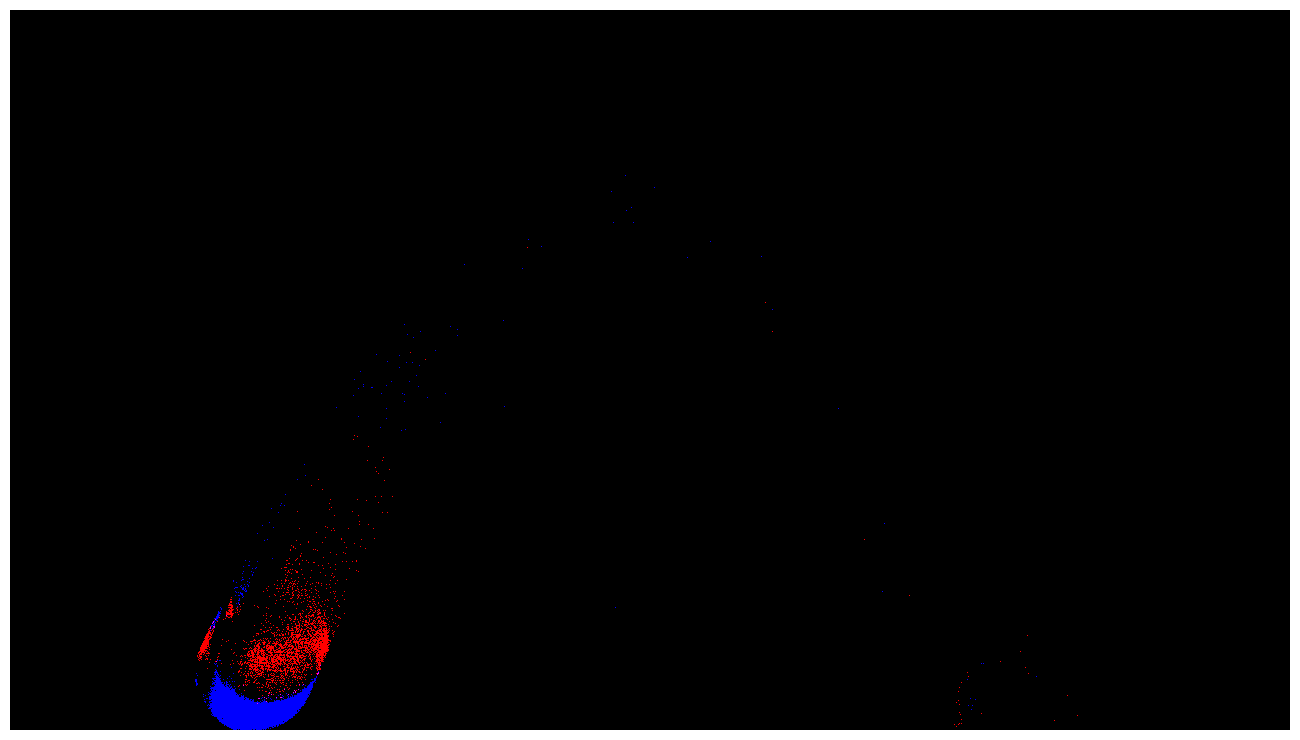

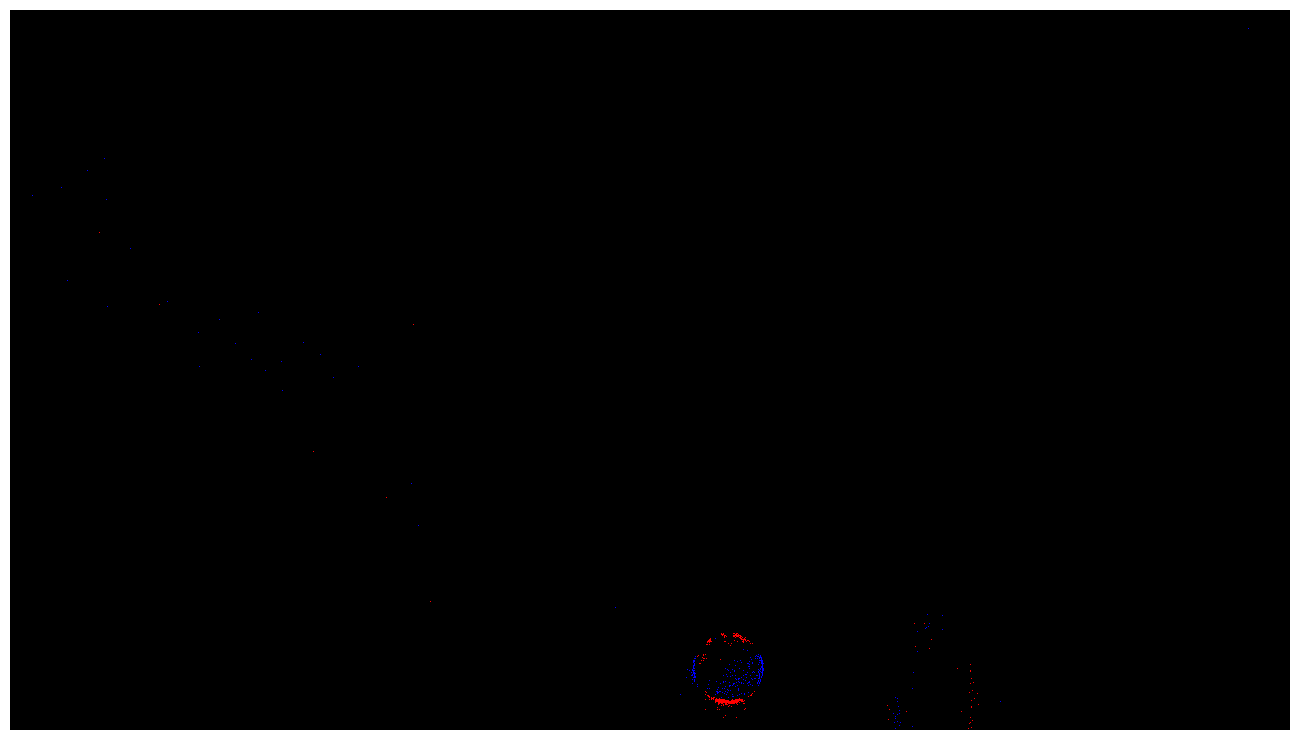

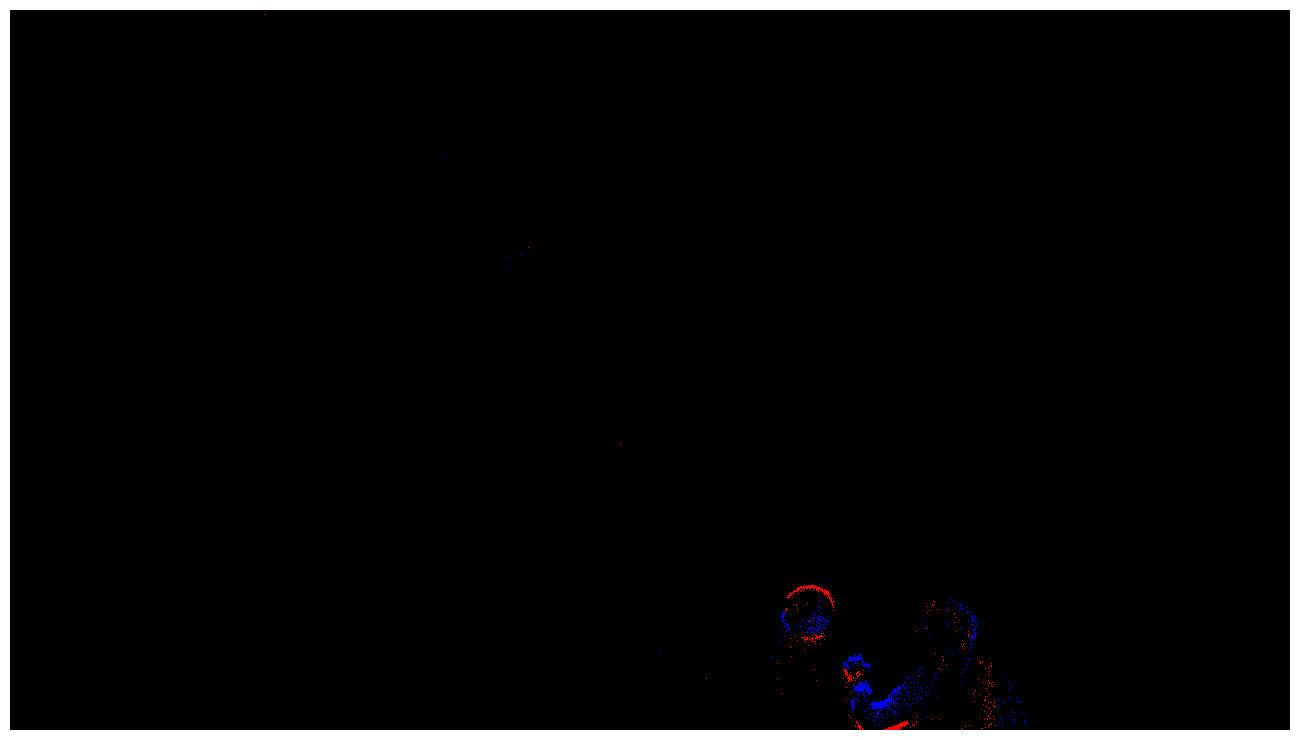

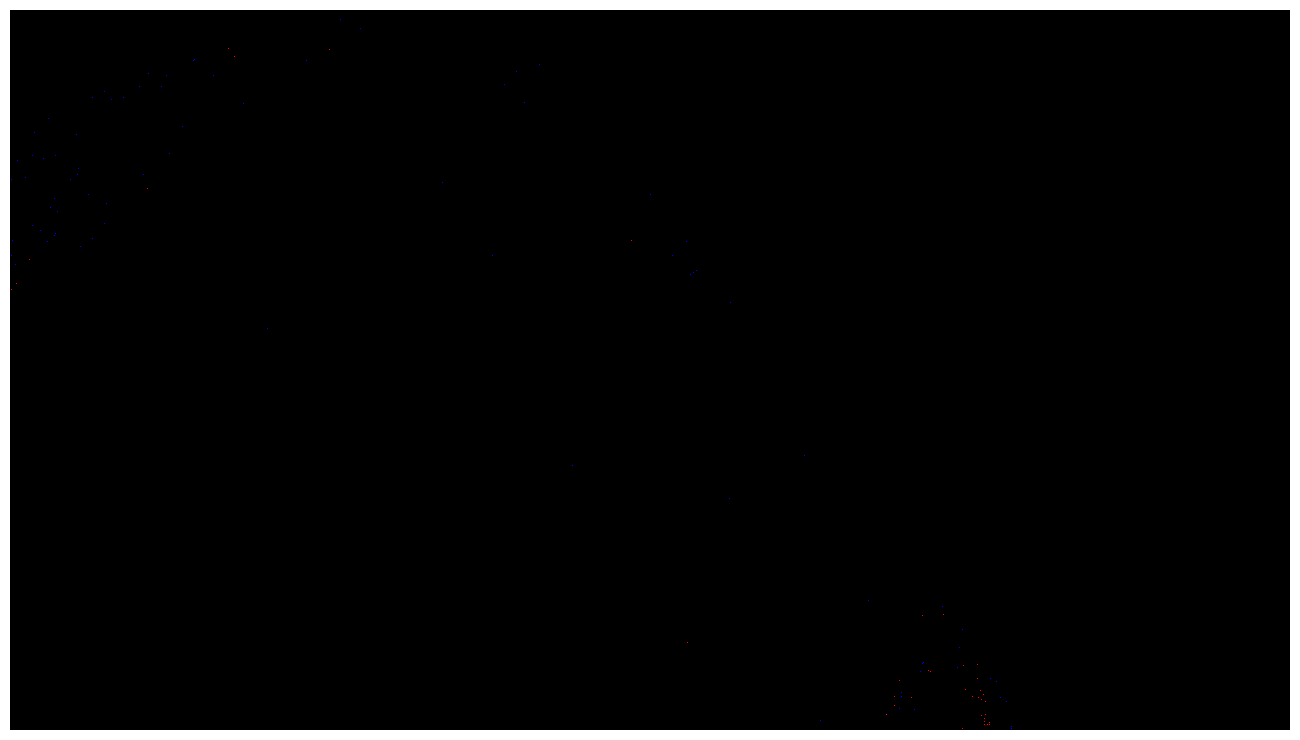

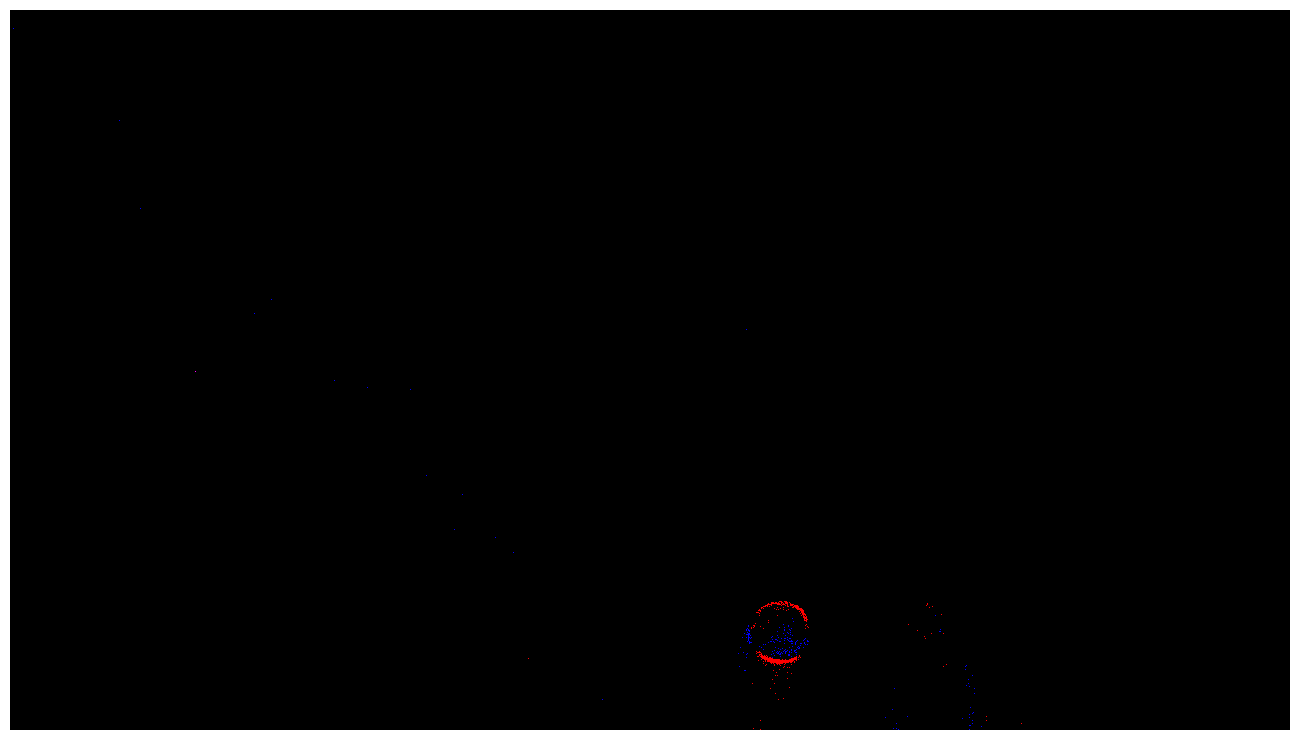

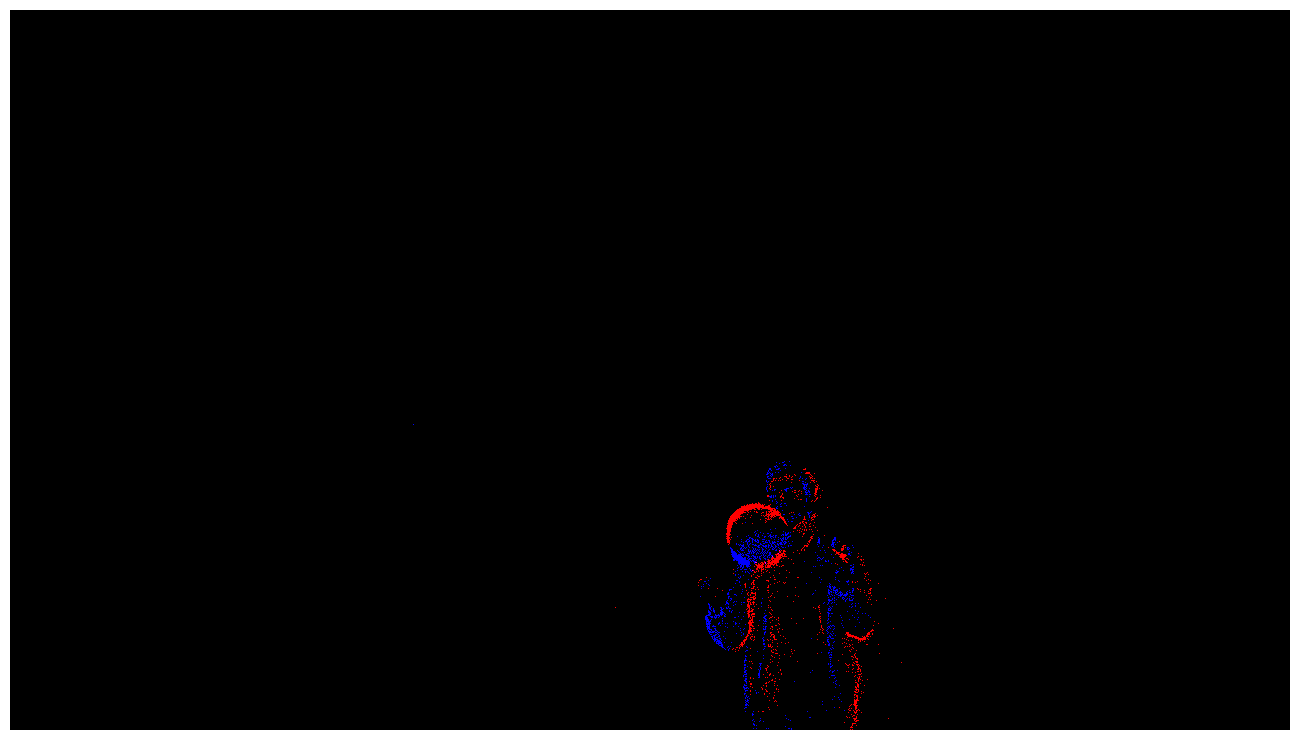

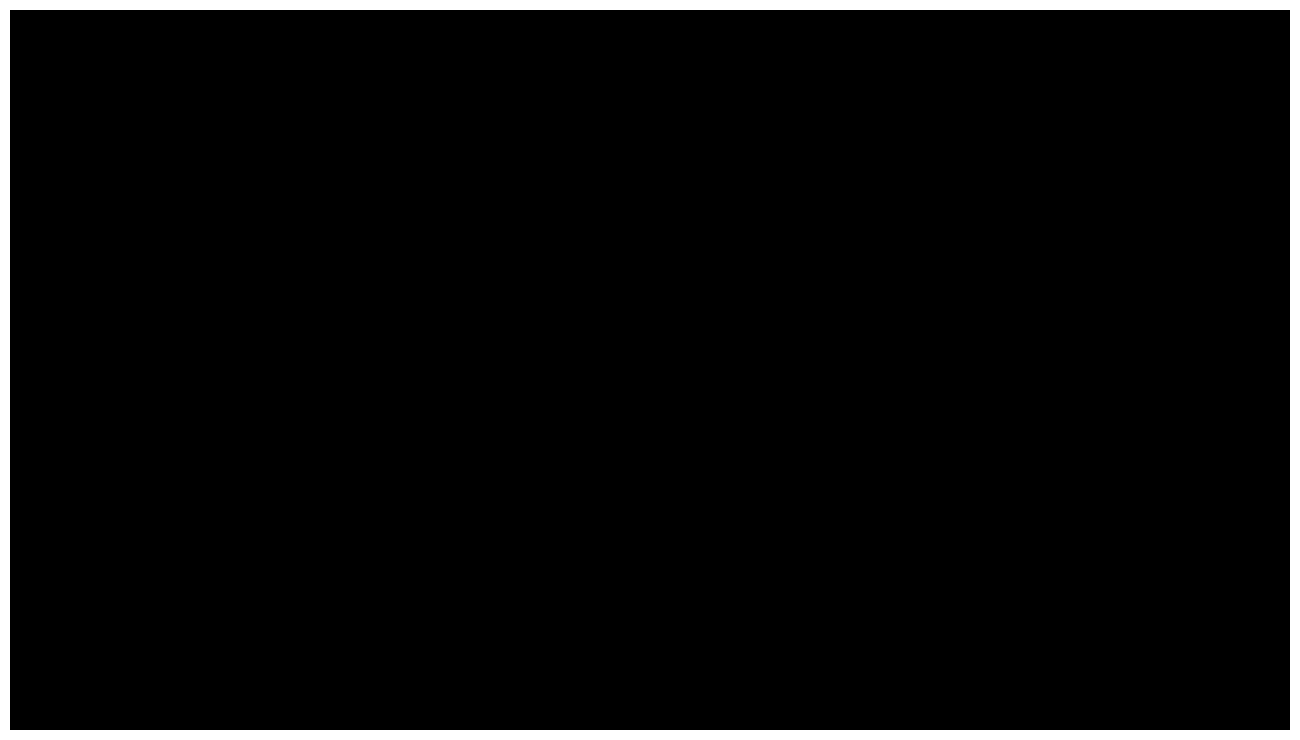

----------------------------------------
Cropping video  Event_camera_data\recording_2025-02-20_13-45-16.raw
Duration: 75.0 s
Average event rate: 18.27
Using threshold: 91.35042906945563
Found 12 high event intervals
Saved cropped_videos/ev_13-45-16_0.mp4
Saved cropped_videos/ev_13-45-16_1.mp4
Saved cropped_videos/ev_13-45-16_2.mp4
Saved cropped_videos/ev_13-45-16_3.mp4
Saved cropped_videos/ev_13-45-16_4.mp4
Saved cropped_videos/ev_13-45-16_5.mp4
Saved cropped_videos/ev_13-45-16_6.mp4
Saved cropped_videos/ev_13-45-16_7.mp4
Saved cropped_videos/ev_13-45-16_8.mp4
Saved cropped_videos/ev_13-45-16_9.mp4
Saved cropped_videos/ev_13-45-16_10.mp4
Saved cropped_videos/ev_13-45-16_11.mp4


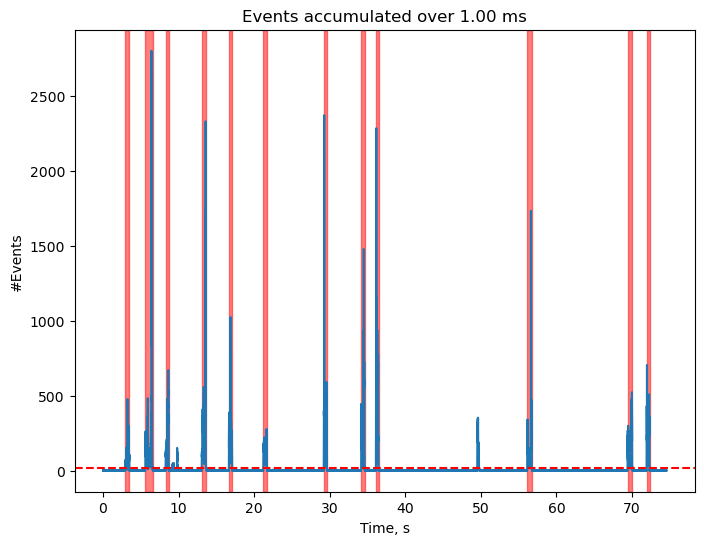

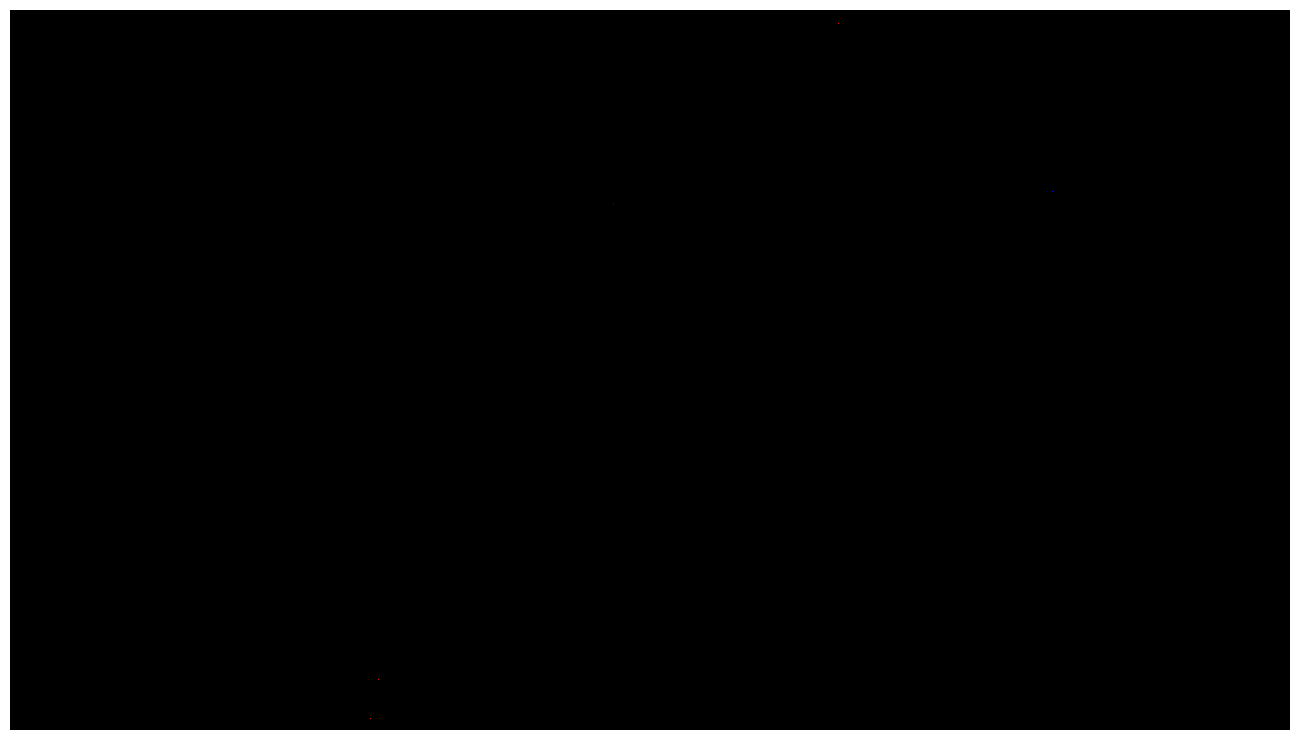

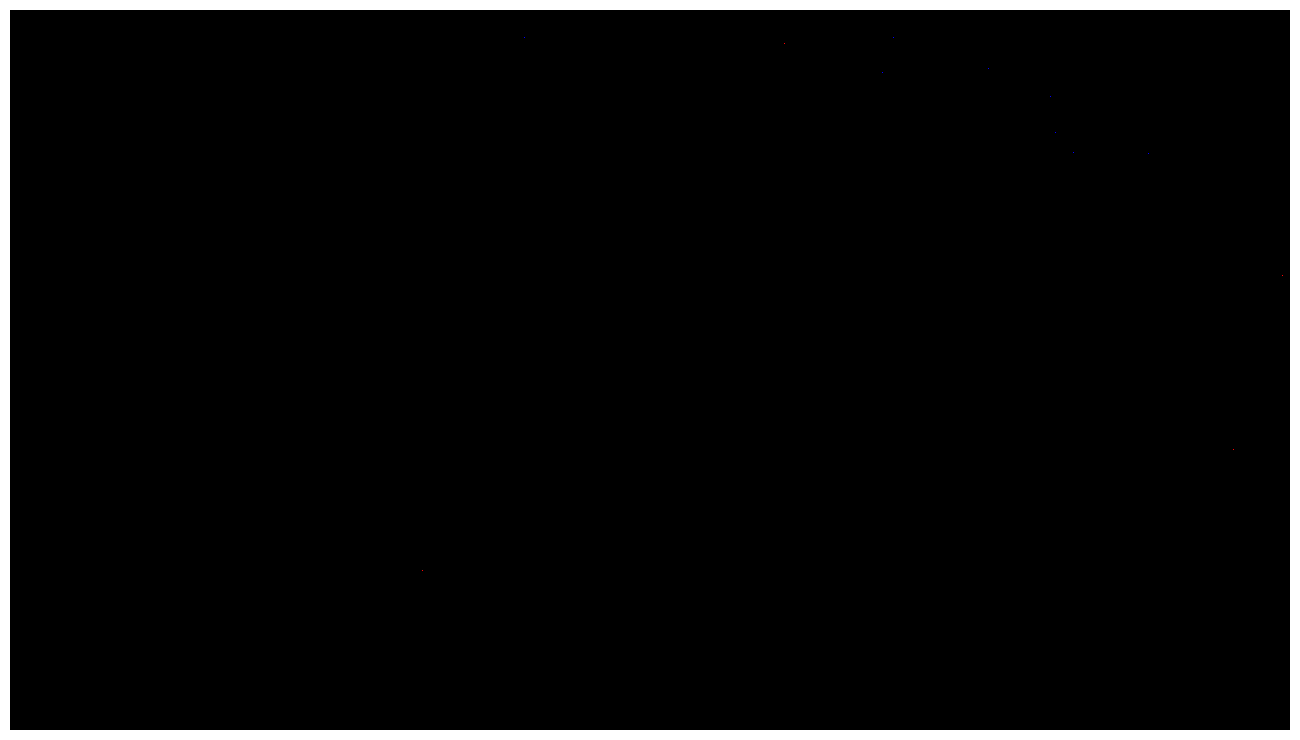

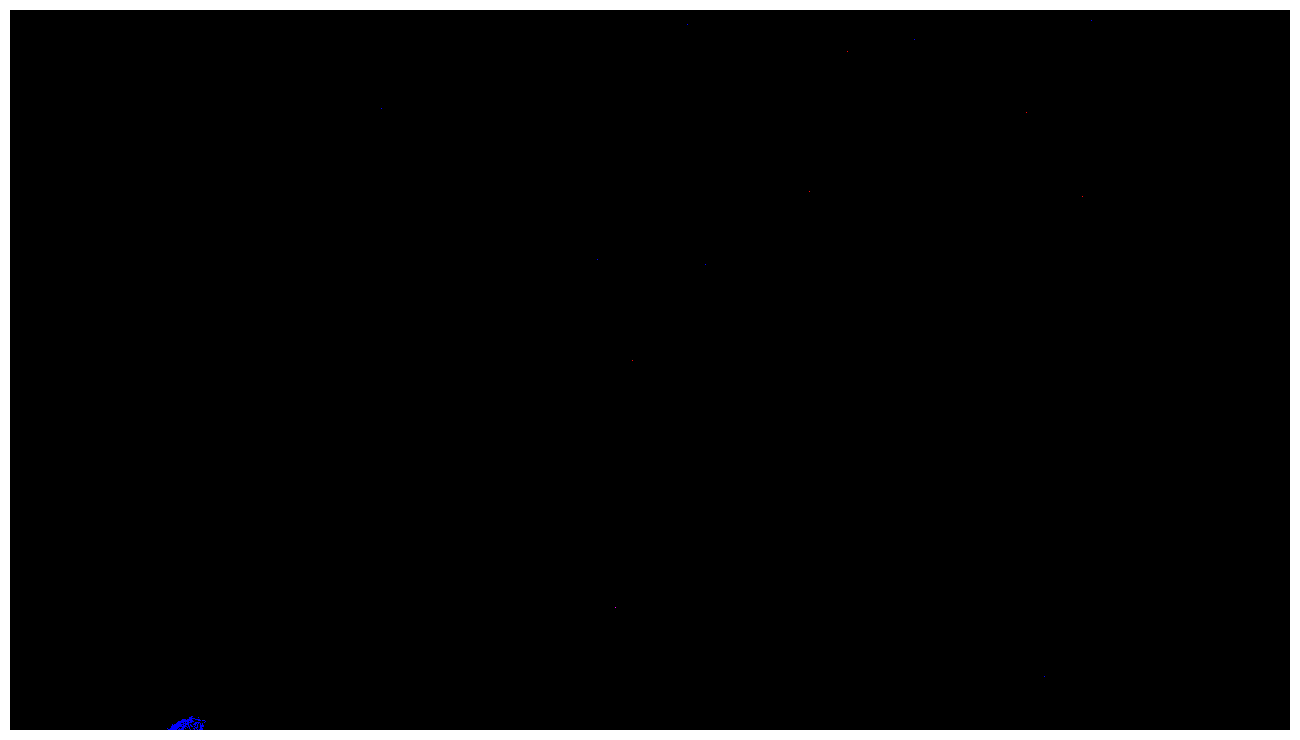

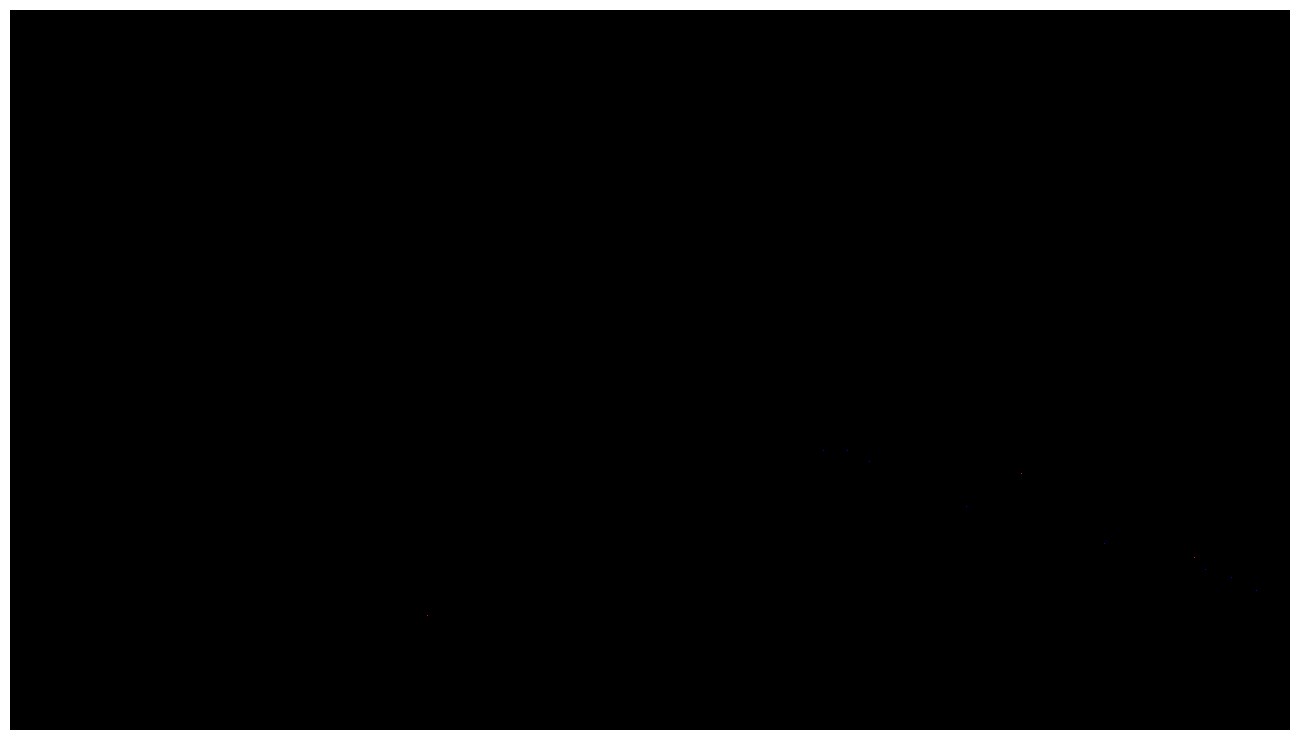

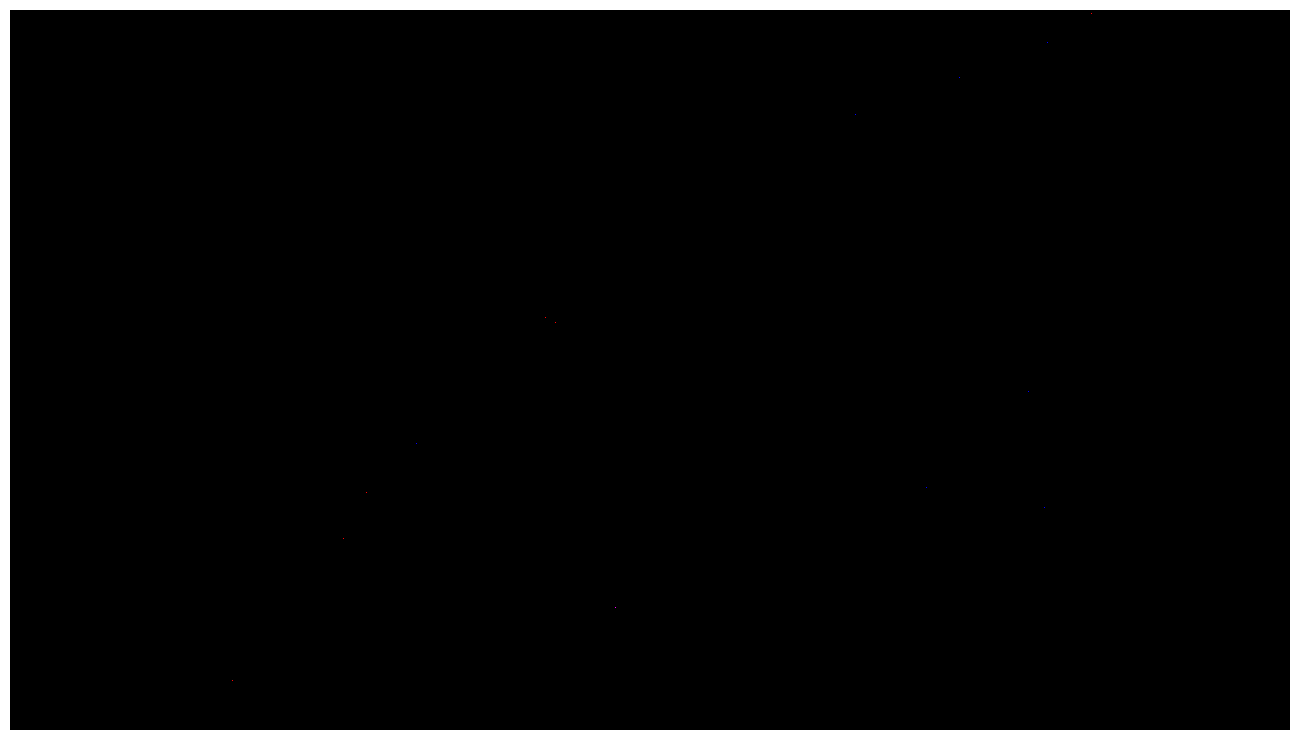

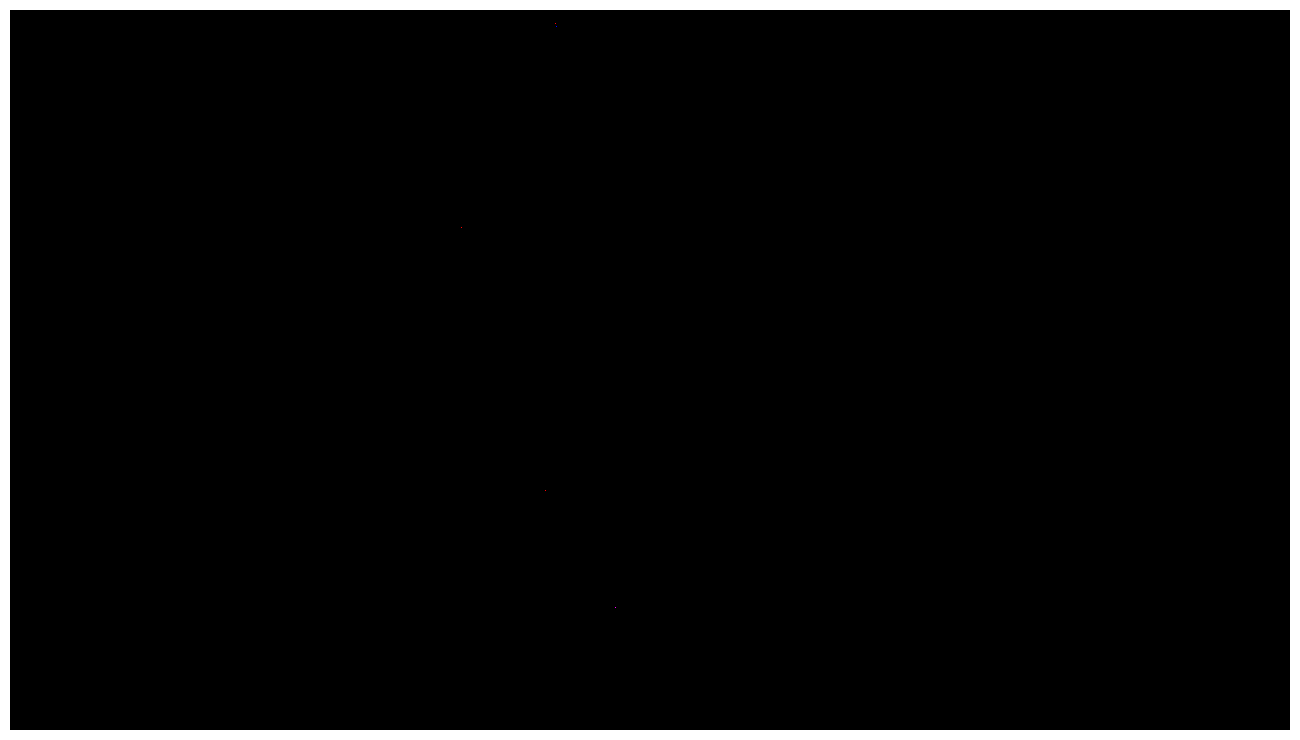

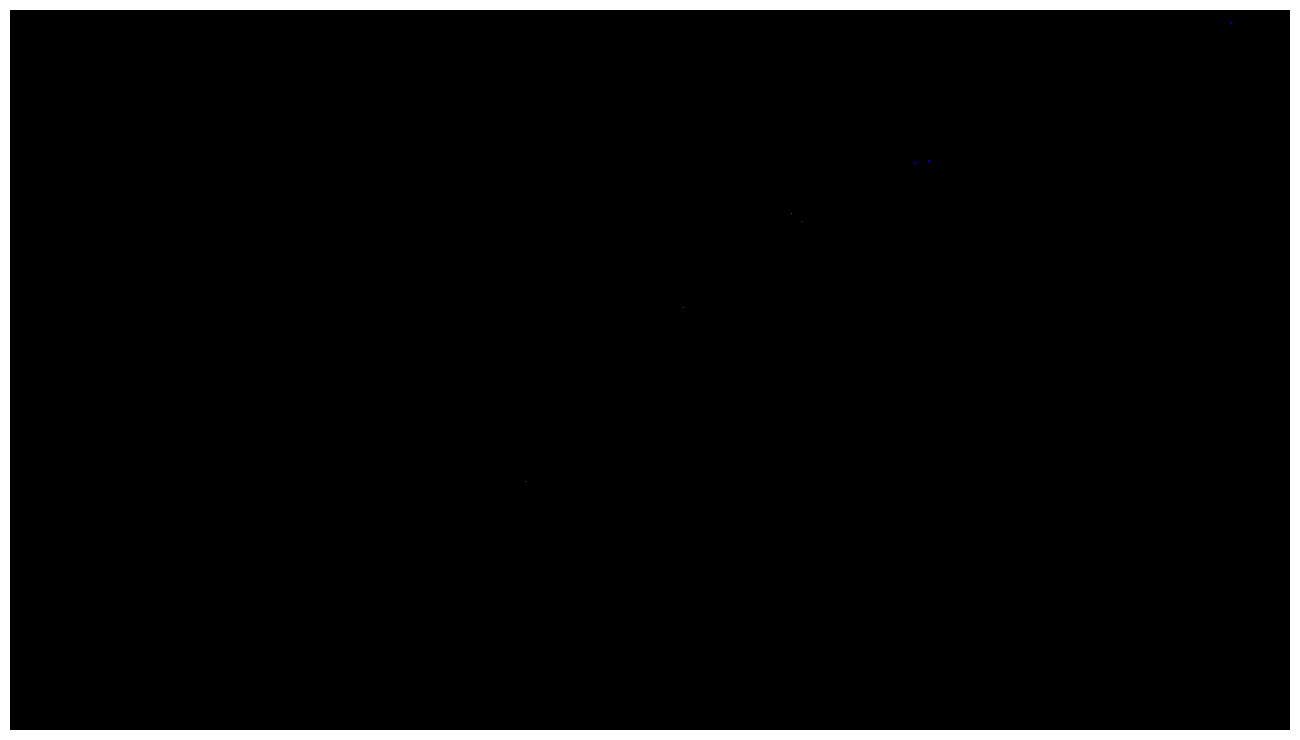

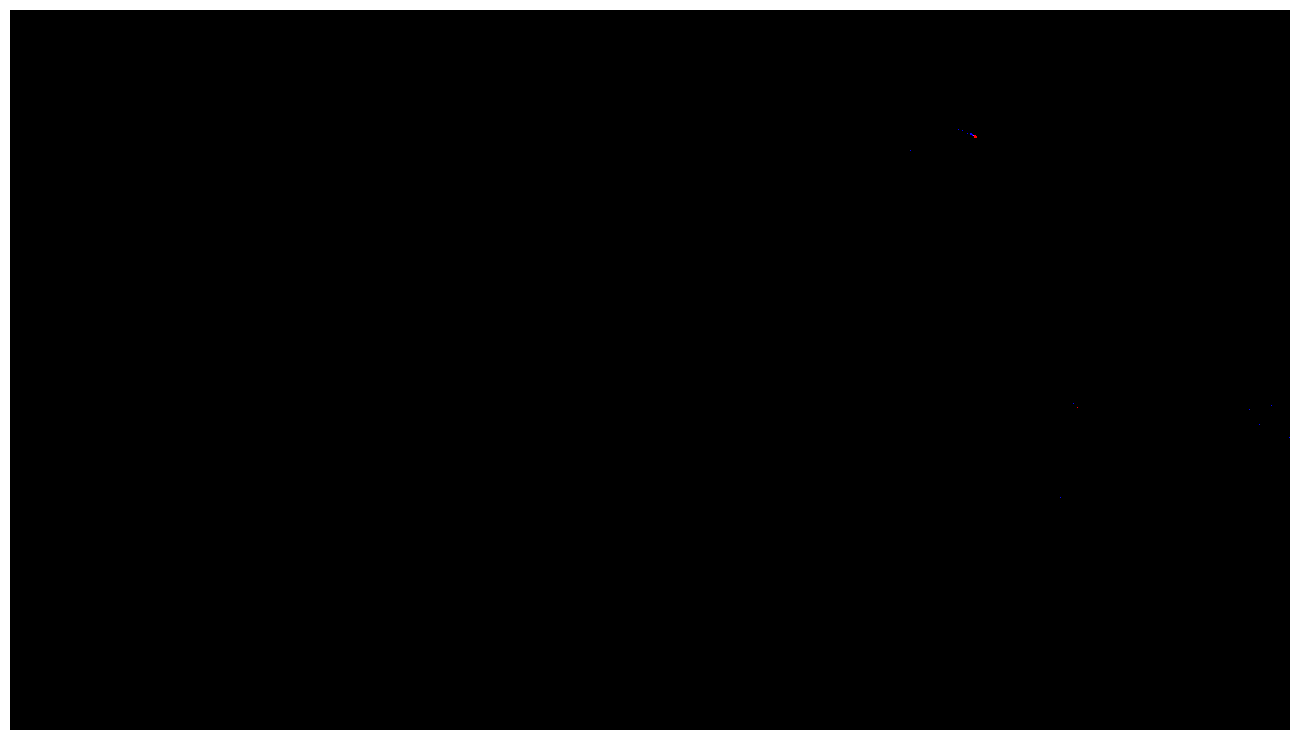

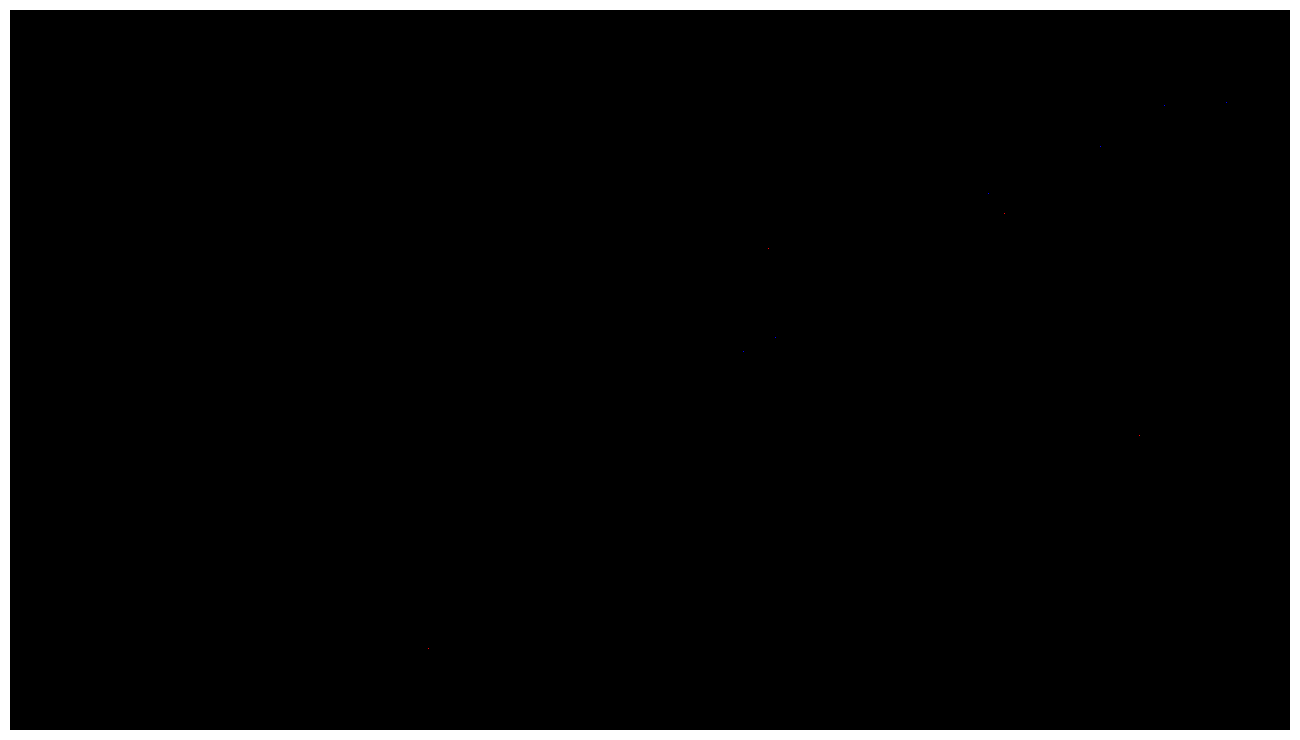

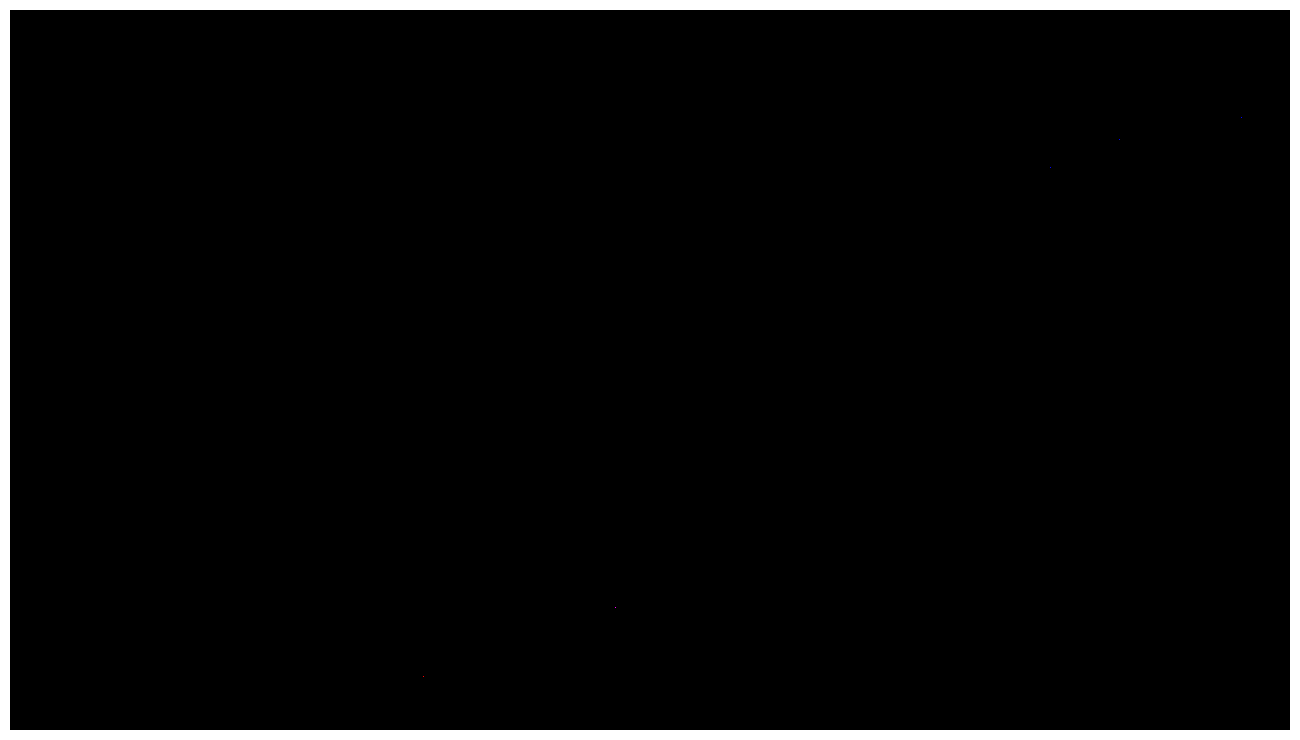

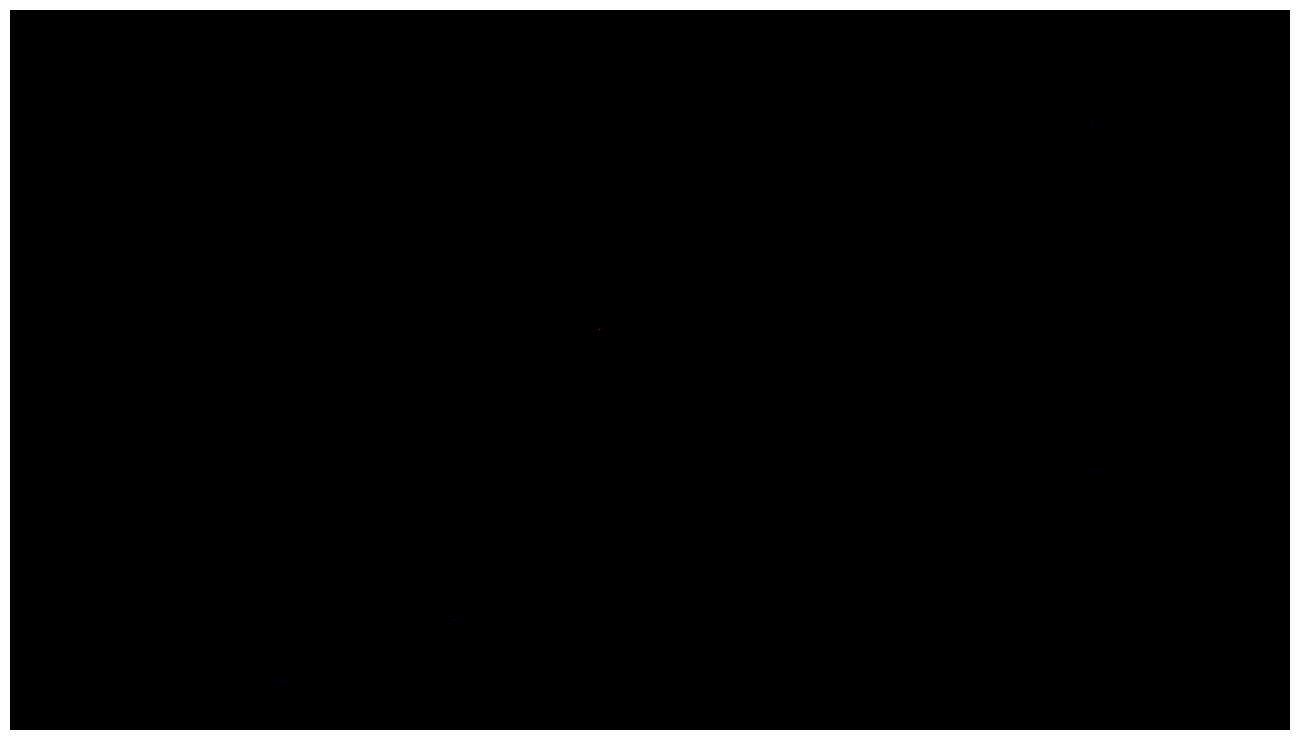

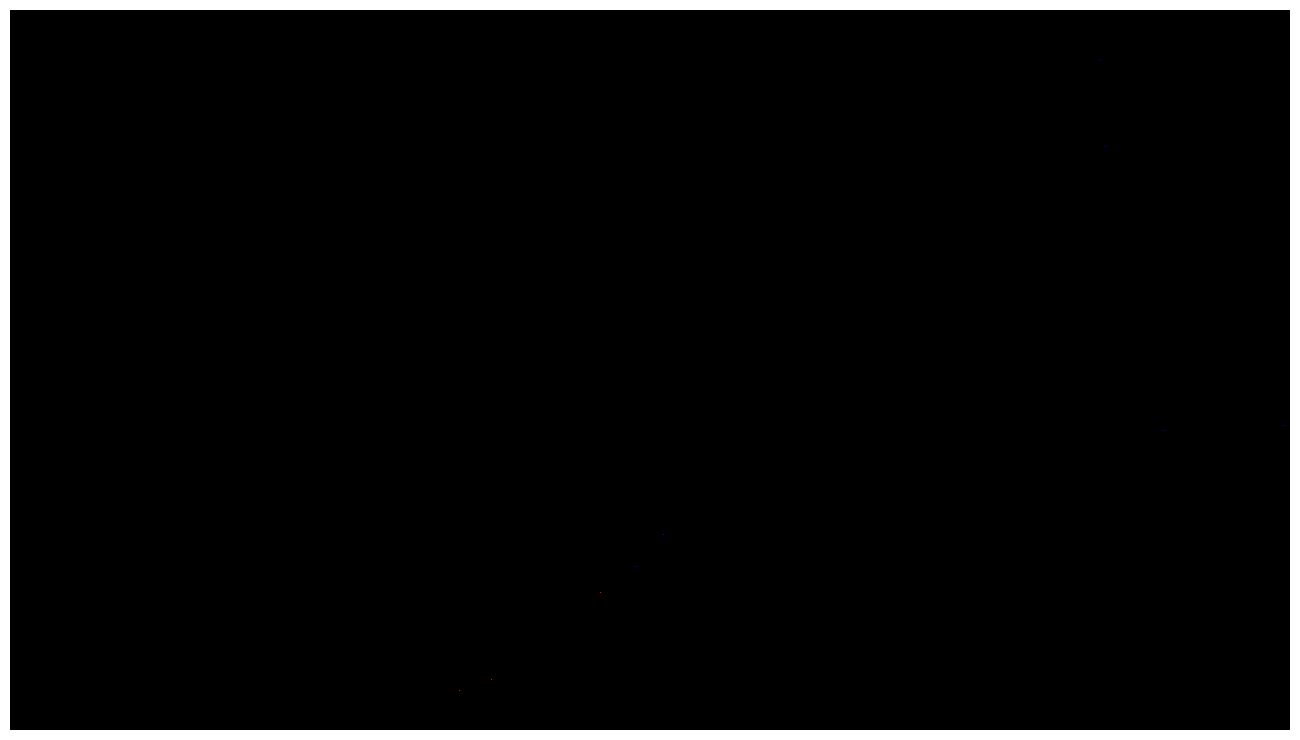

----------------------------------------
Cropping video  Event_camera_data\recording_2025-02-20_13-47-09.raw
Duration: 19.0 s
Average event rate: 1246.03
Using threshold: 6230.153239686858
Found 5 high event intervals
Saved cropped_videos/ev_13-47-09_0.mp4
Saved cropped_videos/ev_13-47-09_1.mp4
Saved cropped_videos/ev_13-47-09_2.mp4
Saved cropped_videos/ev_13-47-09_3.mp4
Saved cropped_videos/ev_13-47-09_4.mp4


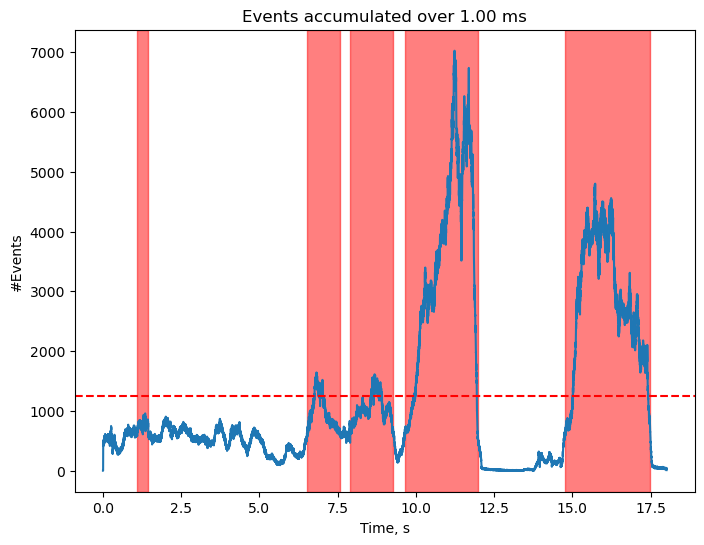

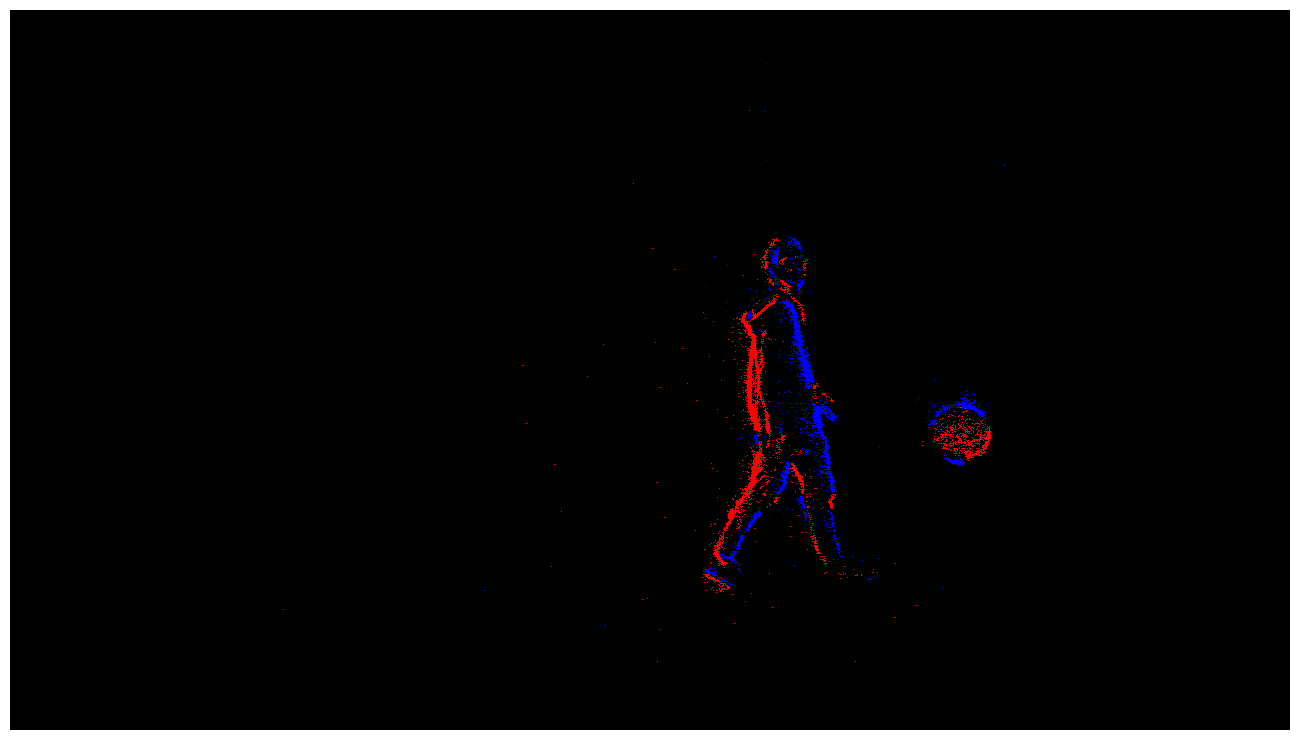

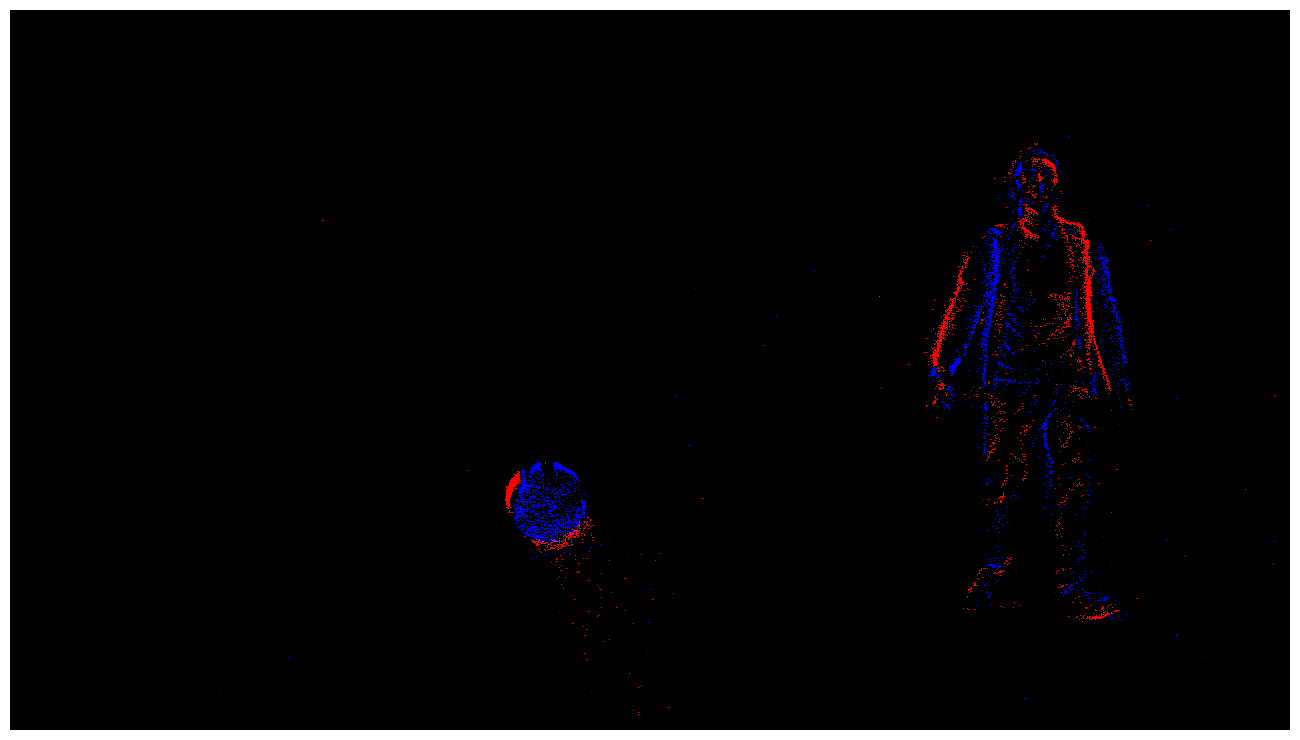

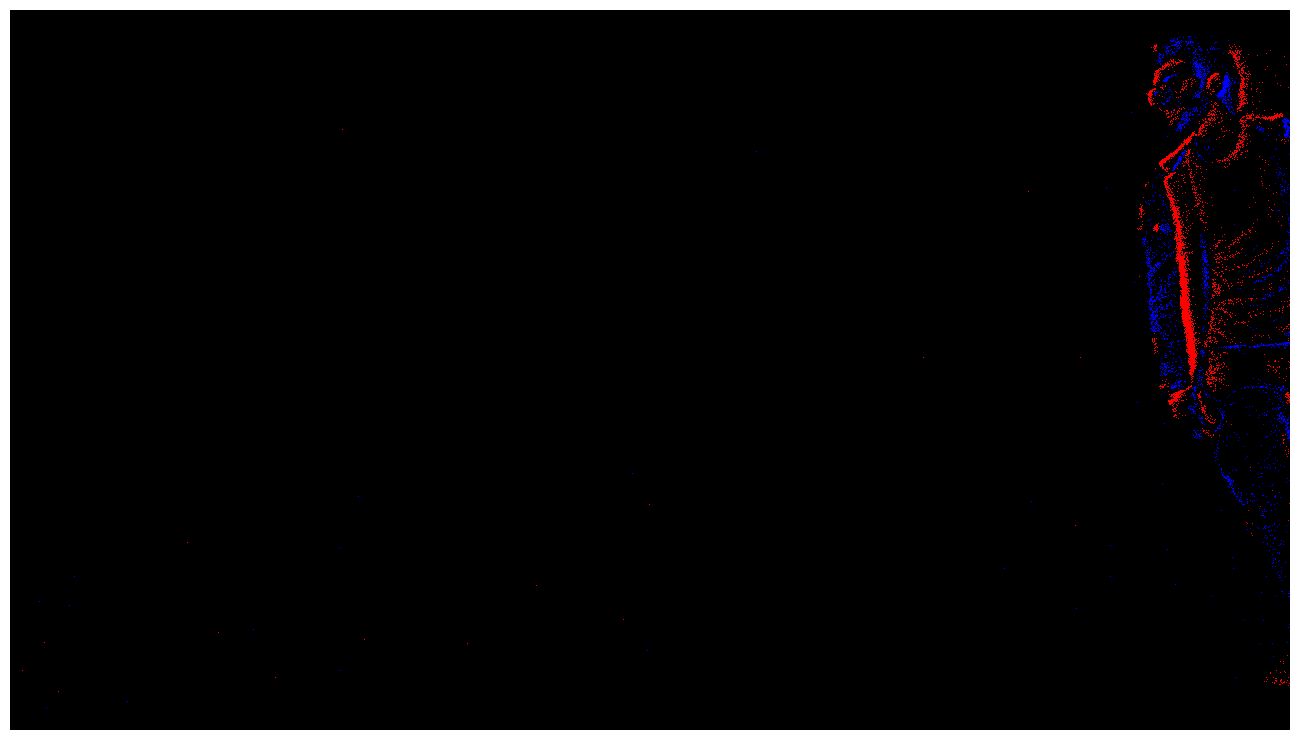

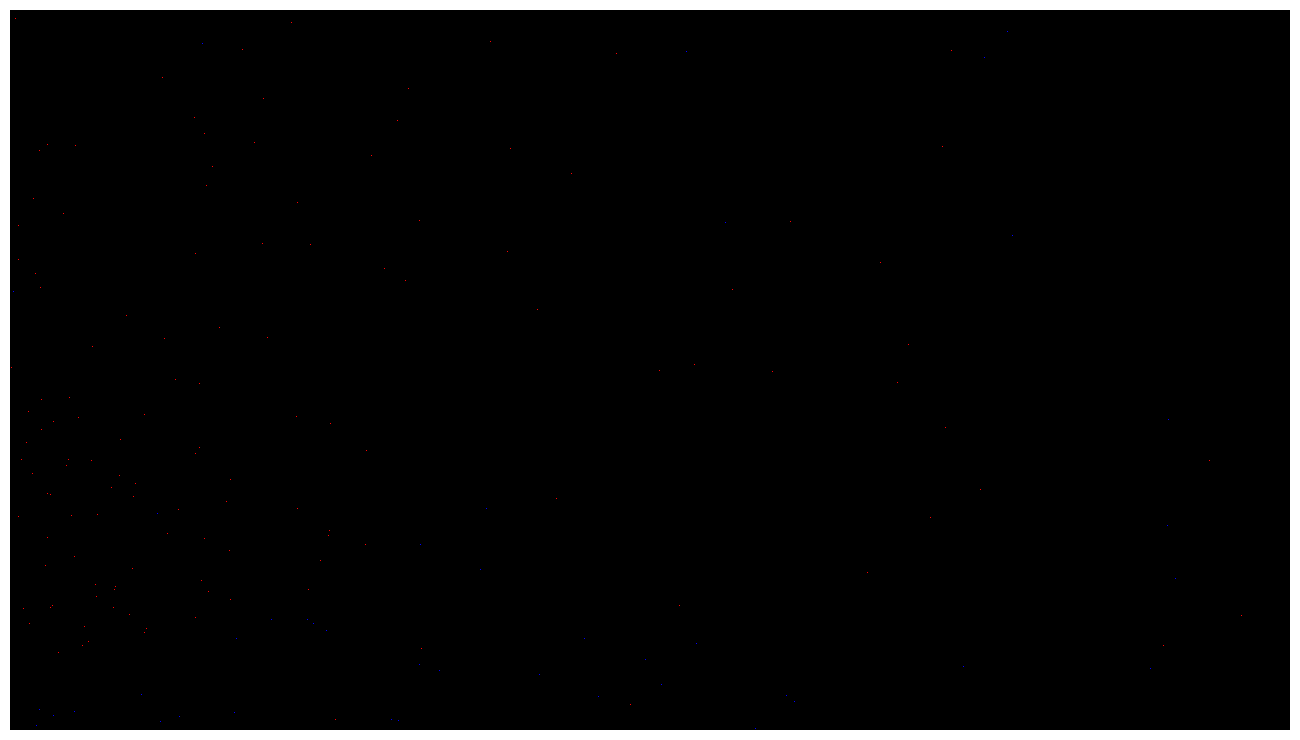

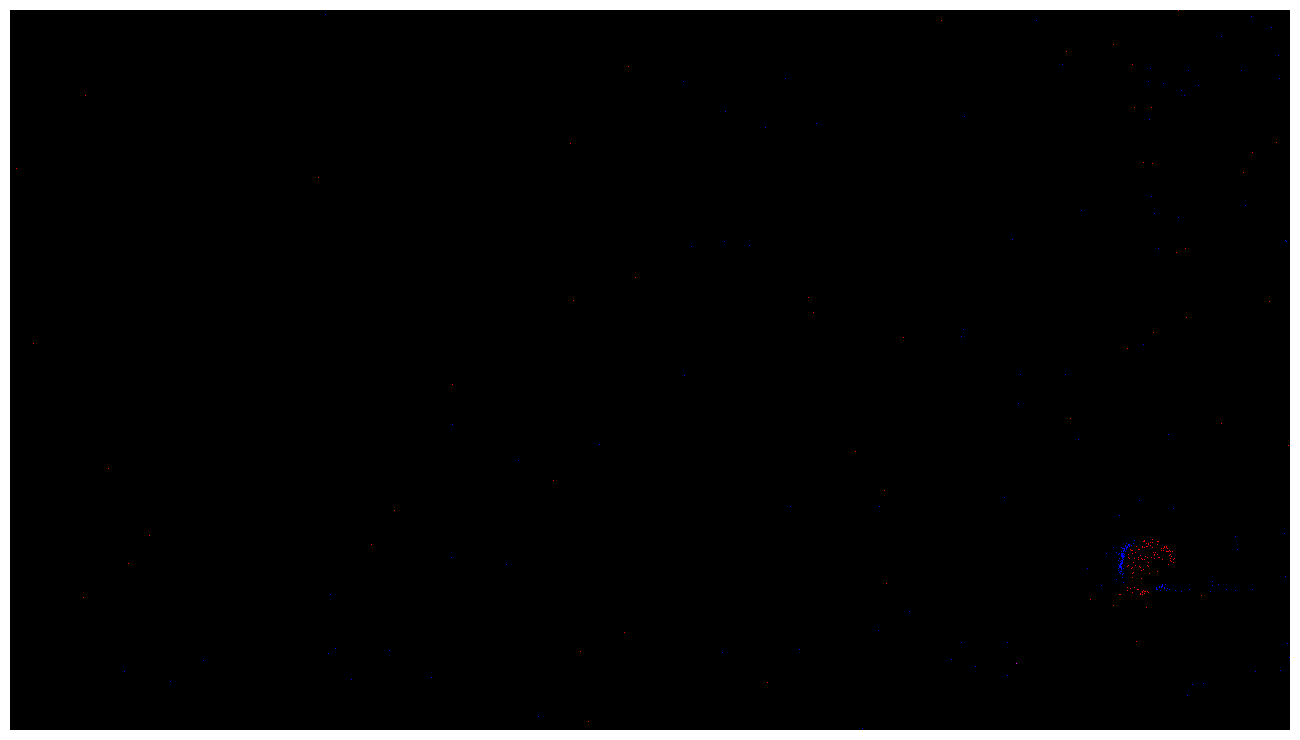

In [12]:
# path_to_events = dir_paths[3]
dir_paths_filtered = dir_paths
# dir_paths.pop(0)
for path_to_events in dir_paths_filtered:
    print('--'*20)
    print('Cropping video ', path_to_events)
    save_relevant_videos(path_to_events)